# 1. Description 1

The ToComFome app is a delivery food delivery app. Like every retail application, the company cares about the Churn of customers, that is, the loss of this customer to the competition. To understand the risk profile of the customer with a higher chance of churn, the CRM area asked for a project for the Data Analytics area to understand and classify the customer at risk of changing applications in the coming months.

For this, the CRM analytics passed a sample of 10 thousand customers with their respective registration and transaction information in the next 4 months from the date of extraction used as a reference (columns named as 'DataExtracao'). 


Business rules: 
If the customer has not made any in-app purchases in the last 30 days from the reference date (10/30/2019), it is considered that this customer has churned

In this project we will use the key-concepts widely used in CRM analytics, which are 'Life Time Value' (LTV), 'Customer Acquistion Cost' (CAC) and 'CAC Payback'.

Below, a self-explanatory image that shows how these metrics correlate

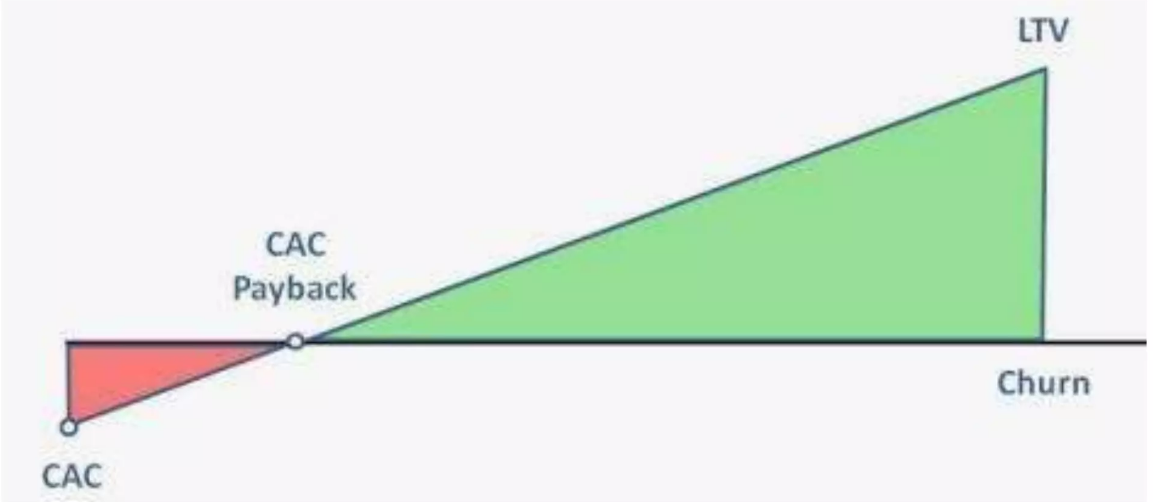

Date of reference: 30/10/2019 (dd/mm/yy)

Customer Life time value(LTV): R$ 416,54
    This value is calculated as the mean of transactions among all the customers in the next 4 months.

Customer acquisition Cost(CAC): R$ 110,00.
    Economic resource invested in marketing campaing to attract those customers.
    
Discount value of the coupon: R$ 75,00.
    Discount offered for each customer who has given churn (Supposing the customer uses the coupon)
    
So far, the company has not implemented any sort of prediction models.



# 2. Metadata

| Table Name   | Variable               | Description                                                                                                                                                                                         |
|--------------|------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| fato_churn   | ClientId               | Client identifier (PK field)                                                                                                                                                                       |
| fato_churn   | DataUltimaTransacao    | The date of the last transaction made by each client, extracted on October 30, 2019 at 11:59 PM from the client in the application                                                                  |
| dim_clientes | ClientId               | Client identifier (PK field)                                                                                                                                                                       |
| dim_clientes | DataExtracao           | Date of extraction of this customer view                                                                                                                                                 |
| dim_clientes | Score_Credito          | Credit score in the market. The company purchased this variable from a Credit Bureau. The closer to 1000, the better the client's position regarding default.                                      |
| dim_clientes | Estado                 | Customer's state                                                                                                                                                                                    |
| dim_clientes | Gênero                 | Customer's gender                                                                                                                                                                                   |
| dim_clientes | Idade                  | Customer's age                                                                                                                                                                                      |
| dim_clientes | Tempo_Cliente          | Time in months that the customer has been using the application                                                                                                                                     |
| dim_clientes | Limite_Credito_Mercado| Credit limit that the customer has in the market. The company purchased this variable from a Credit Bureau. The higher the limit, the greater the chance the customer has a good purchasing power.|
| dim_clientes | Qte_Categorias         | Quantity of product categories (e.g., snacks, Japanese food, sweets, etc.) ordered in the last 3 months prior to the extraction date.                                                            |
| dim_clientes | Usa_Cartao_Credito     | Flag if the customer has registered a credit card in the application. 1 = Registered and 0 = Not Registered                                                                                      |
| dim_clientes | Programa_Fidelidade    | Flag if the customer participates in a loyalty program in the application. 1 = Participates and 0 = Does Not Participate.                                                                        |
| dim_clientes | Sum_Pedidos_Acumulados | Values spent on the application in the last 3 months prior to the extraction date.                                                                                                                  |


## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib
import preditiva_2

#Importando biblioteca para estatísticas descritivas
import scipy.stats

# Importando bibliotecas, para a plotagem de gráficos interativos com o plotly.
%matplotlib inline

import plotly.offline as py

import plotly.graph_objs as go

import plotly.figure_factory as ff

import kaleido

#Importando biblioteca de padronização 
from sklearn.preprocessing import MinMaxScaler, StandardScaler



py.init_notebook_mode(connected = False)

# Data loading

In [2]:
df = pd.read_csv('Churn_Clientes.csv', sep = ';')

In [3]:
df.shape

(10000, 14)

In [4]:
df.head()

ClientId DataExtracao  Score_Credito          Estado    Gênero  Idade  \
0    345568   30/06/2019            619       S�o Paulo  Feminino     42   
1    345569   30/06/2019            608  Rio de Janeiro  Feminino     41   
2    345570   30/06/2019            502       S�o Paulo  Feminino     42   
3    345571   30/06/2019            699       S�o Paulo  Feminino     39   
4    345572   30/06/2019            850  Rio de Janeiro  Feminino     43   

   Tempo_Cliente limite_credito_mercado  Qte_Categorias  Usa_Cartao_Credito  \
0              2                     0.               1                   1   
1              1                 838.08               1                   0   
2              8               1,596.61               3                   1   
3              1                     0.               2                   0   
4              2               1,255.11               1                   1   

   Programa_Fidelidade  sum_pedidos_acumulado DataUltimaTransacao  churn  
0                    1                 422.29          14/09/2019      1  
1                    1                 468.93          05/10/2019      0  
2                    0                 474.71          20/08/2019      1  
3                    0                 390.94          21/10/2019      0  
4                    1                 329.52          26/10/2019      0

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ClientId                10000 non-null  int64  
 1   DataExtracao            10000 non-null  object 
 2   Score_Credito           10000 non-null  int64  
 3   Estado                  10000 non-null  object 
 4   Gênero                  10000 non-null  object 
 5   Idade                   10000 non-null  int64  
 6   Tempo_Cliente           10000 non-null  int64  
 7   limite_credito_mercado  10000 non-null  object 
 8   Qte_Categorias          10000 non-null  int64  
 9   Usa_Cartao_Credito      10000 non-null  int64  
 10  Programa_Fidelidade     10000 non-null  int64  
 11  sum_pedidos_acumulado   10000 non-null  float64
 12  DataUltimaTransacao     10000 non-null  object 
 13  churn                   10000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memo

In [6]:
# Removing comma from 'limite_credito_mercado'
df['limite_credito_mercado'] = df['limite_credito_mercado'].str.replace(',', '')

# Transforming 'limite_credito_mercado' to float
df['limite_credito_mercado'] = df['limite_credito_mercado'].astype(float)


In [7]:
# Transforming to date type
df['DataUltimaTransacao'] = pd.to_datetime(df['DataUltimaTransacao'],dayfirst = True)

df['DataExtracao'] = pd.to_datetime(df['DataExtracao'])



In [8]:
df['DataUltimaTransacao']

0      2019-09-14
1      2019-10-05
2      2019-08-20
3      2019-10-21
4      2019-10-26
          ...    
9995   2019-10-05
9996   2019-10-06
9997   2019-07-21
9998   2019-08-19
9999   2019-10-17
Name: DataUltimaTransacao, Length: 10000, dtype: datetime64[ns]

In [9]:
df['Mês_UltimaTransacao']  = df['DataUltimaTransacao'].dt.month_name()


In [10]:
df['Mês_UltimaTransacao'].unique()

array(['September', 'October', 'August', 'July'], dtype=object)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ClientId                10000 non-null  int64         
 1   DataExtracao            10000 non-null  datetime64[ns]
 2   Score_Credito           10000 non-null  int64         
 3   Estado                  10000 non-null  object        
 4   Gênero                  10000 non-null  object        
 5   Idade                   10000 non-null  int64         
 6   Tempo_Cliente           10000 non-null  int64         
 7   limite_credito_mercado  10000 non-null  float64       
 8   Qte_Categorias          10000 non-null  int64         
 9   Usa_Cartao_Credito      10000 non-null  int64         
 10  Programa_Fidelidade     10000 non-null  int64         
 11  sum_pedidos_acumulado   10000 non-null  float64       
 12  DataUltimaTransacao     10000 non-null  datetim

In [12]:
# Defining columsn of object type
object_columns = df.select_dtypes(include=['object']).columns

# Coverting it to category type
df[object_columns] = df[object_columns].astype('category')


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ClientId                10000 non-null  int64         
 1   DataExtracao            10000 non-null  datetime64[ns]
 2   Score_Credito           10000 non-null  int64         
 3   Estado                  10000 non-null  category      
 4   Gênero                  10000 non-null  category      
 5   Idade                   10000 non-null  int64         
 6   Tempo_Cliente           10000 non-null  int64         
 7   limite_credito_mercado  10000 non-null  float64       
 8   Qte_Categorias          10000 non-null  int64         
 9   Usa_Cartao_Credito      10000 non-null  int64         
 10  Programa_Fidelidade     10000 non-null  int64         
 11  sum_pedidos_acumulado   10000 non-null  float64       
 12  DataUltimaTransacao     10000 non-null  datetim

In [14]:
df['ClientId'] = df['ClientId'].astype('category')

In [15]:
df['Usa_Cartao_Credito'] = df['Usa_Cartao_Credito'].astype('category')

In [16]:
df['Programa_Fidelidade'] = df['Programa_Fidelidade'].astype('category')

In [17]:
df['Qte_Categorias'] = df['Qte_Categorias'].astype('category')

In [18]:
df['churn'] = df['churn'].astype('category')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ClientId                10000 non-null  category      
 1   DataExtracao            10000 non-null  datetime64[ns]
 2   Score_Credito           10000 non-null  int64         
 3   Estado                  10000 non-null  category      
 4   Gênero                  10000 non-null  category      
 5   Idade                   10000 non-null  int64         
 6   Tempo_Cliente           10000 non-null  int64         
 7   limite_credito_mercado  10000 non-null  float64       
 8   Qte_Categorias          10000 non-null  category      
 9   Usa_Cartao_Credito      10000 non-null  category      
 10  Programa_Fidelidade     10000 non-null  category      
 11  sum_pedidos_acumulado   10000 non-null  float64       
 12  DataUltimaTransacao     10000 non-null  datetim

In [20]:
#Rows duplicated
df.duplicated().sum()

0

In [21]:
#Null values 
df.isnull().sum()

ClientId                  0
DataExtracao              0
Score_Credito             0
Estado                    0
Gênero                    0
Idade                     0
Tempo_Cliente             0
limite_credito_mercado    0
Qte_Categorias            0
Usa_Cartao_Credito        0
Programa_Fidelidade       0
sum_pedidos_acumulado     0
DataUltimaTransacao       0
churn                     0
Mês_UltimaTransacao       0
dtype: int64

In [22]:
# identifying the variables that are object/category type
df_objects = df.select_dtypes(include=['object','category'])
print(df_objects.columns.values,'\n')

['ClientId' 'Estado' 'Gênero' 'Qte_Categorias' 'Usa_Cartao_Credito'
 'Programa_Fidelidade' 'churn' 'Mês_UltimaTransacao'] 



In [23]:
# identifying the unique values in each 'object type' variable
for i in df_objects.columns.values:
    print(i,':', df[i].unique(),'\n')

ClientId : [345568, 345569, 345570, 345571, 345572, ..., 355563, 355564, 355565, 355566, 355567]
Length: 10000
Categories (10000, int64): [345568, 345569, 345570, 345571, ..., 355564, 355565, 355566, 355567] 

Estado : ['S�o Paulo', 'Rio de Janeiro', 'Minas Gerais']
Categories (3, object): ['S�o Paulo', 'Rio de Janeiro', 'Minas Gerais'] 

Gênero : ['Feminino', 'Masculino']
Categories (2, object): ['Feminino', 'Masculino'] 

Qte_Categorias : [1, 3, 2, 4]
Categories (4, int64): [1, 3, 2, 4] 

Usa_Cartao_Credito : [1, 0]
Categories (2, int64): [1, 0] 

Programa_Fidelidade : [1, 0]
Categories (2, int64): [1, 0] 

churn : [1, 0]
Categories (2, int64): [1, 0] 

Mês_UltimaTransacao : ['September', 'October', 'August', 'July']
Categories (4, object): ['September', 'October', 'August', 'July'] 



In [24]:
# identifying the variables that are datetime
df_date = df.select_dtypes(include=['datetime'])
print(df_date.columns.values,'\n')

['DataExtracao' 'DataUltimaTransacao'] 



In [25]:
# identifying the numerical variables
df_quant = df.select_dtypes(exclude=['object','category','datetime'])
print(df_quant.columns.values,'\n')

['Score_Credito' 'Idade' 'Tempo_Cliente' 'limite_credito_mercado'
 'sum_pedidos_acumulado'] 



# Exploratory analysis

## Creating auxiliary functions
Standardize the plots of graphs that will be created


### Plotting interactive graphics
To make offline plots with plotly (that is, in environments such as Google Colab, Azure, Kaggle, Nteract, etc.), we need to define the following function, and call it whenever we generate a graph.

In [26]:
# Defining a function, to plot interactive graphics, in a non-standard jupyter environment.

def configure_plotly_browser_state():
  
  import IPython
  
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.43.1.min.js?noext',
            },
          });
        </script>
        '''))

### Distribution Charts
Distribution charts are used to show how variables are distributed over time, helping to identify outliers and trends.

In [27]:
# Function to create interactive Boxplot charts with plotly
def plotBoxplot(data, name = '', col = '', target = '', title = '', yaxis = '', xaxis = '', kind = 'normal',
                color = ['#8783D1', '#FADF63', '#06D6A0', '#662E9B'], opacity = 0.65, template = 'plotly_white', 
                orientation = 'v'):
    
    # Performing the necessary pre-configurations for plotting the interactive graph.
    configure_plotly_browser_state()

    # Plotting one or more simple boxplot graphs.
    if kind == 'normal': 

        # Plotting vertical graphs.
        if orientation == 'v':

            # Defining the data, color, name, and transparency to be used for each of the boxplots.
            dataTrace = [
                go.Box(
                    y      = data[l], 
                    name   = l if name == '' else name, 
                    marker = {'color': color[2], "opacity": opacity}
                ) for l in data.columns
            ]

        # Plotting horizontal graphs.
        else:

            # Defining the data, color, name, and transparency to be used for each of the boxplots.
            dataTrace = [
                go.Box(
                    x      = data[l], 
                    name   = l if name == '' else name, 
                    marker = {'color': color[3], "opacity": opacity}
                ) for l in data.columns
            ]

    # Plotting boxplot graphs for a numerical variable grouped by a categorical variable.
    elif kind == 'groups':
        
        # Capturing the records belonging to each category of the categorical variable.
        g = [data[data[target] == cat] for cat in data[target].cat.categories]

        # Converting the first letter of each category name to uppercase.
        name = [n.capitalize() if isinstance(n, str) else str(n) for n in data[target].cat.categories]

        # Plotting vertical graphs.
        if orientation == 'v':
            
            # Defining the data, color, name, and transparency to be used for each of the boxplots.
            dataTrace = [
                go.Box(
                    y      = g[l][col], 
                    name   = name[l], 
                    marker = {'color': color[l], "opacity": opacity}
                ) for l in range(0, len(g))
            ]
        
        # Plotting horizontal graphs.
        else:

            # Defining the data, color, name, and transparency to be used for each of the boxplots.
            dataTrace = [
                go.Box(
                    x      = g[l][col], 
                    name   = name[l], 
                    marker = {'color': color[l], "opacity": opacity}
                ) for l in range(0, len(g))
            ]
    
    # Defining the layout settings.
    layout = go.Layout (
        title    = title,
        yaxis    =  {'title': yaxis},
        xaxis    =  {'title': xaxis},
        template = template
    )

    # Creating a Figure with the defined data and layout.
    fig = go.Figure(data = dataTrace, layout = layout)

    # Plotting the Figure using pyplot.
    py.iplot(fig)


In [28]:
# Defining a function to create interactive Histograms with Plotly.
def plotHist(data, col='', target='', title='', yaxis='', xaxis='', 
             groups=False, color=['#8783D1', '#FADF63', '#EF476F'], opacity=0.65, 
             template='plotly_white'):
    
    # Performing the necessary pre-configurations for plotting the interactive graph.
    configure_plotly_browser_state()
    
    # Creating a histogram for a dataset.
    if not groups:

        # Defining the data, color, and transparency to be used for creating the Histogram.
        dataTrace = go.Histogram(x=data, marker={'color': color[2], "opacity": opacity})

    # Creating a histogram for a dataset grouped by categories.
    else:
        
        # Capturing the records belonging to each category of the categorical variable.
        g = [data[data[target] == cat] for cat in data[target].cat.categories]

        # Defining the data, color, and transparency to be used for creating each of the Histograms.
        dataTrace = [
            go.Histogram(
                x      = g[cat][col],
                name   = data[target].cat.categories[cat].capitalize() if isinstance(data[target].cat.categories[cat], str) else str(data[target].cat.categories[cat]),
                marker = {'color': color[cat], "opacity": opacity}
            ) for cat in range(len(g))
        ]

    # Defining the layout settings.
    layout = go.Layout(
        title    = title,
        yaxis    = {'title': yaxis},
        xaxis    = {'title': xaxis},
        bargap   = 0.05,
        template = template
    )

    # Creating a Figure with the defined data and layout.
    fig = go.Figure(data=dataTrace, layout=layout)

    # Plotting the Figure using pyplot.
    py.iplot(fig)


In [29]:
# Defining a function to create interactive Density Plots with Plotly.
def plotDensity(data, col='', target='', title='', xaxis='', group=False,
                yaxis='Density', color=['#8783D1', '#FADF63', '#3AAED8'], 
                template='plotly_white'):
    
    # Performing the necessary pre-configurations for plotting the interactive graph.
    configure_plotly_browser_state()

    # Creating a Density Plot for the dataset.
    if not group:

        # Defining the data, color, and labels to be used for creating the Density Plot.
        fig = ff.create_distplot([data], group_labels=[xaxis], colors=[color[2]], show_hist=False, show_rug=False)

    # Creating a Density Plot for the dataset grouped by categories.
    else:

        # Capturing the records belonging to each category of the categorical variable.
        g = [data[data[target] == cat][col] for cat in data[target].cat.categories]
        
        # Defining the data, color, and labels to be used for creating each of the Density Plots.
        fig = ff.create_distplot(
            g, 
            group_labels=[n.capitalize() if isinstance(n, str) else str(n) for n in data[target].cat.categories],
            colors=color, 
            show_hist=False, show_rug=False
        )

    # Defining the layout settings.
    fig.update_layout(
        title_text=title, 
        yaxis={"title_text": yaxis}, 
        xaxis={"title_text": xaxis}, 
        template=template
    )

    # Displaying the Figure.
    fig.show()


### Distribution charts for data type features

Without relative frequency

In [30]:
def plotDistribution(data, title='', yaxis='', xaxis='', template='plotly_white'):
    # Sorting the months chronologically
    months_order = pd.CategoricalDtype(['January', 'February', 'March', 'April', 'May', 'June',
                                        'July', 'August', 'September', 'October', 'November', 'December'], ordered=True)
    data = data.sort_index().reindex(months_order.categories)

    # Creating a distribution plot.
    dataTrace = go.Bar(
        x=data.index,
        y=data.values,
        marker={'color': '#8783D1', "opacity": 0.65},
        orientation='v'
    )

    # Defining the layout settings.
    layout = go.Layout(
        title=title,
        yaxis={'title': yaxis},
        xaxis={'title': xaxis, 'categoryorder': 'array', 'categoryarray': months_order.categories},
        template=template
    )

    # Creating a Figure with the defined data and layout.
    fig = go.Figure(data=dataTrace, layout=layout)

    # Plotting the graph
    fig.show()


With relative frequency

In [31]:
def plotDistribution_rel(data, title='', yaxis='', xaxis='', template='plotly_white'):
    # Sorting the months chronologically
    months_order = pd.CategoricalDtype(['January', 'February', 'March', 'April', 'May', 'June',
                                        'July', 'August', 'September', 'October', 'November', 'December'], ordered=True)
    data = data.sort_index().reindex(months_order.categories)

    # Creating a second series with the relative frequency of each month
    relative_frequency = data / data.sum()

    # Creating bar charts for both series
    data_trace = go.Bar(
        x=data.index,
        y=data.values,
        name='Absolute Frequency',
        marker={'color': '#8783D1', "opacity": 0.65},
        orientation='v'
    )

    relative_trace = go.Scatter(
        x=data.index,
        y=relative_frequency.values,
        name='Relative Frequency',
        yaxis='y2',  # Setting y2 axis for this series
        mode='lines+markers',
        line=dict(color='red', width=2),
        marker=dict(color='red', size=10),
    )

    # Defining the layout settings
    layout = go.Layout(
        title=title,
        yaxis={'title': yaxis},
        yaxis2={'title': 'Relative Frequency', 'overlaying': 'y', 'side': 'right'},
        xaxis={'title': xaxis, 'categoryorder': 'array', 'categoryarray': months_order.categories},
        template=template
    )

    # Creating a Figure with the defined data and layout
    fig = go.Figure(data=[data_trace, relative_trace], layout=layout)

    # Plotting the graph
    fig.show()


### Bar charts
Comparison charts are used to compare one or more data sets. They can compare items or show differences over time.

In [32]:
# Defining a function to create interactive Bar charts with Plotly.
def plotBar(data, col='', target='', title='', yaxis='', xaxis='', kind='normal', 
            color=['#8783D1', '#FADF63', '#FF9F43', '#EE6352', '#FC7A1E'], opacity=0.65, 
            template='plotly_white', orientation='v', barmode='group'):
    
    # Performing the necessary pre-configurations for plotting the interactive graph.
    configure_plotly_browser_state()

    # Creating vertical bar charts.
    if orientation == 'v':

        # Plotting simple bar charts.
        if kind == 'normal':
            
            # Defining the data, color, orientation, and transparency to be used for creating the bars.
            dataTrace = go.Bar(
                x           = data.index, 
                y           = data.values, 
                marker      = {'color': color[2], "opacity": opacity}, 
                orientation = orientation
            ) 
        
        # Plotting grouped bar charts by a categorical variable.
        elif kind == 'groups':
            
            # Capturing the records belonging to each category of the categorical variable.
            g = [data[data[target] == cat] for cat in data[target].cat.categories]

            # Defining the data, color, orientation, and transparency to be used for creating the bars.
            dataTrace = [
                go.Bar(
                    x           = g[cat][col], 
                    y           = g[cat]['count'], 
                    name        = data[target].cat.categories[cat].capitalize() if isinstance(data[target].cat.categories[cat], str) else str(data[target].cat.categories[cat]),
                    marker      = {'color': color[cat], "opacity": opacity}, 
                    orientation = orientation
                ) for cat in range(len(g))
            ]
    
    # Creating horizontal bar charts.
    else:

        # Plotting simple bar charts.
        if kind == 'normal':
            
            # Defining the data, color, orientation, and transparency to be used for creating the bars.
            dataTrace = go.Bar(
                x           = data.values, 
                y           = data.index, 
                marker      = {'color': color[3], "opacity": opacity}, 
                orientation = orientation
            ) 
        
        # Plotting grouped bar charts by a categorical variable.
        elif kind == 'groups': 

            # Capturing the records belonging to each category of the categorical variable.
            g = [data[data[target] == cat] for cat in data[target].cat.categories]

            # Defining the data, color, orientation, and transparency to be used for creating the bars.
            dataTrace = [
                go.Bar(
                    x           = g[cat]['count'], 
                    y           = g[cat][col],
                    name        = data[target].cat.categories[cat].capitalize() if isinstance(data[target].cat.categories[cat], str) else str(data[target].cat.categories[cat]),
                    marker      = {'color': color[cat], "opacity": opacity}, 
                    orientation = orientation
                ) for cat in range(len(g))
            ]

    # Defining the layout settings.
    layout = go.Layout(
        title    = title,
        yaxis    = {'title': yaxis},
        xaxis    = {'title': xaxis},
        template = template
    )

    # Creating a Figure with the defined data and layout.
    fig = go.Figure(data=dataTrace, layout=layout)

    # Defining that the bars should be arranged side by side if grouped by category.
    # To create Stacked Bars, use: 'stack'.
    fig.update_layout(barmode=barmode)  

    # Plotting the Figure.
    fig.show()


###  Graphs of Composition
Composition charts are used to display parts of a whole.

In [33]:
# Defining a function to plot Pie charts.
def plotPie(data, title=''):

    # Performing the necessary pre-configurations for plotting the interactive graph.
    configure_plotly_browser_state()

    # Defining the layout settings.
    layout = go.Layout (
        title = title
    )

    # Creating a Figure with the defined data and layout.
    fig = go.Figure (
        data   = [go.Pie(labels=[i[0].upper() + i[1:] for i in dataCounts.index], values=dataCounts.values, hole=0.1)],
        layout = layout
    )

    # Adding a white border to each slice of the pie.
    fig.update_traces (
        marker = dict (
            line = dict (
                color = '#FFFFFF', 
                width = 1
            )
        )
    )

    # Plotting the Figure.
    fig.show()


### Correlation charts
Those charts are used to show the level of correlation betwenn features

In [34]:
# Defining a function to plot correlation graphs.
def plotCorr(corr, figsize=(18, 18), cmap='Blues', title='Correlation Plot between variables of the DataFrame'):
    
    # Creating a mask with the same dimensions as the correlation matrix.
    mask = np.zeros_like(corr)

    # Selecting the lower triangular matrix of the mask.
    mask[np.triu_indices_from(mask)] = True

    # Defining the dimensions of the plot.
    _, ax = plt.subplots(figsize=figsize)

    # Creating the Heatmap plot.
    ax = sns.heatmap (
        data       = corr, 
        mask       = mask, 
        vmax       = 0.3, 
        linewidths = 0.5,
        square     = True, 
        cmap       = cmap,
        annot      = True
    )

    # Setting the title of the plot.
    ax = ax.set_title(title)


### Descriptive statistics

In [35]:
# Defining a function to generate a DataFrame with statistics of a variable from the dataset.
def varStats(col, data, target=''):

    if target == '':

        # Creating a DataFrame with the statistics of the specified variable.
        stats = pd.DataFrame((data[col].describe())).T
        
        # Calculating Skewness and Kurtosis
        skewness_value = data[col].skew()
        kurtosis_value = data[col].kurtosis()
        
        # Adding Skewness and Kurtosis to the DataFrame
        stats['Skewness'] = skewness_value
        stats['Kurtosis'] = kurtosis_value

    else:

        # Creating a DataFrame with the statistics of the specified variable, grouped by the target variable.
        stats = pd.DataFrame((data[[col, target]].groupby(target).describe()))
        
        # Calculating Skewness and Kurtosis
        skewness_value = data[[col, target]].groupby(target).skew()
        kurtosis_value = data[[col, target]].groupby(target).apply(lambda x: scipy.stats.kurtosis(x)[0])
        
        # Adding Skewness and Kurtosis to the DataFrame
        stats['Skewness'] = skewness_value
        stats['Kurtosis'] = kurtosis_value.to_list()

    # Returning the obtained results.
    return stats


The Asymmetry coefficient (Skewness), indicates how the data are distributed, and to interpret its result we can look at the following table:

| Assymetry Index | Description                                                                                                   |
|----------------------|-------------------------------------------------------------------------------------------------------------|
| SK ≈ 0               | The data are symmetrical. Both the tail on the right side and the tail on the left side of the probability density function are equal; |
| SK < 0               | Asymmetry is negative. The tail on the left side of the probability density function is larger than the tail on the right side and;           |
| SK > 0               | Asymmetry is positive. The tail on the right side of the probability density function is larger than the tail on the left side.  |


The Kurtosis coefficient (Kurtosis) is a measure that characterizes the flattening curve of the distribution function, and to interpret its result, we can look at the following table:

| Kurtosis Index | Description                                                                                                   |
|----------------|---------------------------------------------------------------------------------------------------------------|
| CK ≈ 0         | The distribution is normal and is called Mesokurtic Kurtosis;                                                  |
| CK < 0         | The Tail is lighter than normal. For a negative Kurtosis coefficient, there is Platykurtic Kurtosis;          |
| CK > 0         | The Tail is heavier than normal. For a positive Kurtosis coefficient, there is Leptokurtic Kurtosis.         |



## Analisys of distribution of each feature 

### Score credit

In [ ]:
# Defining the name of the variable to be analyzed.
col = 'Score_Credito'

# Defining the variable description in the plots.
label = 'Score_Credit'

# Counting the absolute frequency of each category present in the specified variable.
dataCounts = df[col].value_counts()

# Plotting a histogram for the specified variable.
plotHist(
    data = df[col],
    title = 'Histogram for the variable ' + col,
    xaxis = label,
    yaxis = 'Absolute Frequency'
)

# Defining the name of the target variable.
target = 'churn'

# Capturing specified variables from the dataset.
data = df[[col, target]]

# Creating a 'count' variable to count the occurrences of each record.
data['count'] = 1

# Grouping data and counting the number of occurrences.
data = data.groupby(by=[target, col]).sum()

# Reorganizing DataFrame.
data = data.reset_index()

# Plotting a histogram for the specified variable.
plotHist(
    data = df[[col, target]],
    title = 'Histogram for the variable ' + col,
    xaxis = label,
    yaxis = 'Absolute Frequency',
    col = col,
    target = target,
    groups = True
)


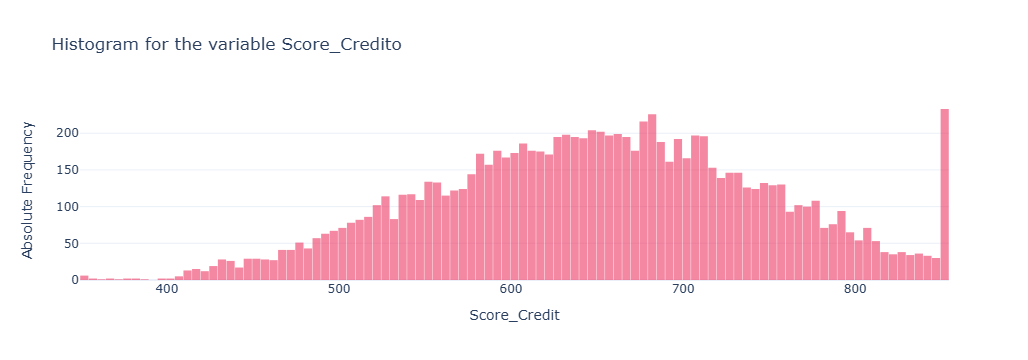

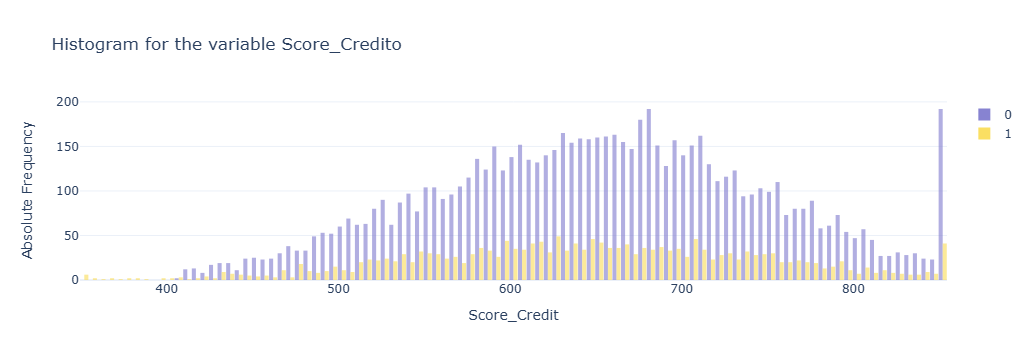

In [ ]:
# Creating a Density plot for the specified variable.
plotDensity(
    data = df[col], 
    title = 'Density Plot for the variable ' + col, 
    xaxis = label
)

# Creating a Density plot for the specified variable, grouped by another variable.
plotDensity(
    data = df[[col, target]], 
    title = 'Density Plot for the variable ' + col, 
    xaxis = label,
    col = col,
    target = target,
    group = True
)


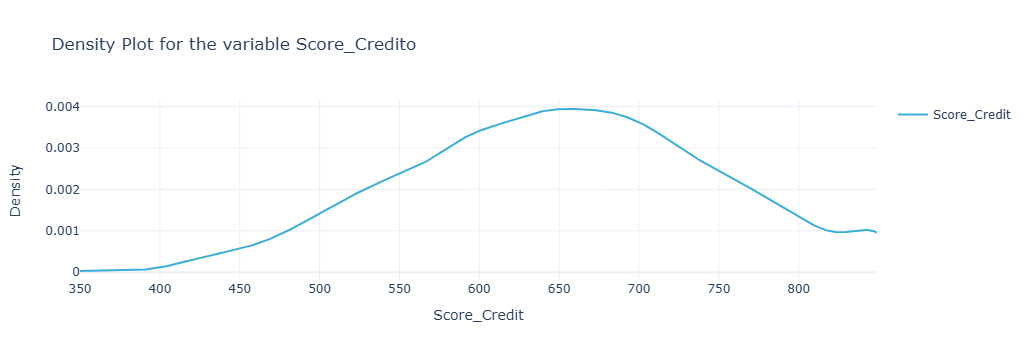

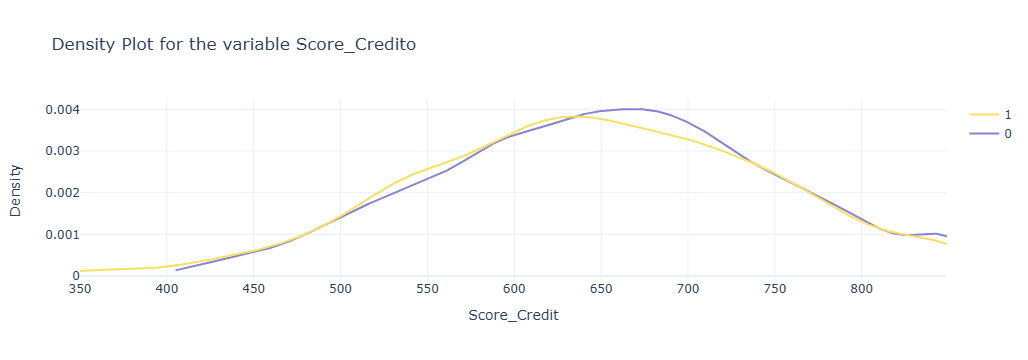

In [38]:
varStats('Score_Credito', df)

count      mean        std    min    25%    50%    75%  \
Score_Credito  10000.0  650.5288  96.653299  350.0  584.0  652.0  718.0   

                 max  Skewness  Kurtosis  
Score_Credito  850.0 -0.071607 -0.425726

In [39]:
varStats('Score_Credito', df,'churn')

Score_Credito                                                      \
              count        mean         std    min    25%    50%    75%   
churn                                                                     
0            7987.0  651.932766   95.739184  405.0  585.0  654.0  718.0   
1            2013.0  644.958271  100.028437  350.0  578.0  646.0  715.0   

              Skewness  Kurtosis  
         max                      
churn                             
0      850.0 -0.048113 -0.484202  
1      850.0 -0.139591 -0.272842

Please note that:

The averages of the two groups are close to each other. 
The asymmetry coefficient (Sk) for the group that did NOT give Churn is approximately symmetric. In the group of positive churn the asymmetry is more pronounced, where the tail on the left side is larger than the tail on the right side.
The kurtosis coefficient (Ck) shows that the tail is lighter than normal for both groups, that is, we have a platuric kurtosis.

In [ ]:
# Plotting a boxplot for the specified variable.
plotBoxplot(
    data = df[[col]],
    title = 'Boxplot for the variable ' + col,
    xaxis = 'Variable',
    name = label
)

# Plotting a boxplot for the specified variable, grouped by another variable.
plotBoxplot(
    data = df[[col, target]],
    title = 'Boxplot for the variable ' + col,
    yaxis = label,
    xaxis = target.capitalize(),
    col = col,
    target = target,
    kind = 'groups'
)


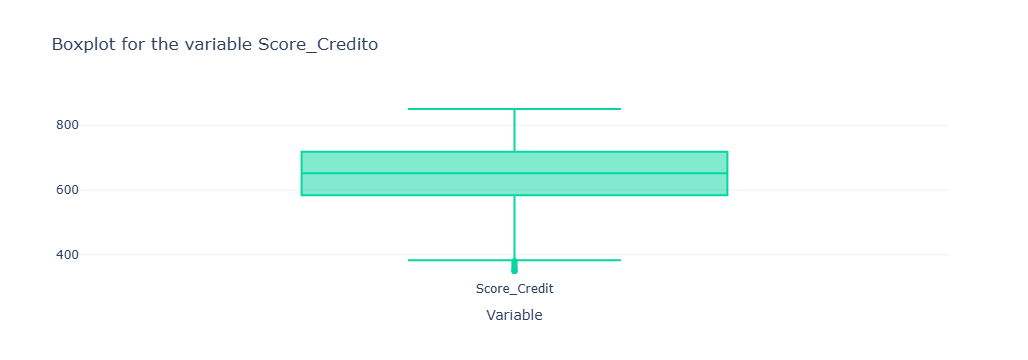

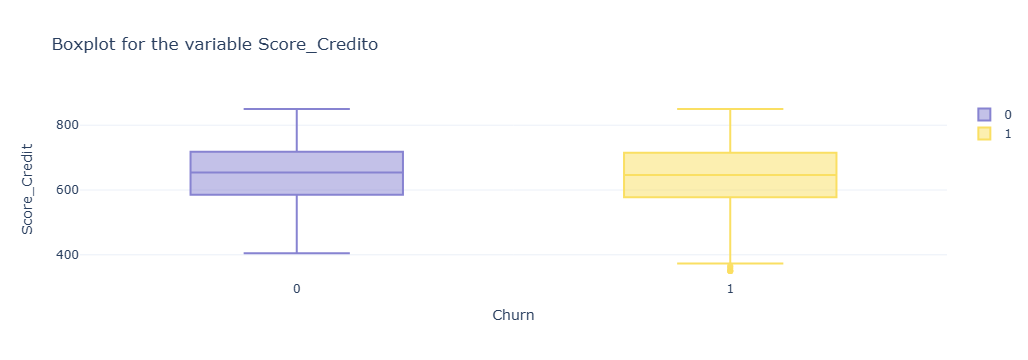

There are some outliers at the lower limit among the positive churn customers, which means that the score credits in some observations is much lower than the other observations.


### State

In [ ]:
# Defining the name of the variable to be analyzed.
col = 'Estado'

# Defining the description of the variable in the graphs.
label = 'Estado'

# Counting the absolute frequency of each category present in the specified variable.
dataCounts = df[col].value_counts()

# Plotting a bar chart for the specified variable.
plotBar(
    data = dataCounts,
    title = 'Absolute frequency of categories for Feature ' + col,
    yaxis = 'Absolute Frequency',
    xaxis = label,
    orientation = 'h'
)

#---------------------------------------------------
target = 'churn'

# Capturing specified variables from the Dataset.
data = df[[col, target]]

# Creating a 'count' variable to count the occurrences of each record.
data['count'] = 1

# Grouping data and counting the number of occurrences.
data = data.groupby(by=[target, col]).sum()

# Reorganizing DataFrame.
data = data.reset_index()

# Plotting a bar chart for the specified variable.
plotBar(
    data = data,
    col = col,
    target = target,
    title = 'Churn of customers by ' + label,
    yaxis = 'Absolute Frequency',
    xaxis = label,
    kind = 'groups'
)


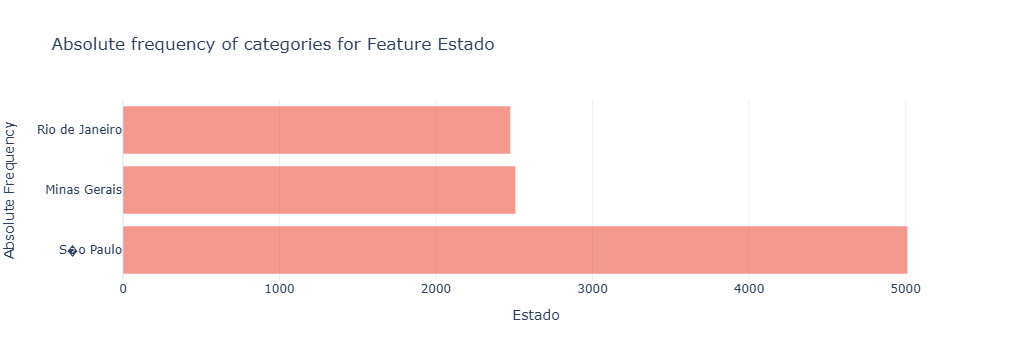

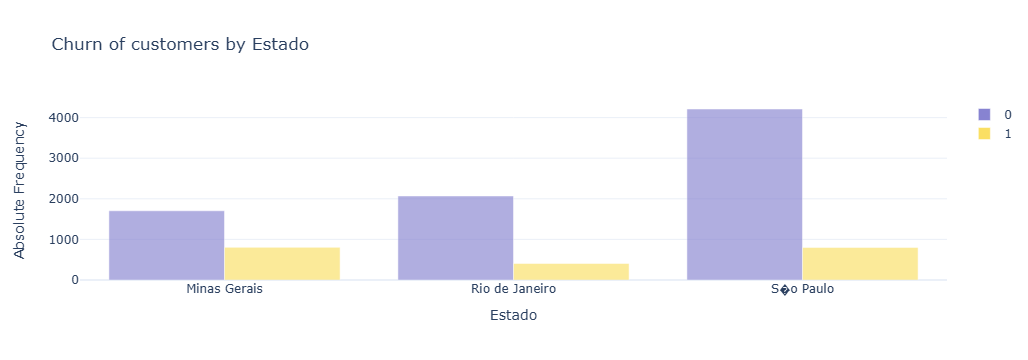

In [ ]:
# Plotting a pie chart for the specified variable.
plotPie(
    data = dataCounts, 
    title = 'Relative frequency of categories for the feature ' + col
)


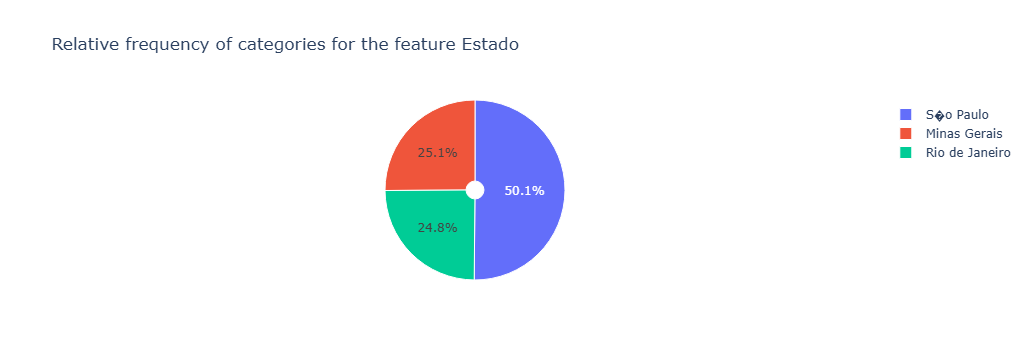


More than 50% of customers comes from the state of São Paulo

### Gender

In [ ]:
# Defining the name of the variable to be analyzed.
col = 'Gênero'

# Defining the description of the variable in the graphs.
label = 'Gênero'

# Counting the absolute frequency of each category present in the specified variable.
dataCounts = df[col].value_counts()

# Plotting a bar chart for the specified variable.
plotBar(
    data = dataCounts,
    title = 'Absolute frequency of categories for Feature ' + col,
    yaxis = 'Absolute Frequency',
    xaxis = label,
    orientation = 'h'
)

#---------------------------------------------------
target = 'churn'

# Capturing specified variables from the Dataset.
data = df[[col, target]]

# Creating a 'count' variable to count the occurrences of each record.
data['count'] = 1

# Grouping data and counting the number of occurrences.
data = data.groupby(by=[target, col]).sum()

# Reorganizing DataFrame.
data = data.reset_index()

# Plotting a bar chart for the specified variable.
plotBar(
    data = data,
    col = col,
    target = target,
    title = 'Churn of customers by ' + label,
    yaxis = 'Absolute Frequency',
    xaxis = label,
    kind = 'groups'
)


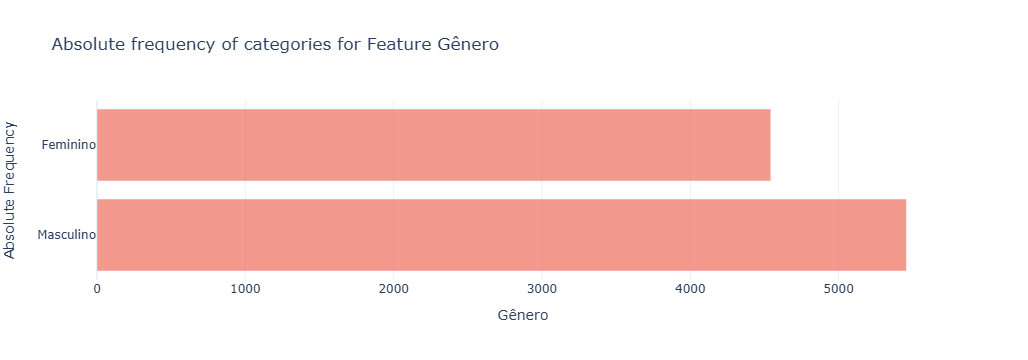

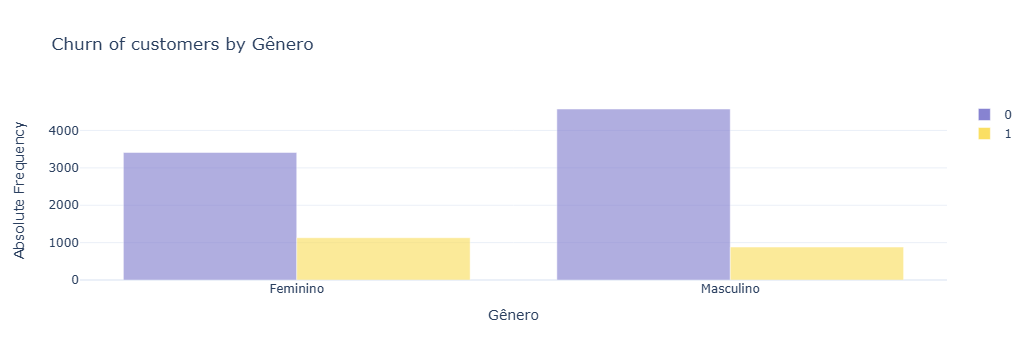

In [ ]:
# Plotting a pie chart for the specified variable.
plotPie(
    data = dataCounts, 
    title = 'Relative frequency of categories for the feature ' + col
)


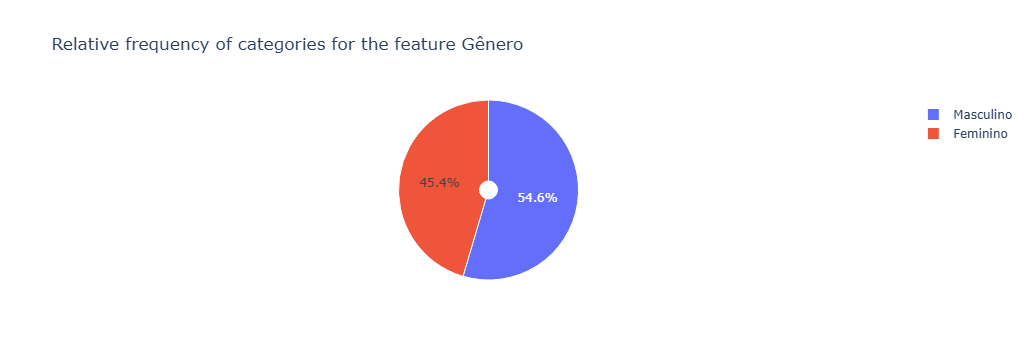

### Age

In [ ]:
# Defining the name of the variable to be analyzed.
col = 'Idade'

# Defining the variable description in the plots.
label = 'Idade'

# Counting the absolute frequency of each category present in the specified variable.
dataCounts = df[col].value_counts()

# Plotting a histogram for the specified variable.
plotHist(
    data = df[col],
    title = 'Histogram for the variable ' + col,
    xaxis = label,
    yaxis = 'Absolute Frequency'
)

# Defining the name of the target variable.
target = 'churn'

# Capturing specified variables from the dataset.
data = df[[col, target]]

# Creating a 'count' variable to count the occurrences of each record.
data['count'] = 1

# Grouping data and counting the number of occurrences.
data = data.groupby(by=[target, col]).sum()

# Reorganizing DataFrame.
data = data.reset_index()

# Plotting a histogram for the specified variable.
plotHist(
    data = df[[col, target]],
    title = 'Histogram for the variable ' + col,
    xaxis = label,
    yaxis = 'Absolute Frequency',
    col = col,
    target = target,
    groups = True
)


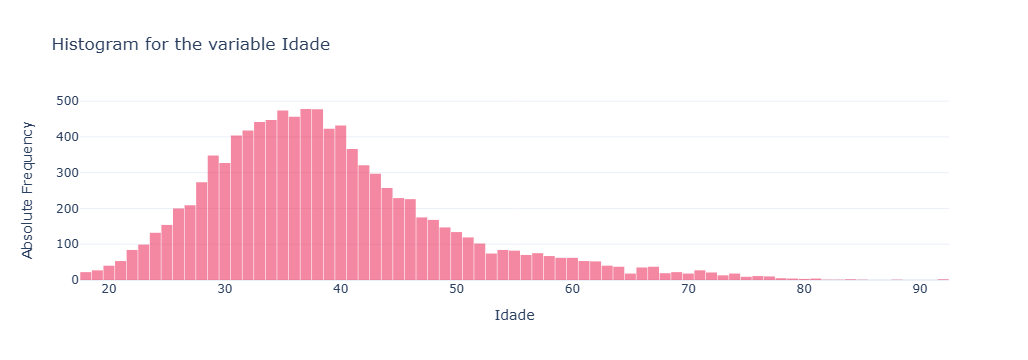

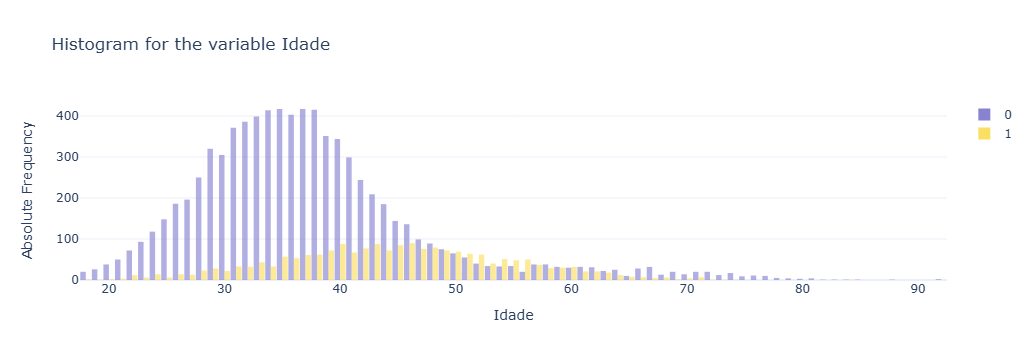


The distribution approaches a normal curve, slightly offset to the left

In [ ]:
# Creating a Density plot for the specified variable.
plotDensity(
    data = df[col], 
    title = 'Density Plot for the variable ' + col, 
    xaxis = label
)

# Creating a Density plot for the specified variable, grouped by another variable.
plotDensity(
    data = df[[col, target]], 
    title = 'Density Plot for the variable ' + col, 
    xaxis = label,
    col = col,
    target = target,
    group = True
)


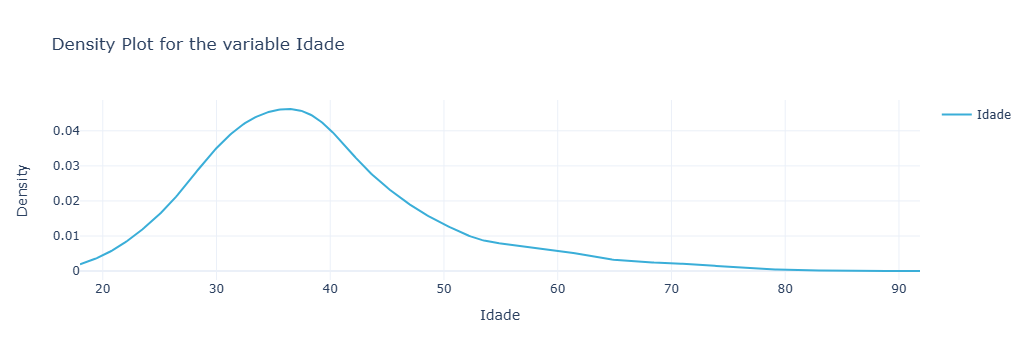

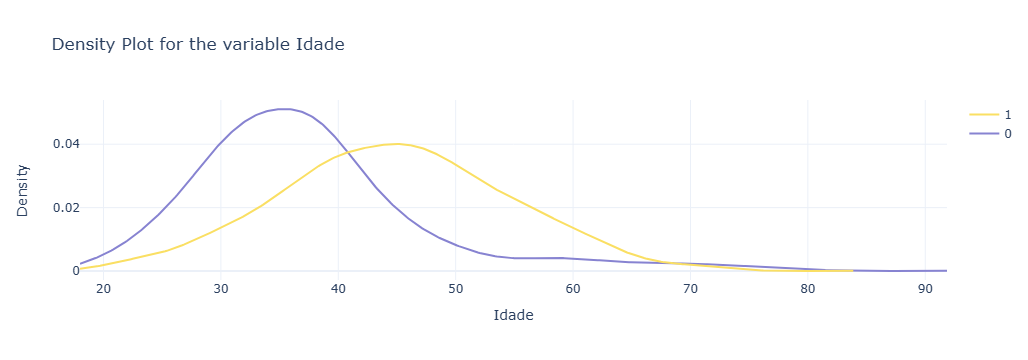

In [47]:
varStats('Idade', df)

count     mean        std   min   25%   50%   75%   max  Skewness  \
Idade  10000.0  38.9218  10.487806  18.0  32.0  37.0  44.0  92.0   1.01132   

       Kurtosis  
Idade  1.395347

In [48]:
varStats('Idade', df,'churn')

Idade                                                      Skewness  \
        count       mean        std   min   25%   50%   75%   max             
churn                                                                         
0      7987.0  37.430575  10.125572  18.0  31.0  36.0  41.0  92.0  1.370577   
1      2013.0  44.838549   9.789447  18.0  38.0  45.0  51.0  84.0  0.081081   

       Kurtosis  
                 
churn            
0      2.823004  
1     -0.132340


We highlight that:

The mean between the two groups is different.
The skewness coefficient (Sk) among customers who did NOT churn is positive, indicating left skewness, meaning the tail on the right side is larger than the left side. While in the group that churned, the curve is approximately symmetric.
The kurtosis coefficient (Ck) in the group that did NOT churn is positive, indicating leptokurtic kurtosis, where the tail is heavier than normal. In this case, we have leptokurtosis. In the group that churned, the kurtosis is slightly negative, meaning the tail is lighter than normal, so the kurtosis is platykurtic.


In [ ]:
# Plotting a boxplot for the specified variable.
plotBoxplot(
    data = df[[col]],
    title = 'Boxplot for the variable ' + col,
    xaxis = 'Variable',
    name = label
)

# Plotting a boxplot for the specified variable, grouped by another variable.
plotBoxplot(
    data = df[[col, target]],
    title = 'Boxplot for the variable ' + col,
    yaxis = label,
    xaxis = target.capitalize(),
    col = col,
    target = target,
    kind = 'groups'
)


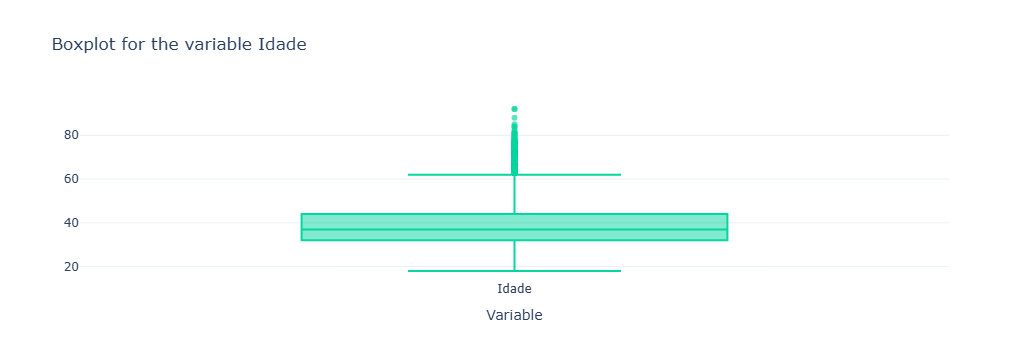

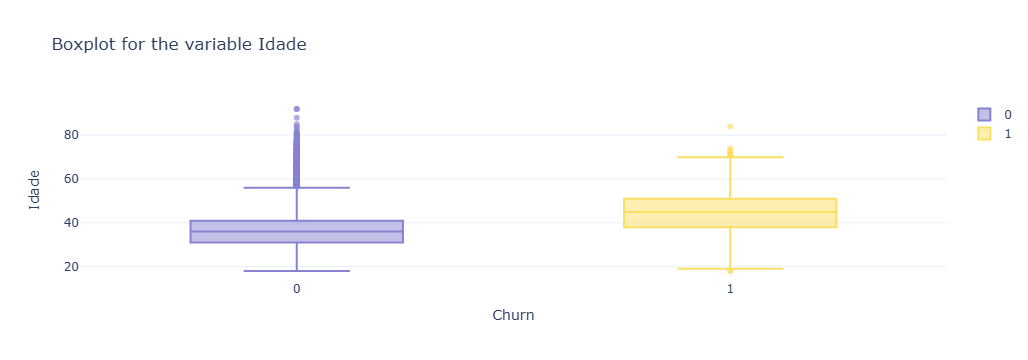


There are many outliers at the upper limit, meaning there are customers who have a much higher age compared to the rest.

### Tempo_Cliente

In [ ]:
# Defining the name of the variable to be analyzed.
col = 'Tempo_Cliente'

# Defining the description of the variable in the graphs.
label = 'Tempo_Cliente'

# Counting the absolute frequency of each category present in the specified variable.
dataCounts = df[col].value_counts()

# Plotting a bar chart for the specified variable.
plotBar(
    data = dataCounts,
    title = 'Absolute frequency of categories for Feature ' + col,
    yaxis = 'Absolute Frequency',
    xaxis = label,
    orientation = 'h'
)

#---------------------------------------------------
target = 'churn'

# Capturing specified variables from the Dataset.
data = df[[col, target]]

# Creating a 'count' variable to count the occurrences of each record.
data['count'] = 1

# Grouping data and counting the number of occurrences.
data = data.groupby(by=[target, col]).sum()

# Reorganizing DataFrame.
data = data.reset_index()

# Plotting a bar chart for the specified variable.
plotBar(
    data = data,
    col = col,
    target = target,
    title = 'Churn of customers by ' + label,
    yaxis = 'Absolute Frequency',
    xaxis = label,
    kind = 'groups'
)


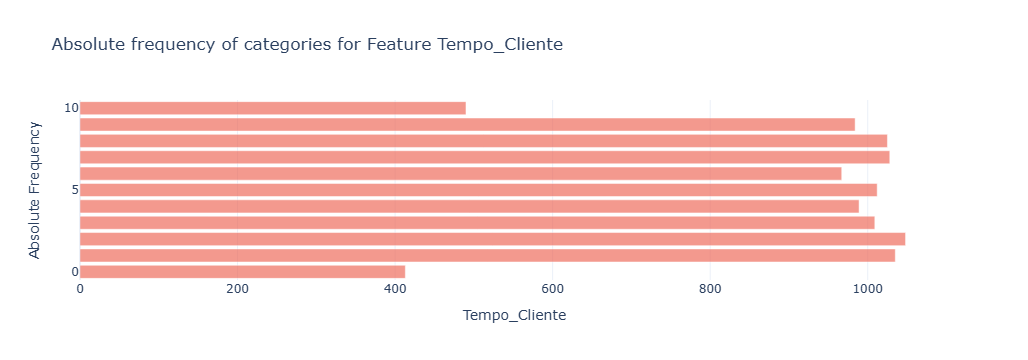

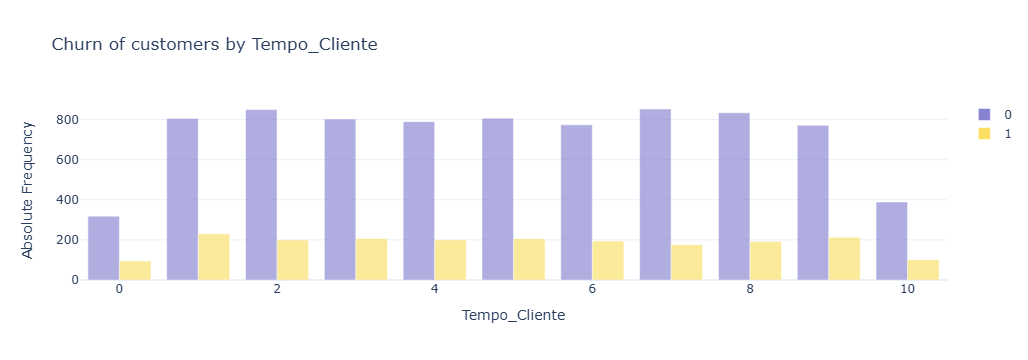

The distribution is uniform

In [ ]:
# Creating a Density plot for the specified variable.
plotDensity(
    data = df[col], 
    title = 'Density Plot for the variable ' + col, 
    xaxis = label
)

# Creating a Density plot for the specified variable, grouped by another variable.
plotDensity(
    data = df[[col, target]], 
    title = 'Density Plot for the variable ' + col, 
    xaxis = label,
    col = col,
    target = target,
    group = True
)


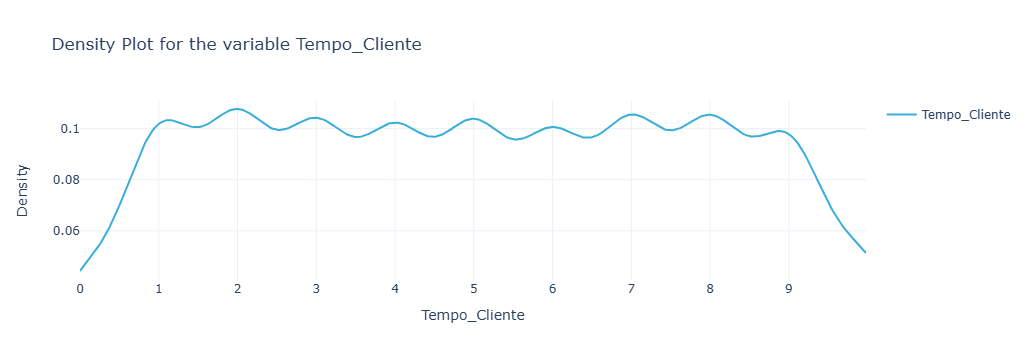

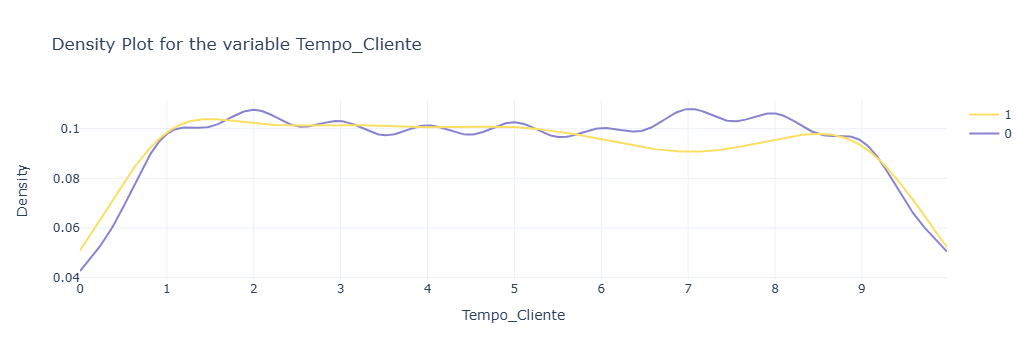

In [52]:
varStats('Tempo_Cliente', df)

count    mean       std  min  25%  50%  75%   max  Skewness  \
Tempo_Cliente  10000.0  5.0128  2.892174  0.0  3.0  5.0  7.0  10.0  0.010991   

               Kurtosis  
Tempo_Cliente -1.165225

We highlight that:

The mean and the median have close values.
The skewness coefficient (Sk) confirms that the data is approximately symmetric.
The kurtosis coefficient (Ck) indicates that the tail is lighter than normal, meaning we have a platykurtic kurtosis.

In [ ]:
# Plotting a boxplot for the specified variable.
plotBoxplot(
    data = df[[col]],
    title = 'Boxplot for the variable ' + col,
    xaxis = 'Variable',
    name = label
)

# Plotting a boxplot for the specified variable, grouped by another variable.
plotBoxplot(
    data = df[[col, target]],
    title = 'Boxplot for the variable ' + col,
    yaxis = label,
    xaxis = target.capitalize(),
    col = col,
    target = target,
    kind = 'groups'
)


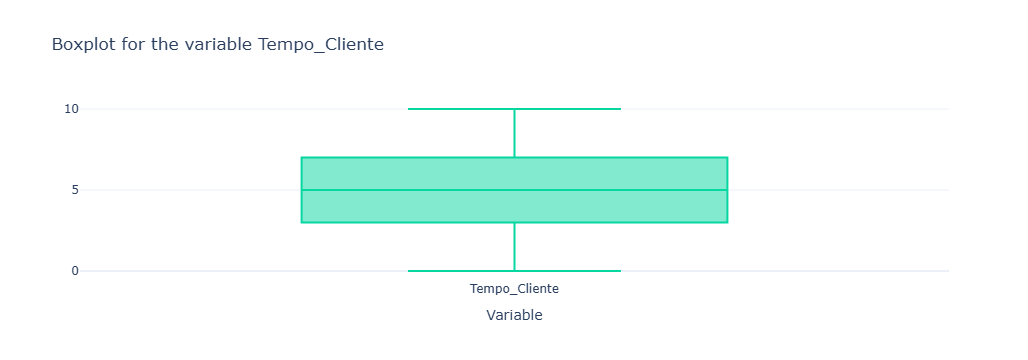

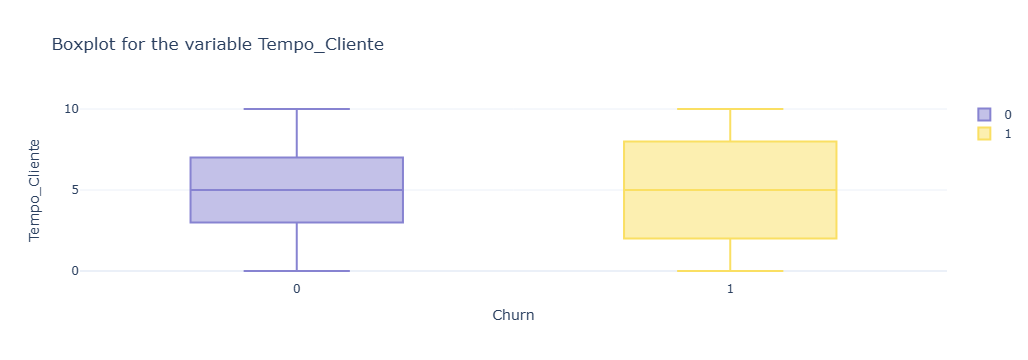

### Credit limit in the market

In [ ]:
# Defining the name of the variable to be analyzed.
col = 'limite_credito_mercado'

# Defining the variable description in the plots.
label = 'limite_credito_mercado'

# Counting the absolute frequency of each category present in the specified variable.
dataCounts = df[col].value_counts()

# Plotting a histogram for the specified variable.
plotHist(
    data = df[col],
    title = 'Histogram for the variable ' + col,
    xaxis = label,
    yaxis = 'Absolute Frequency'
)

# Defining the name of the target variable.
target = 'churn'

# Capturing specified variables from the dataset.
data = df[[col, target]]

# Creating a 'count' variable to count the occurrences of each record.
data['count'] = 1

# Grouping data and counting the number of occurrences.
data = data.groupby(by=[target, col]).sum()

# Reorganizing DataFrame.
data = data.reset_index()

# Plotting a histogram for the specified variable.
plotHist(
    data = df[[col, target]],
    title = 'Histogram for the variable ' + col,
    xaxis = label,
    yaxis = 'Absolute Frequency',
    col = col,
    target = target,
    groups = True
)


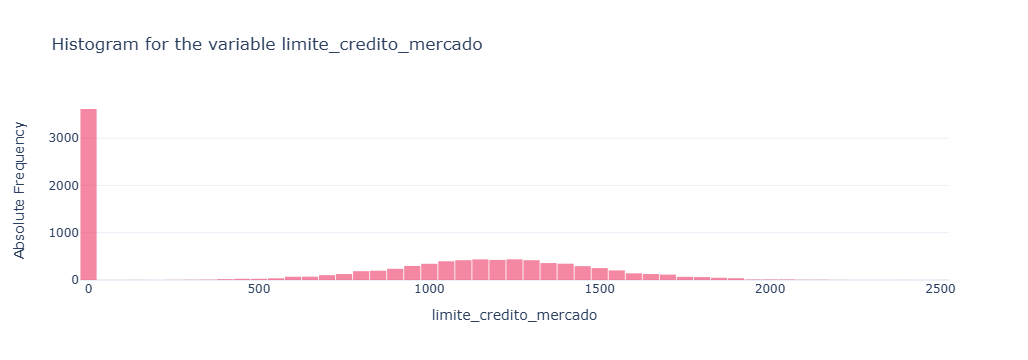

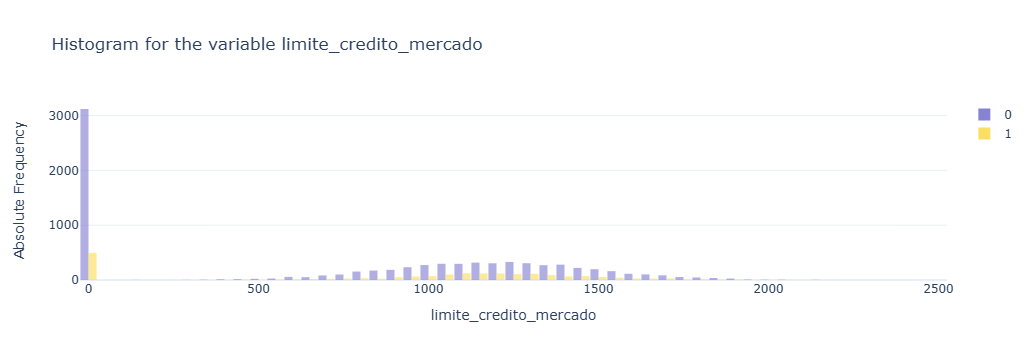

Distribution approaches the normal

In [ ]:
# Creating a Density plot for the specified variable.
plotDensity(
    data = df[col], 
    title = 'Density Plot for the variable ' + col, 
    xaxis = label
)

# Creating a Density plot for the specified variable, grouped by another variable.
plotDensity(
    data = df[[col, target]], 
    title = 'Density Plot for the variable ' + col, 
    xaxis = label,
    col = col,
    target = target,
    group = True
)


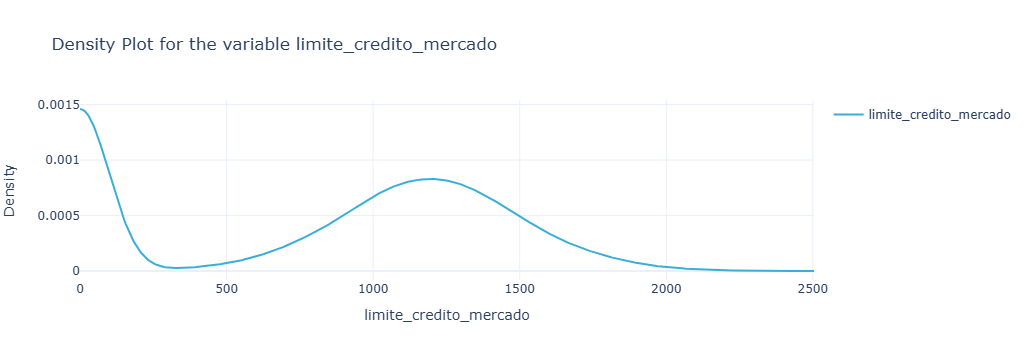

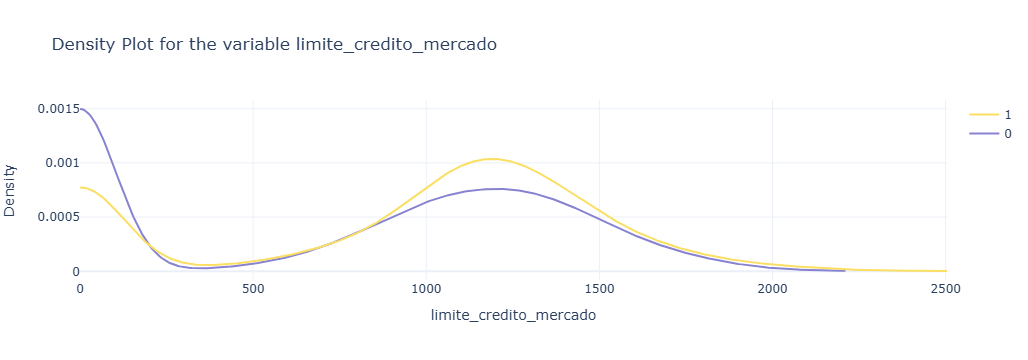

In [56]:
varStats('Score_Credito', df)

count      mean        std    min    25%    50%    75%  \
Score_Credito  10000.0  650.5288  96.653299  350.0  584.0  652.0  718.0   

                 max  Skewness  Kurtosis  
Score_Credito  850.0 -0.071607 -0.425726

In [57]:
varStats('Score_Credito', df,'churn')

Score_Credito                                                      \
              count        mean         std    min    25%    50%    75%   
churn                                                                     
0            7987.0  651.932766   95.739184  405.0  585.0  654.0  718.0   
1            2013.0  644.958271  100.028437  350.0  578.0  646.0  715.0   

              Skewness  Kurtosis  
         max                      
churn                             
0      850.0 -0.048113 -0.484202  
1      850.0 -0.139591 -0.272842

We highlight that:

The mean and the median are distant due to the concentration of data with a value of 'zero'.
The distribution is bimodal.
The skewness coefficient (Sk) among customers who DID NOT churn is approximately symmetric. In the group that churned, it is slightly skewed to the left, meaning the tail on the left side is larger than the right side.
The kurtosis coefficient (Ck) in both groups is negative, meaning we have a platykurtic kurtosis.

In [ ]:
# Plotting a boxplot for the specified variable.
plotBoxplot(
    data = df[[col]],
    title = 'Boxplot for the variable ' + col,
    xaxis = 'Variable',
    name = label
)

# Plotting a boxplot for the specified variable, grouped by another variable.
plotBoxplot(
    data = df[[col, target]],
    title = 'Boxplot for the variable ' + col,
    yaxis = label,
    xaxis = target.capitalize(),
    col = col,
    target = target,
    kind = 'groups'
)


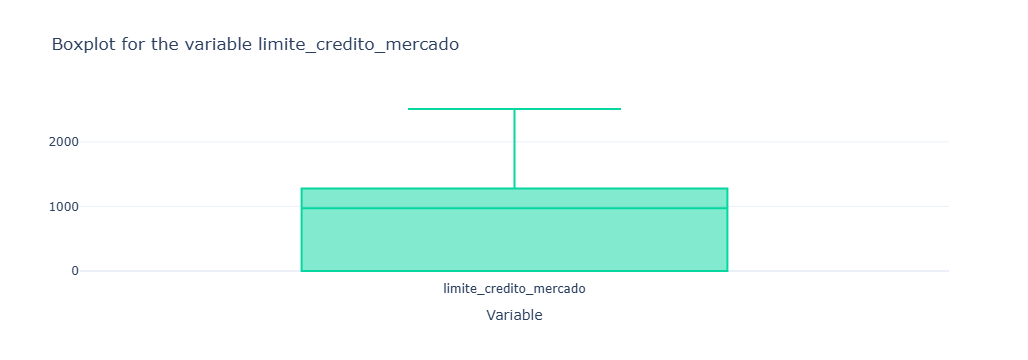

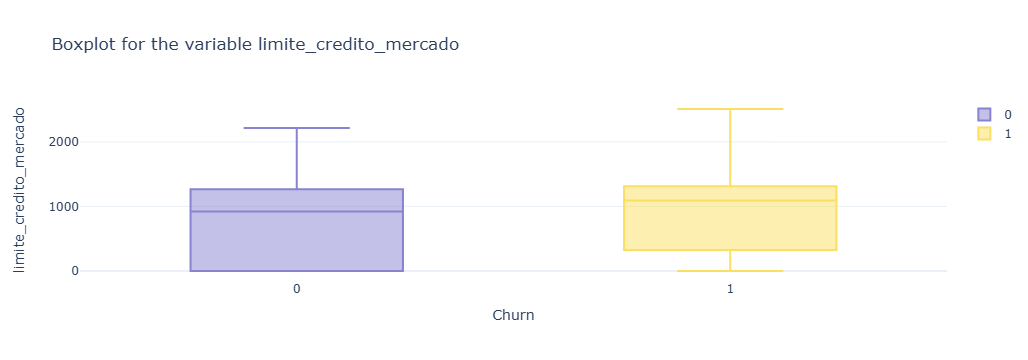

### Number of categories

In [ ]:
# Defining the name of the variable to be analyzed.
col = 'Qte_Categorias'

# Defining the description of the variable in the graphs.
label = 'Qte_Categorias'

# Counting the absolute frequency of each category present in the specified variable.
dataCounts = df[col].value_counts()

# Plotting a bar chart for the specified variable.
plotBar(
    data = dataCounts,
    title = 'Absolute frequency of categories for Feature ' + col,
    yaxis = 'Absolute Frequency',
    xaxis = label,
    orientation = 'h'
)

#---------------------------------------------------
target = 'churn'

# Capturing specified variables from the Dataset.
data = df[[col, target]]

# Creating a 'count' variable to count the occurrences of each record.
data['count'] = 1

# Grouping data and counting the number of occurrences.
data = data.groupby(by=[target, col]).sum()

# Reorganizing DataFrame.
data = data.reset_index()

# Plotting a bar chart for the specified variable.
plotBar(
    data = data,
    col = col,
    target = target,
    title = 'Churn of customers by ' + label,
    yaxis = 'Absolute Frequency',
    xaxis = label,
    kind = 'groups'
)


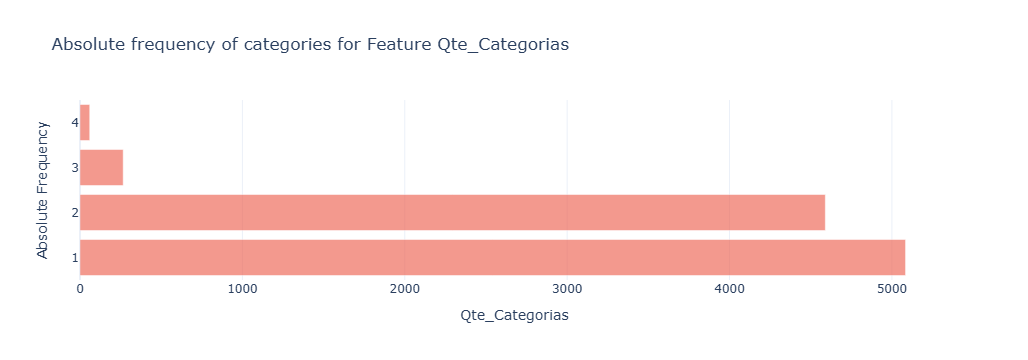

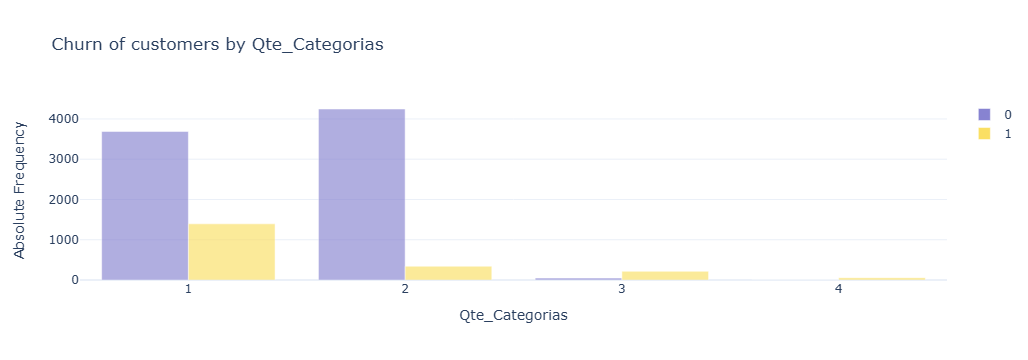

In [ ]:
# Plotting a pie chart for the specified variable.
dataCounts.index= dataCounts.index.astype('str')
dataCounts.index

plotPie(
    data = dataCounts, 
    title = 'Relative frequency of categories for the feature ' + col
)


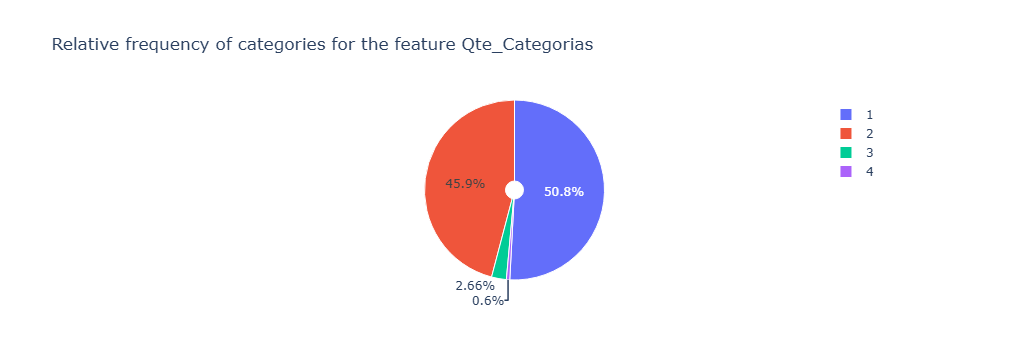

### Credit card user

In [ ]:
# Defining the name of the variable to be analyzed.
col = 'Usa_Cartao_Credito'

# Defining the description of the variable in the graphs.
label = 'Usa_Cartao_Credito'

# Counting the absolute frequency of each category present in the specified variable.
dataCounts = df[col].value_counts()

# Plotting a bar chart for the specified variable.
plotBar(
    data = dataCounts,
    title = 'Absolute frequency of categories for Feature ' + col,
    yaxis = 'Absolute Frequency',
    xaxis = label,
    orientation = 'h'
)

#---------------------------------------------------
target = 'churn'

# Capturing specified variables from the Dataset.
data = df[[col, target]]

# Creating a 'count' variable to count the occurrences of each record.
data['count'] = 1

# Grouping data and counting the number of occurrences.
data = data.groupby(by=[target, col]).sum()

# Reorganizing DataFrame.
data = data.reset_index()

# Plotting a bar chart for the specified variable.
plotBar(
    data = data,
    col = col,
    target = target,
    title = 'Churn of customers by ' + label,
    yaxis = 'Absolute Frequency',
    xaxis = label,
    kind = 'groups'
)


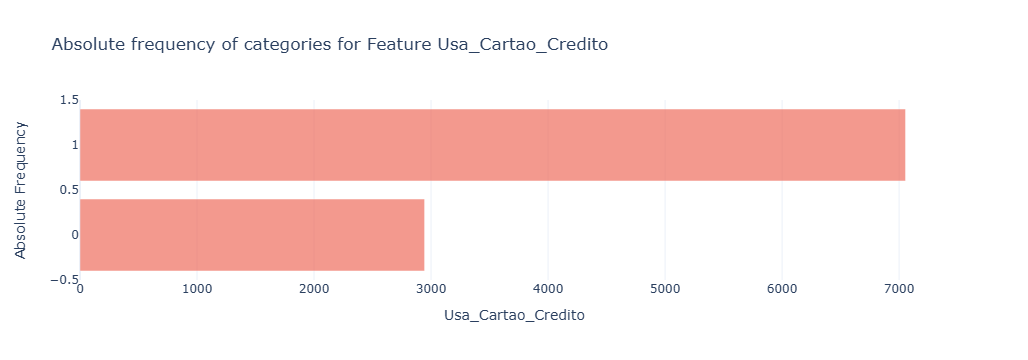

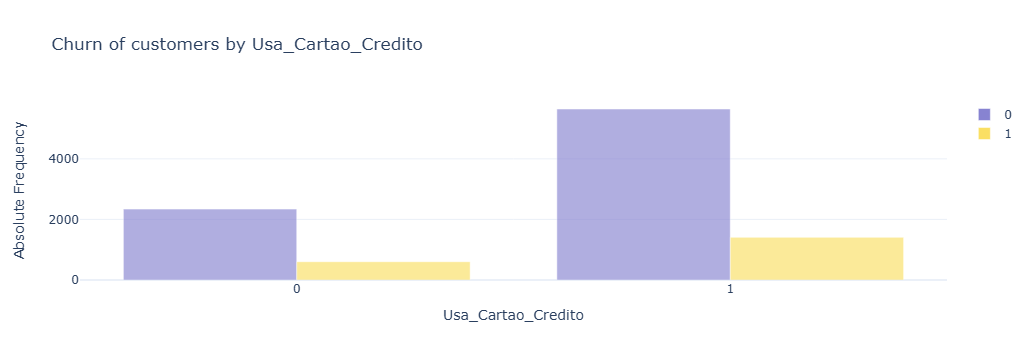

In [ ]:
# Plotando um gráfico de pizza para a variável especificada.
dataCounts.index= dataCounts.index.astype('str')

dataCounts.index

plotPie (
    data  = dataCounts, 
    title = 'Frequência relativa das categorias da feature ' + col
)

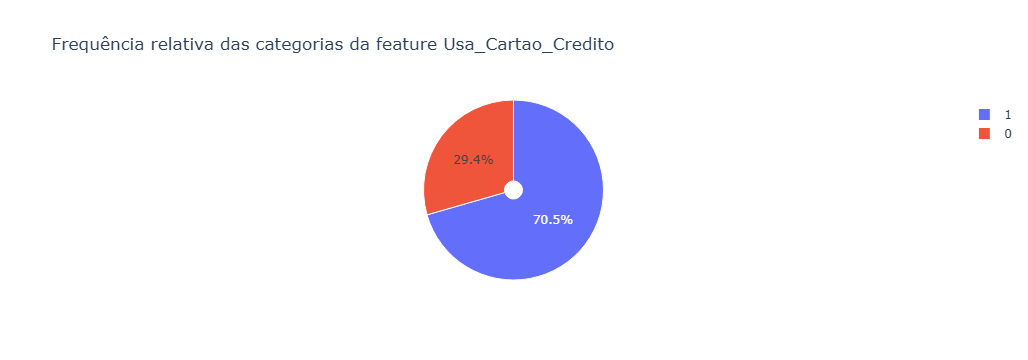

### Programa_Fidelidade

In [ ]:
# Defining the name of the variable to be analyzed.
col = 'Programa_Fidelidade'

# Defining the description of the variable in the graphs.
label = 'Programa_Fidelidade'

# Counting the absolute frequency of each category present in the specified variable.
dataCounts = df[col].value_counts()

# Plotting a bar chart for the specified variable.
plotBar(
    data = dataCounts,
    title = 'Absolute frequency of categories for Feature ' + col,
    yaxis = 'Absolute Frequency',
    xaxis = label,
    orientation = 'h'
)

#---------------------------------------------------
target = 'churn'

# Capturing specified variables from the Dataset.
data = df[[col, target]]

# Creating a 'count' variable to count the occurrences of each record.
data['count'] = 1

# Grouping data and counting the number of occurrences.
data = data.groupby(by=[target, col]).sum()

# Reorganizing DataFrame.
data = data.reset_index()

# Plotting a bar chart for the specified variable.
plotBar(
    data = data,
    col = col,
    target = target,
    title = 'Churn of customers by ' + label,
    yaxis = 'Absolute Frequency',
    xaxis = label,
    kind = 'groups'
)


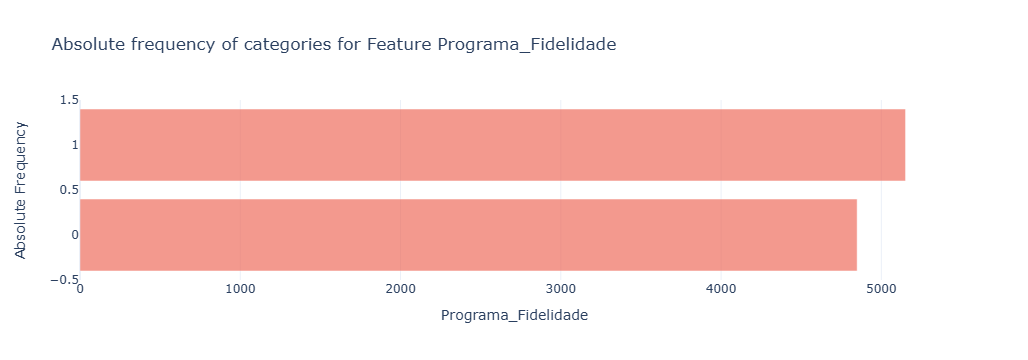

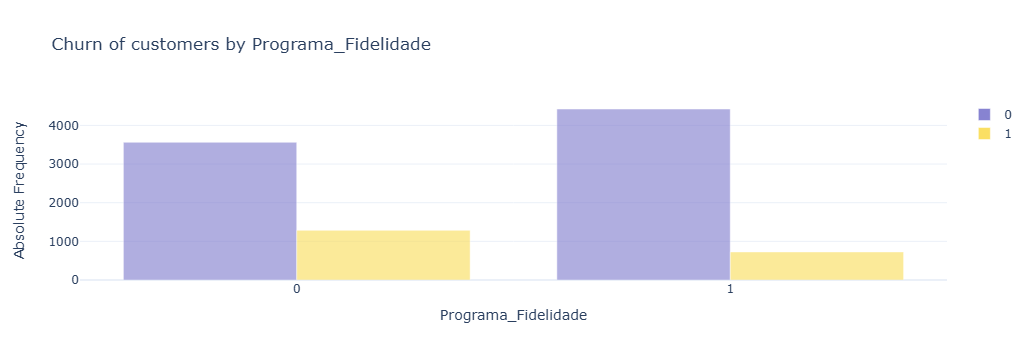

In [ ]:
# Plotting a pie chart for the specified variable.
dataCounts.index= dataCounts.index.astype('str')
dataCounts.index

plotPie(
    data = dataCounts, 
    title = 'Relative frequency of categories for the feature ' + col
)


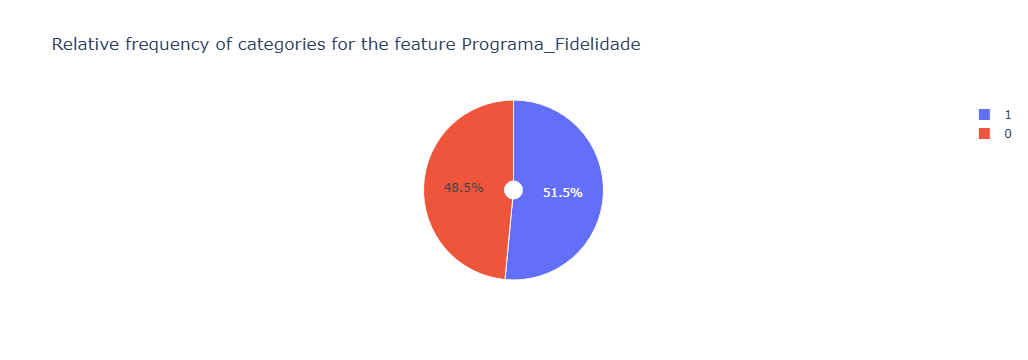

### Sum of acumulated orders

In [ ]:
# Defining the name of the variable to be analyzed.
col = 'sum_pedidos_acumulado'

# Defining the variable description in the plots.
label = 'sum_pedidos_acumulado'

# Counting the absolute frequency of each category present in the specified variable.
dataCounts = df[col].value_counts()

# Plotting a histogram for the specified variable.
plotHist(
    data = df[col],
    title = 'Histogram for the variable ' + col,
    xaxis = label,
    yaxis = 'Absolute Frequency'
)

# Defining the name of the target variable.
target = 'churn'

# Capturing specified variables from the dataset.
data = df[[col, target]]

# Creating a 'count' variable to count the occurrences of each record.
data['count'] = 1

# Grouping data and counting the number of occurrences.
data = data.groupby(by=[target, col]).sum()

# Reorganizing DataFrame.
data = data.reset_index()

# Plotting a histogram for the specified variable.
plotHist(
    data = df[[col, target]],
    title = 'Histogram for the variable ' + col,
    xaxis = label,
    yaxis = 'Absolute Frequency',
    col = col,
    target = target,
    groups = True
)


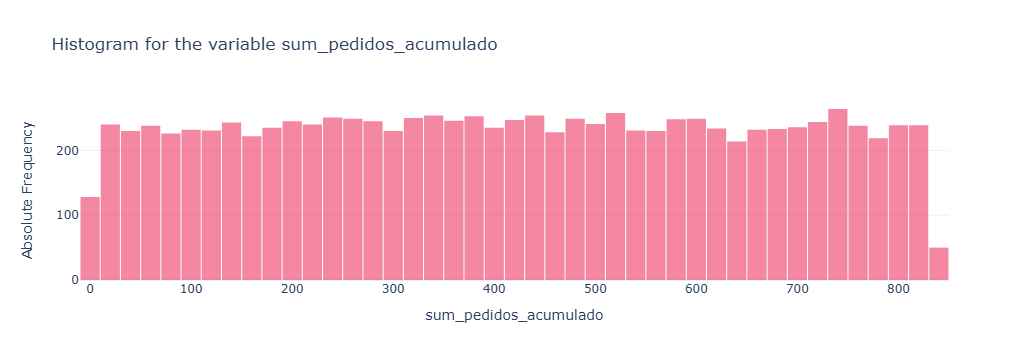

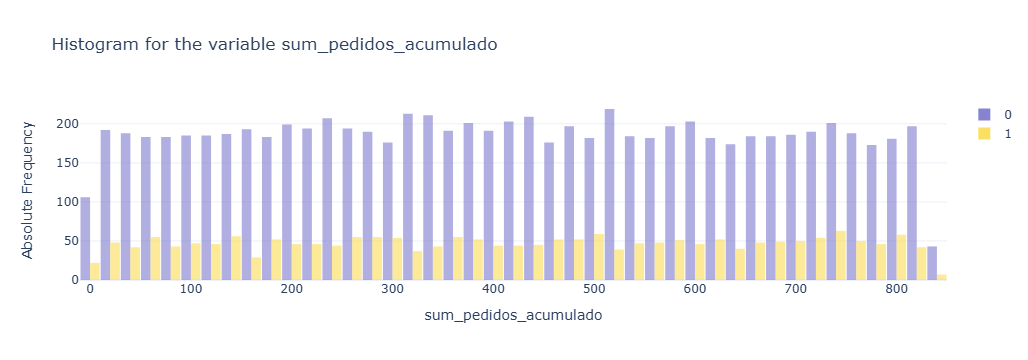

In [ ]:
# Creating a Density plot for the specified variable.
plotDensity(
    data = df[col], 
    title = 'Density Plot for the variable ' + col, 
    xaxis = label
)

# Creating a Density plot for the specified variable, grouped by another variable.
plotDensity(
    data = df[[col, target]], 
    title = 'Density Plot for the variable ' + col, 
    xaxis = label,
    col = col,
    target = target,
    group = True
)


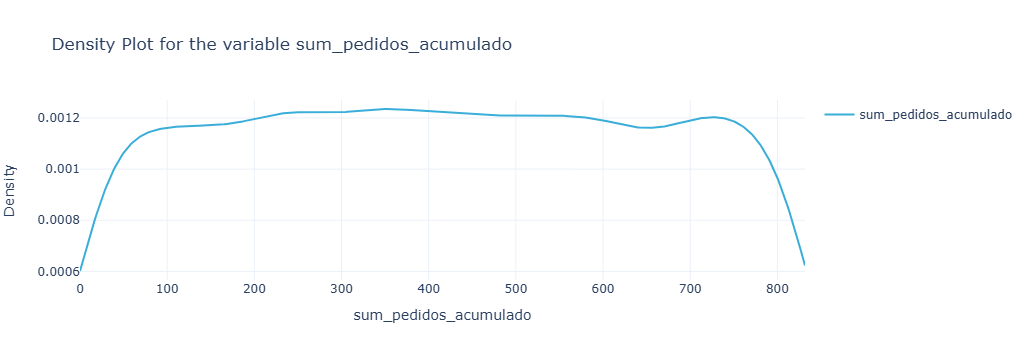

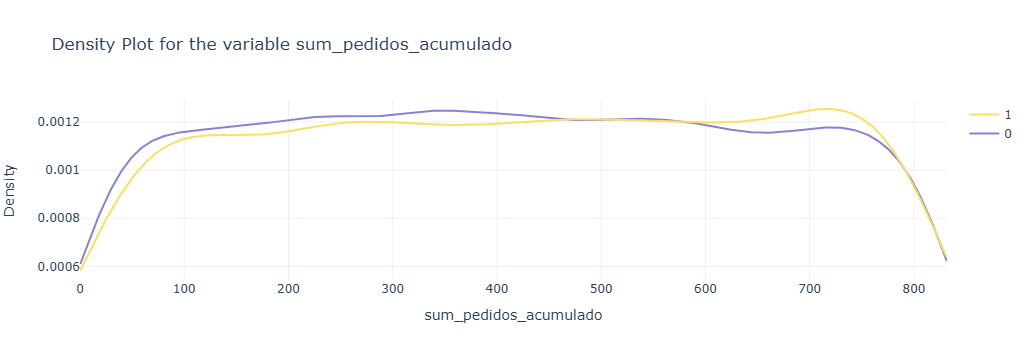

In [67]:
varStats('sum_pedidos_acumulado', df)

count        mean        std   min     25%      50%  \
sum_pedidos_acumulado  10000.0  417.042754  239.62705  0.05  212.51  417.475   

                           75%    max  Skewness  Kurtosis  
sum_pedidos_acumulado  622.455  833.3  0.002085 -1.181518

In [68]:
varStats('sum_pedidos_acumulado', df,'churn')

sum_pedidos_acumulado                                                \
                      count        mean         std   min     25%     50%   
churn                                                                       
0                    7987.0  415.575434  239.322771  0.38  211.56  415.19   
1                    2013.0  422.864655  240.802101  0.05  216.58  426.92   

                       Skewness  Kurtosis  
          75%     max                      
churn                                      
0      619.62  833.30  0.010719 -1.174885  
1      633.78  832.53 -0.032452 -1.205056

Please note that:

The average between groups is approximately equal. 
The asymmetry coefficient (Sk) confirms that the data are approximately symmetrical;
The kurtosis coefficient (Ck) evidence that the syrup is lighter than normal, that is, we have a platituric kurtosis.

In [ ]:
# Plotting a boxplot for the specified variable.
plotBoxplot(
    data = df[[col]],
    title = 'Boxplot for the variable ' + col,
    xaxis = 'Variable',
    name = label
)

# Plotting a boxplot for the specified variable, grouped by another variable.
plotBoxplot(
    data = df[[col, target]],
    title = 'Boxplot for the variable ' + col,
    yaxis = label,
    xaxis = target.capitalize(),
    col = col,
    target = target,
    kind = 'groups'
)


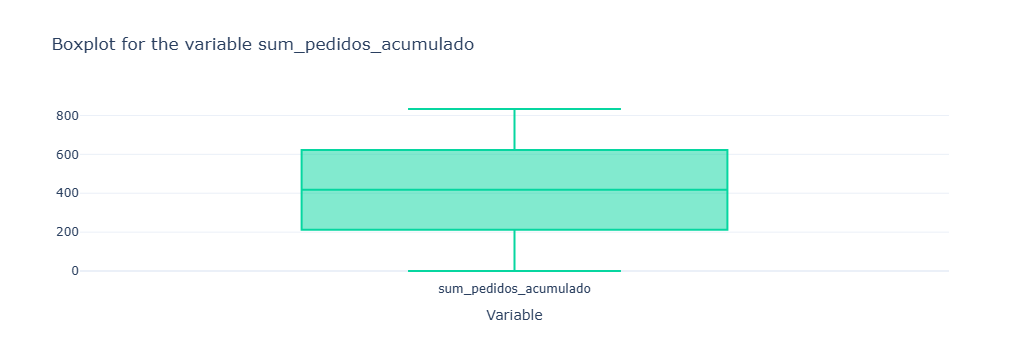

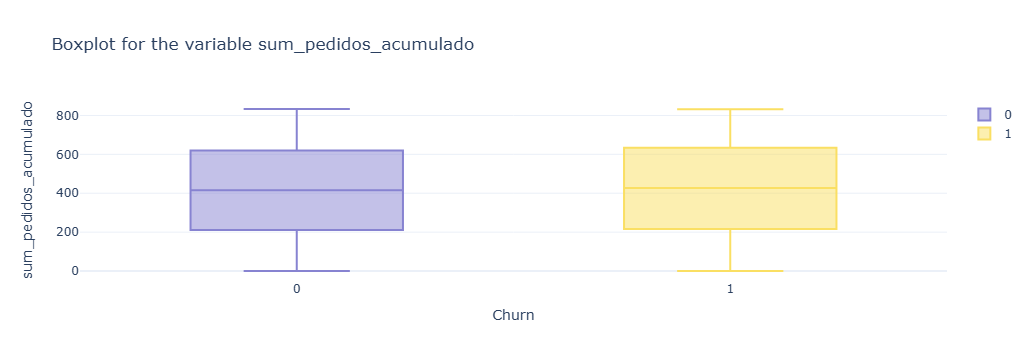

### Date of the last order

In [ ]:
plotDistribution_rel(df['Mês_UltimaTransacao'].value_counts(), title='Month Distribution', yaxis='Frequency', xaxis='Month')

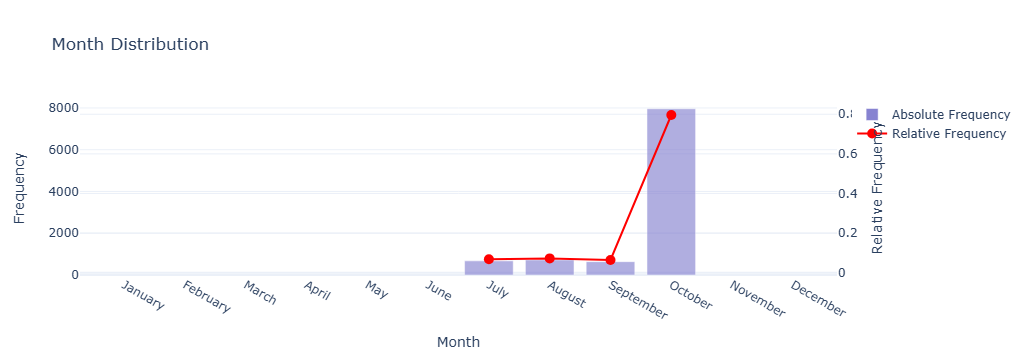

Mais de 80% dos clientes desta base de dados realizaram sua última transação no mês de Outubro

### Churn

In [ ]:
# Defining the name of the variable to be analyzed.
col = 'churn'

# Defining the description of the variable in the graphs.
label = 'churn'

# Counting the absolute frequency of each category present in the specified variable.
dataCounts = df[col].value_counts()

# Plotting a bar graph for the specified variable.
plotBar (
    data  = dataCounts,
    title = 'Absolute frequency of categories in the Feature ' + col, 
    yaxis = 'Absolute Frequency', 
    xaxis = label,
    orientation = 'h'
)


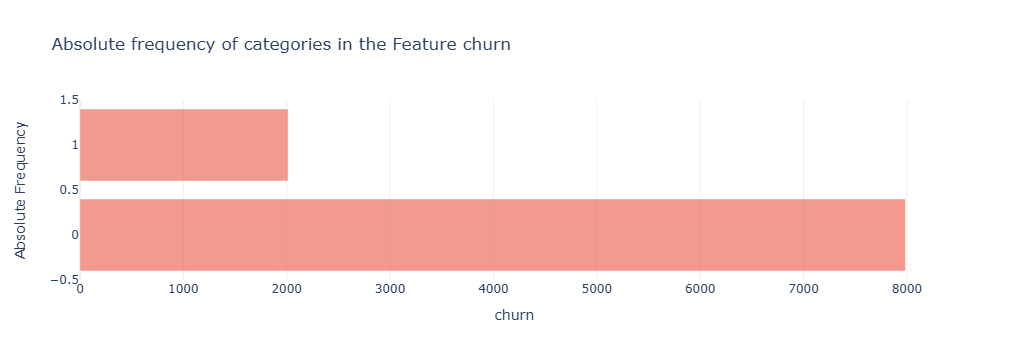

In [ ]:
# Plotting a pie chart for the specified variable.
dataCounts.index= dataCounts.index.astype('str')
dataCounts.index

plotPie(
    data = dataCounts, 
    title = 'Relative frequency of categories for the feature ' + col
)

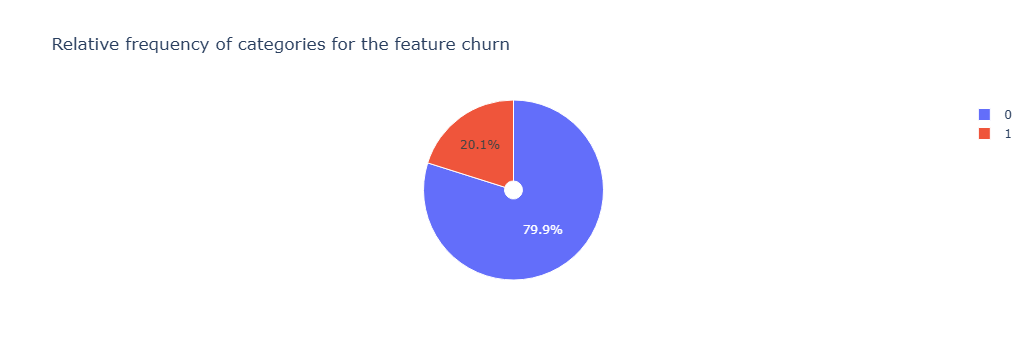

# Analyzing the correlation between the features


## Assigning numerical codes to the category type features

In [73]:
df_aux = df.copy()

In [74]:
var_cat_name = df_aux.select_dtypes(include=['category']).columns
for i in range(0, len(var_cat_name)):
        df_aux[var_cat_name[i]] = df_aux[var_cat_name[i]].cat.codes


In [75]:
df_aux

ClientId DataExtracao  Score_Credito  Estado  Gênero  Idade  \
0            0   2019-06-30            619       2       0     42   
1            1   2019-06-30            608       1       0     41   
2            2   2019-06-30            502       2       0     42   
3            3   2019-06-30            699       2       0     39   
4            4   2019-06-30            850       1       0     43   
...        ...          ...            ...     ...     ...    ...   
9995      9995   2019-06-30            771       2       1     39   
9996      9996   2019-06-30            516       2       1     35   
9997      9997   2019-06-30            709       2       0     36   
9998      9998   2019-06-30            772       0       1     42   
9999      9999   2019-06-30            792       2       0     28   

      Tempo_Cliente  limite_credito_mercado  Qte_Categorias  \
0                 2                    0.00               0   
1                 1                  838.08               0   
2                 8                 1596.61               2   
3                 1                    0.00               1   
4                 2                 1255.11               0   
...             ...                     ...             ...   
9995              5                    0.00               1   
9996             10                  573.70               0   
9997              7                    0.00               0   
9998              3                  750.75               1   
9999              4                 1301.43               0   

      Usa_Cartao_Credito  Programa_Fidelidade  sum_pedidos_acumulado  \
0                      1                    1                 422.29   
1                      0                    1                 468.93   
2                      1                    0                 474.71   
3                      0                    0                 390.94   
4                      1                    1                 329.52   
...                  ...                  ...                    ...   
9995                   1                    0                 401.13   
9996                   1                    1                 423.75   
9997                   0                    1                 175.36   
9998                   1                    0                 387.04   
9999                   1                    0                 159.13   

     DataUltimaTransacao  churn  Mês_UltimaTransacao  
0             2019-09-14      1                    3  
1             2019-10-05      0                    2  
2             2019-08-20      1                    0  
3             2019-10-21      0                    2  
4             2019-10-26      0                    2  
...                  ...    ...                  ...  
9995          2019-10-05      0                    2  
9996          2019-10-06      0                    2  
9997          2019-07-21      1                    1  
9998          2019-08-19      1                    0  
9999          2019-10-17      0                    2  

[10000 rows x 15 columns]

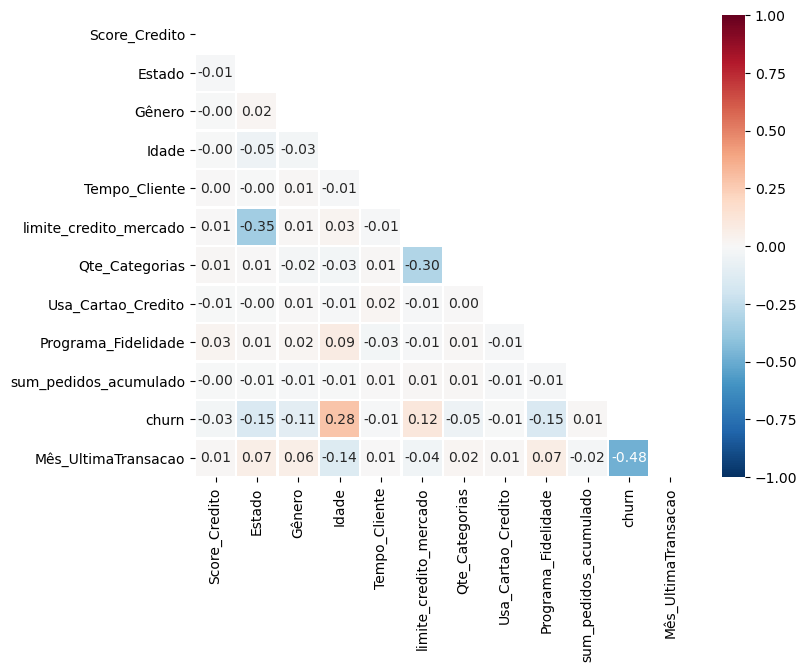

In [76]:
# Creating a correlation matrix.
correlation = df_aux.drop(columns = 'ClientId').corr()

mask = np.zeros_like(correlation)
# Selecting the lower triangule 
mask[np.triu_indices_from(mask)] = True

%matplotlib inline
fig = plt.figure(figsize=(8,6))
sns.heatmap(correlation,
            mask = mask,
            cmap='RdBu_r',
            vmin=-1, vmax=1,
            linewidths = 1,
            annot=True,
            fmt=".2f");


There are no strong correlation between the features

# Spliting the dataset into train and test

In [77]:
from sklearn.model_selection import train_test_split

In [78]:
df.columns

Index(['ClientId', 'DataExtracao', 'Score_Credito', 'Estado', 'Gênero',
       'Idade', 'Tempo_Cliente', 'limite_credito_mercado', 'Qte_Categorias',
       'Usa_Cartao_Credito', 'Programa_Fidelidade', 'sum_pedidos_acumulado',
       'DataUltimaTransacao', 'churn', 'Mês_UltimaTransacao'],
      dtype='object')

In [79]:
# Before spliting the dataset, we need to drop the features "Mês_UltimaTransacao" e "DataUltimaTransacao" to avoid dataleakage.

df_data_leak = df.drop(labels=['DataExtracao','Mês_UltimaTransacao','DataUltimaTransacao'], axis = 1)
df_data_leak.columns

Index(['ClientId', 'Score_Credito', 'Estado', 'Gênero', 'Idade',
       'Tempo_Cliente', 'limite_credito_mercado', 'Qte_Categorias',
       'Usa_Cartao_Credito', 'Programa_Fidelidade', 'sum_pedidos_acumulado',
       'churn'],
      dtype='object')

In [80]:
# Split the dataset into 70% for training and 30% for test
datatrain,datatest = train_test_split(df_data_leak,test_size=0.30, random_state=50)

In [81]:
datatrain.shape

(7000, 12)

In [82]:
datatest.shape

(3000, 12)

In [83]:
#Counting the number of unique values in each variable of the training dataset.

info = datatrain.nunique().sort_values()

# Determining the type of data, of each of the variables, of the training dataset.

info = pd.DataFrame(info.values, index = info.index, columns = ['NUniques'])

# Assigning information about the data type of variables to the dataframe.

info['dtypes'] = datatrain.dtypes

#  Displaying dataframe.

info

NUniques    dtypes
Gênero                         2  category
Usa_Cartao_Credito             2  category
Programa_Fidelidade            2  category
churn                          2  category
Estado                         3  category
Qte_Categorias                 4  category
Tempo_Cliente                 11     int64
Idade                         69     int64
Score_Credito                453     int64
limite_credito_mercado      4351   float64
sum_pedidos_acumulado       6729   float64
ClientId                    7000  category

# Feature selection
In this step will be selected the features that have highest information value on churn


## Standardizing numerical features

In [84]:
var_num =datatrain.select_dtypes(exclude = ['datetime','object','category']).columns
var_num 

Index(['Score_Credito', 'Idade', 'Tempo_Cliente', 'limite_credito_mercado',
       'sum_pedidos_acumulado'],
      dtype='object')

### Train dataset

In [85]:

datatrain[var_num].head(3)

Score_Credito  Idade  Tempo_Cliente  limite_credito_mercado  \
5189            826     41              5                 1464.66   
7969            637     49              2                 1082.05   
9039            545     44              1                    0.00   

      sum_pedidos_acumulado  
5189                 753.89  
7969                 704.32  
9039                 344.23

In [86]:

#Creating object of type StandarScaler()
scaler = StandardScaler()

#Applying the scale in the features
features_transformed_train = scaler.fit_transform(datatrain[var_num])



In [87]:
features_transformed_train

array([[ 1.82458338e+00,  2.19905576e-01, -2.57204809e-03,
         1.12917343e+00,  1.40516722e+00],
       [-1.22525074e-01,  9.89046309e-01, -1.04128378e+00,
         5.16858292e-01,  1.19846755e+00],
       [-1.07032390e+00,  5.08333351e-01, -1.38752102e+00,
        -1.21481520e+00, -3.03055260e-01],
       ...,
       [ 5.26116651e-02,  1.56590186e+00, -6.95046535e-01,
         1.85278947e-01, -1.68110868e+00],
       [-2.61564807e+00, -4.53092565e-01, -2.57204809e-03,
         4.81762318e-01, -1.43654673e+00],
       [ 1.41249693e+00, -1.64664790e-01,  6.89902438e-01,
         1.44012409e+00, -5.74762961e-01]])

### Test dataset

In [88]:

datatest[var_num].head(3)

Score_Credito  Idade  Tempo_Cliente  limite_credito_mercado  \
9102            445     61              2                 1376.55   
7868            611     29              4                  788.86   
4176            754     39              8                 1294.02   

      sum_pedidos_acumulado  
9102                 124.62  
7868                 112.20  
4176                 365.35

In [89]:
#Creating object of type StandarScaler()
scaler = StandardScaler()

#Applying the scale in the features
features_transformed_test = scaler.fit_transform(datatest[var_num])



In [90]:
features_transformed_test

array([[-2.19081495,  2.02355971, -1.04288622,  0.96240169, -1.22410742],
       [-0.45361223, -0.97564877, -0.35345064,  0.01694541, -1.27604265],
       [ 1.04289372, -0.03839612,  1.02542052,  0.82963015, -0.21747551],
       ...,
       [ 1.24173018, -1.53800036,  1.02542052, -1.25214654, -0.75627217],
       [ 0.05917652, -0.13212138, -0.00873285,  0.52668323,  1.66812466],
       [-0.32803131,  0.24277968, -1.38760401,  1.15025741,  0.0116333 ]])


## Concatenating the transformed numerical features with category type features

### Train set

In [91]:

# Creating DataFrame with obtained results

df_transformed_train = pd.DataFrame(data = features_transformed_train,index = datatrain.index, columns = df_data_leak[var_num].columns)
df_transformed_train.head(3)

Score_Credito     Idade  Tempo_Cliente  limite_credito_mercado  \
5189       1.824583  0.219906      -0.002572                1.129173   
7969      -0.122525  0.989046      -1.041284                0.516858   
9039      -1.070324  0.508333      -1.387521               -1.214815   

      sum_pedidos_acumulado  
5189               1.405167  
7969               1.198468  
9039              -0.303055

In [92]:
var_cat_name = df_data_leak.select_dtypes(include=['category']).columns
var_cat_name = var_cat_name.drop('churn')
var_cat_name

Index(['ClientId', 'Estado', 'Gênero', 'Qte_Categorias', 'Usa_Cartao_Credito',
       'Programa_Fidelidade'],
      dtype='object')

In [93]:
# Concatenating the standardized numerical features with category type features
var_cat_train =datatrain[var_cat_name]
var_cat_train.head(3)

ClientId          Estado     Gênero Qte_Categorias Usa_Cartao_Credito  \
5189   350757  Rio de Janeiro  Masculino              2                  0   
7969   353537    Minas Gerais  Masculino              1                  1   
9039   354607  Rio de Janeiro   Feminino              2                  1   

     Programa_Fidelidade  
5189                   0  
7969                   0  
9039                   1

In [94]:
df_transformed_train_conc= pd.concat([var_cat_train,df_transformed_train,df_data_leak['churn'] ],axis = 1, join ='inner')

In [95]:
df_transformed_train_conc.head(3)

ClientId          Estado     Gênero Qte_Categorias Usa_Cartao_Credito  \
5189   350757  Rio de Janeiro  Masculino              2                  0   
7969   353537    Minas Gerais  Masculino              1                  1   
9039   354607  Rio de Janeiro   Feminino              2                  1   

     Programa_Fidelidade  Score_Credito     Idade  Tempo_Cliente  \
5189                   0       1.824583  0.219906      -0.002572   
7969                   0      -0.122525  0.989046      -1.041284   
9039                   1      -1.070324  0.508333      -1.387521   

      limite_credito_mercado  sum_pedidos_acumulado churn  
5189                1.129173               1.405167     0  
7969                0.516858               1.198468     0  
9039               -1.214815              -0.303055     0

### Test set

In [96]:


df_transformed_test = pd.DataFrame(data = features_transformed_test,index = datatest.index, columns = df_data_leak[var_num].columns)
df_transformed_test.head(3)

Score_Credito     Idade  Tempo_Cliente  limite_credito_mercado  \
9102      -2.190815  2.023560      -1.042886                0.962402   
7868      -0.453612 -0.975649      -0.353451                0.016945   
4176       1.042894 -0.038396       1.025421                0.829630   

      sum_pedidos_acumulado  
9102              -1.224107  
7868              -1.276043  
4176              -0.217476

In [97]:
var_cat_name = df_data_leak.select_dtypes(include=['category']).columns
var_cat_name = var_cat_name.drop('churn')
var_cat_name

Index(['ClientId', 'Estado', 'Gênero', 'Qte_Categorias', 'Usa_Cartao_Credito',
       'Programa_Fidelidade'],
      dtype='object')

In [98]:

var_cat_test =datatest[var_cat_name]
var_cat_test.head(3)

ClientId        Estado    Gênero Qte_Categorias Usa_Cartao_Credito  \
9102   354670  Minas Gerais  Feminino              1                  0   
7868   353436  Minas Gerais  Feminino              2                  1   
4176   349744  Minas Gerais  Feminino              1                  1   

     Programa_Fidelidade  
9102                   1  
7868                   1  
4176                   1

In [99]:
df_transformed_test_conc= pd.concat([var_cat_test,df_transformed_test,df_data_leak['churn'] ],axis = 1, join ='inner')

In [100]:
df_transformed_test_conc.head(3)

ClientId        Estado    Gênero Qte_Categorias Usa_Cartao_Credito  \
9102   354670  Minas Gerais  Feminino              1                  0   
7868   353436  Minas Gerais  Feminino              2                  1   
4176   349744  Minas Gerais  Feminino              1                  1   

     Programa_Fidelidade  Score_Credito     Idade  Tempo_Cliente  \
9102                   1      -2.190815  2.023560      -1.042886   
7868                   1      -0.453612 -0.975649      -0.353451   
4176                   1       1.042894 -0.038396       1.025421   

      limite_credito_mercado  sum_pedidos_acumulado churn  
9102                0.962402              -1.224107     0  
7868                0.016945              -1.276043     0  
4176                0.829630              -0.217476     0

## Separating the features from Target

### Train set

In [101]:
x_train = df_transformed_train_conc.drop(labels = 'churn', axis = 1)
y_train=df_transformed_train_conc['churn']

In [102]:
y_train

5189    0
7969    0
9039    0
5208    0
506     0
       ..
8262    0
6214    0
8324    0
6253    1
5600    0
Name: churn, Length: 7000, dtype: category
Categories (2, int64): [0, 1]

### Test set

In [103]:
x_test = df_transformed_test_conc.drop(labels = 'churn', axis = 1)
y_test=df_transformed_test_conc['churn']

In [104]:
y_test

9102    0
7868    0
4176    0
4161    0
8770    0
       ..
6138    1
6174    0
3289    0
5039    0
3111    0
Name: churn, Length: 3000, dtype: category
Categories (2, int64): [0, 1]


## Creating functions to select the features by their Information Value

### Grouping numerical features

In [105]:
# Transforming numerical variables in categorical variables:
def num_group(data,feature):
    df = data.copy()

    df_IV_quant = df.loc[:,((df.dtypes == 'int32') |  
                        (df.dtypes == 'int64') | 
                        (df.dtypes == 'float64'))]
    
    vars = df_IV_quant.columns 
    for var in vars:               
        name_var = 'fx_' + var 
        df_IV_quant[name_var] = pd.qcut(df_IV_quant[var], q = 5,precision=2, duplicates='drop')
        df_IV_quant = df_IV_quant.drop(var, axis = 1)
        df_IV_quant = df_IV_quant.rename(columns={name_var: var})    

    df_IV_str = df.loc[:,((df.dtypes == 'object') | 
                        (df.dtypes == 'category') |
                        (df.dtypes == 'bool'))]

    df = pd.concat([df_IV_quant,df_IV_str],axis = 1)
    return df

### Obtaining Information Value

In [106]:
def IV(data,feature):
    to_drop = [feature]
    vars = data.drop(to_drop, axis = 1).columns  

    List_IV = []
    Feat_name = []
    bivariada = {}
    for var in vars: 

        df_aux = data.copy() 
        df_aux['target'] = data[feature]
        df3 = df_aux.pivot_table(values='target',
                                index=var,
                                columns=feature,
                                aggfunc='count')

        df3 = df3.rename(columns={0:'#Target_0',
                                1:'#Target_1'})
        df3.fillna(0, inplace=True)

        df3['%Target_1'] = df3['#Target_1'] / df3['#Target_1'].sum()
        df3['%Target_0'] = df3['#Target_0'] / df3['#Target_0'].sum()
        df3['%Target_0'] = df3['%Target_0'].apply(lambda x: 0.01 if x == 0 else x) 
        df3['Odds'] = (df3['%Target_1'] / df3['%Target_0'])
        df3['Odds'] = df3.Odds.apply(lambda x: 0.01 if x == 0 else x)
        df3['LN(Odds)'] = np.log(df3['Odds'])
        df3['IV'] = ((df3['%Target_1'] - df3['%Target_0']) * df3['LN(Odds)'])
        df3['IV'] = np.where(df3['Odds'] == 0.01, 0 , df3['IV']) 
        Sum_IV = df3['IV'].sum().round(decimals=3)

        Feat_name.append(var)
        List_IV.append(Sum_IV)  
        #bivariada.append(df3)
        bivariada[var] = df3
    df_IV = pd.DataFrame(list(zip(Feat_name, List_IV)),
                         columns=['Feature', 'Sum_IV']).sort_values(by=['Sum_IV'],ascending=False)
    df_IV = df_IV.reset_index( )
    df_IV = df_IV.drop('index',axis=1)
    return df_IV,bivariada

def impact_IV (value):
    if value['Sum_IV'] < 0.02: return 'very weak'
    if value['Sum_IV'] < 0.1: return 'weak'
    if value['Sum_IV'] < 0.3: return 'medium'
    if value['Sum_IV'] < 0.5: return 'strong'   
    else: return 'very strong'

#Rank_IV =IV(df3,'Flag_Renovou')
#Rank_IV['Impact'] = Rank_IV.apply(impact_IV, axis=1)
#Rank_IV

### Selection of the most important features

In [107]:
def var_select(ranking_iv, threshold):
    linhas_filtradas = ranking_iv[ranking_iv.iloc[:, 1] > threshold]
    nomes = linhas_filtradas.iloc[:,0].tolist()
    return nomes


### Hypothesis test of proportions (z-statistic) and feature selection

This function checks whether the proportions of customers churning between the categories of Feature analyzed are statistically different from each other.

Only the Features that the test found significant statistical differences (p-value < 0.05) will be selected.

In [108]:
from statsmodels.stats.proportion import proportions_ztest

def create_comparison_matrix(data, feature, target):
    unique_categories = data[feature].unique()
    num_categories = len(unique_categories)
    comparison_matrix = pd.DataFrame(index=unique_categories, columns=unique_categories)

    for cat1 in unique_categories:
        for cat2 in unique_categories:
            if cat1 != cat2:               
                bivariate = IV(data,target)[1][feature]
                # Total number of observations in the category
                n_cat1 = bivariate.loc[cat1,'#Target_0']+bivariate.loc[cat1,'#Target_1']
                n_cat2 = bivariate.loc[cat2,'#Target_0']+bivariate.loc[cat2,'#Target_1']
                nobs =  np.array([n_cat1,n_cat2])
                # Number of successes within the category
                n_cat1_target1 = bivariate.loc[cat1,'#Target_1']
                n_cat2_target1 = bivariate.loc[cat2,'#Target_1']
                count = np.array([n_cat1_target1,n_cat2_target1])
                # Z statistic and p-value
                stat, pval = proportions_ztest(count, nobs)
                
                # Inserting the statistic values into the lower triangle
                comparison_matrix.loc[cat1, cat2] = stat
                # Inserting the p-value into the upper triangle
                comparison_matrix.loc[cat2, cat1] = round(pval,3)
            else:
                bivariate = IV(data,target)[1][feature]
                
                n_cat1 = bivariate.loc[cat1,'#Target_0']+bivariate.loc[cat1,'#Target_1']
                n_cat1_target1 = bivariate.loc[cat1,'#Target_1']
                # Inserting the success rate into the main diagonal
                comparison_matrix.loc[cat1, cat2] = float(n_cat1_target1)/n_cat1

    return comparison_matrix

def feature_selection(data, selected_IV, target):
    selected_features = []
    dict_matrices = {}
    
    for feature in selected_IV:       
        comparison_matrix = create_comparison_matrix(data, feature, target)
        upper_triangle = comparison_matrix.values[np.triu_indices_from(comparison_matrix, k=1)]
        if np.any(upper_triangle < 0.05):
            dict_matrices[feature] = comparison_matrix
            selected_features.append(feature)
    if dict_matrices:
        return selected_features, dict_matrices
    else:
        return None, None, None


## Applying Feature selection

In [109]:

# Concatenating the features with target in the train set
data_aux = pd.concat([x_train,y_train],axis = 1)
data_aux = data_aux.drop(columns = 'ClientId', axis = 1) 

In [110]:

#Applying the grouping function to numerical features
data_agrup = num_group(data_aux,feature = None)

In [111]:
data_agrup.head(3)

Score_Credito         Idade   Tempo_Cliente limite_credito_mercado  \
5189    (0.86, 2.07]  (0.028, 0.7]   (-0.35, 0.34]            (0.92, 2.8]   
7969   (-0.25, 0.29]   (0.7, 5.12]  (-1.74, -1.04]         (-0.072, 0.54]   
9039  (-3.09, -0.88]  (0.028, 0.7]  (-1.74, -1.04]        (-1.22, -0.072]   

     sum_pedidos_acumulado          Estado     Gênero Qte_Categorias  \
5189          (1.04, 1.74]  Rio de Janeiro  Masculino              2   
7969          (1.04, 1.74]    Minas Gerais  Masculino              1   
9039         (-0.35, 0.34]  Rio de Janeiro   Feminino              2   

     Usa_Cartao_Credito Programa_Fidelidade churn  
5189                  0                   0     0  
7969                  1                   0     0  
9039                  1                   1     0

In [112]:
#Applying the function that calculates the IV and the bivariate frequency to each feature
ranking_iv, bivariada = IV(data_agrup,'churn')

In [113]:
ranking_iv

Feature  Sum_IV
0          Qte_Categorias   1.016
1                   Idade   0.766
2                  Estado   0.179
3     Programa_Fidelidade   0.165
4  limite_credito_mercado   0.092
5                  Gênero   0.070
6           Score_Credito   0.007
7           Tempo_Cliente   0.004
8   sum_pedidos_acumulado   0.003
9      Usa_Cartao_Credito   0.000

In [114]:
#Applying the function that selects the features with the highest Information Value
top_feat = var_select(ranking_iv, 0.1)
top_feat

['Qte_Categorias', 'Idade', 'Estado', 'Programa_Fidelidade']

In [115]:
bivariada['Qte_Categorias']

churn           #Target_0  #Target_1  %Target_1  %Target_0        Odds  \
Qte_Categorias                                                           
1                    2552       1005   0.708745   0.457184    1.550240   
2                    2995        220   0.155148   0.536546    0.289161   
3                      34        154   0.108604   0.006091   17.830167   
4                       1         39   0.027504   0.000179  153.524683   

churn           LN(Odds)        IV  
Qte_Categorias                      
1               0.438410  0.110287  
2              -1.240772  0.473228  
3               2.880892  0.295328  
4               5.033861  0.137547

In [116]:
bivariada['Idade']

churn           #Target_0  #Target_1  %Target_1  %Target_0      Odds  \
Idade                                                                  
(-2.0, -0.84]        1303        107   0.075458   0.233429  0.323261   
(-0.84, -0.36]       1397        136   0.095910   0.250269  0.383227   
(-0.36, 0.028]       1127        172   0.121298   0.201899  0.600784   
(0.028, 0.7]         1073        417   0.294076   0.192225  1.529854   
(0.7, 5.12]           682        586   0.413258   0.122178  3.382415   

churn           LN(Odds)        IV  
Idade                               
(-2.0, -0.84]  -1.129296  0.178395  
(-0.84, -0.36] -0.959128  0.148050  
(-0.36, 0.028] -0.509520  0.041068  
(0.028, 0.7]    0.425172  0.043304  
(0.7, 5.12]     1.218590  0.354707

In [117]:
bivariada['Estado']

churn           #Target_0  #Target_1  %Target_1  %Target_0      Odds  \
Estado                                                                 
Minas Gerais         1175        571   0.402680   0.210498  1.912986   
Rio de Janeiro       1445        288   0.203103   0.258868  0.784582   
S�o Paulo            2962        559   0.394217   0.530634  0.742917   

churn           LN(Odds)        IV  
Estado                              
Minas Gerais    0.648665  0.124662  
Rio de Janeiro -0.242604  0.013529  
S�o Paulo      -0.297171  0.040539

In [118]:
bivariada['Programa_Fidelidade']

churn                #Target_0  #Target_1  %Target_1  %Target_0      Odds  \
Programa_Fidelidade                                                         
0                         2482        915   0.645275   0.444643  1.451219   
1                         3100        503   0.354725   0.555357  0.638734   

churn                LN(Odds)        IV  
Programa_Fidelidade                      
0                    0.372404  0.074716  
1                   -0.448268  0.089937

In [119]:
## Testing the hypothesis of proportions on selected features
feat_select, matrizes = feature_selection(data_agrup,top_feat,'churn')
feat_select

['Qte_Categorias', 'Idade', 'Estado', 'Programa_Fidelidade']

In [120]:
matrizes['Qte_Categorias']

2         1      3      4
2   0.819149       0.0  0.013  0.013
1 -31.988418  0.068429    0.0    0.0
3   2.482981  21.05605  0.975    1.0
4   2.482981  21.05605    0.0  0.975

In [121]:
matrizes['Idade']

(0.028, 0.7] (0.7, 5.12] (-0.36, 0.028] (-2.0, -0.84]  \
(0.028, 0.7]       0.279866         0.0            0.0           0.0   
(0.7, 5.12]        9.917411    0.462145            0.0           0.0   
(-0.36, 0.028]    -9.517351  -18.310029        0.13241           0.0   
(-2.0, -0.84]    -14.269173  -22.787975      -4.835471      0.075887   
(-0.84, -0.36]   -13.590907  -22.490589      -3.721603      1.263175   

               (-0.84, -0.36]  
(0.028, 0.7]              0.0  
(0.7, 5.12]               0.0  
(-0.36, 0.028]            0.0  
(-2.0, -0.84]           0.207  
(-0.84, -0.36]       0.088715

In [122]:
matrizes['Estado']

Rio de Janeiro Minas Gerais S�o Paulo
Rio de Janeiro       0.166186          0.0     0.491
Minas Gerais        11.000577     0.327033       0.0
S�o Paulo            -0.68803   -14.004428  0.158762

In [123]:
matrizes['Programa_Fidelidade']

0         1
0   0.269355       0.0
1 -13.498992  0.139606

# Models classification

In [124]:
# Features that will be used in the model
x_train_select = x_train[feat_select]
x_train_select.head(3)

Qte_Categorias     Idade          Estado Programa_Fidelidade
5189              2  0.219906  Rio de Janeiro                   0
7969              1  0.989046    Minas Gerais                   0
9039              2  0.508333  Rio de Janeiro                   1

## Transforming the selected features to dummies 

In [125]:

x_train_select_dummies =pd.get_dummies(x_train_select, drop_first = True)
x_train_select_dummies.head(3)

Idade  Qte_Categorias_2  Qte_Categorias_3  Qte_Categorias_4  \
5189  0.219906                 1                 0                 0   
7969  0.989046                 0                 0                 0   
9039  0.508333                 1                 0                 0   

      Estado_Rio de Janeiro  Estado_S�o Paulo  Programa_Fidelidade_1  
5189                      1                 0                      0  
7969                      0                 0                      0  
9039                      1                 0                      1

In [126]:
#Test dataset (transforming to dummies)
x_test_select = x_test[feat_select]
x_test_select_dummies = pd.get_dummies(x_test_select, drop_first=True)
x_test_select_dummies.head(3)

Idade  Qte_Categorias_2  Qte_Categorias_3  Qte_Categorias_4  \
9102  2.023560                 0                 0                 0   
7868 -0.975649                 1                 0                 0   
4176 -0.038396                 0                 0                 0   

      Estado_Rio de Janeiro  Estado_S�o Paulo  Programa_Fidelidade_1  
9102                      0                 0                      1  
7868                      0                 0                      1  
4176                      0                 0                      1

In [127]:
y_train.head(3)

5189    0
7969    0
9039    0
Name: churn, dtype: category
Categories (2, int64): [0, 1]

In [128]:
y_test.head(3)

9102    0
7868    0
4176    0
Name: churn, dtype: category
Categories (2, int64): [0, 1]

## Importing the necessary libraries

In [129]:
import sklearn

In [130]:
from sklearn.model_selection import StratifiedKFold

In [131]:
from sklearn.model_selection import cross_validate

In [132]:

from sklearn.linear_model import LogisticRegression


from sklearn.tree import DecisionTreeClassifier


from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

In [133]:
print(sklearn.__version__)

1.3.2


In [134]:
import imblearn
from sklearn.model_selection import GridSearchCV
import datetime

# Métricas de Desempenho
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from scipy.stats import ks_2samp




## Creating auxiliary functions to show the results

In [135]:

def log_message(message):
    print(datetime.datetime.now().strftime("%H:%M:%S - "), message)

In [136]:
# Function to calculate KS
def ks_stat(y, y_pred):
    return ks_2samp(y_pred[y==1], y_pred[y!=1]).statistic
# Função para cálculo do desempenho de modelos
# Function to calculate models performance
def calcula_desempenho(modelo, x_train, y_train, x_test, y_test, threshold=0.5):
    
    
    # Prediction calculation
    #ypred_train = modelo.predict(x_train)
    ypred_proba_train = modelo.predict_proba(x_train)[:,1]
    ypred_train = np.where(ypred_proba_train>threshold,1,0)
   

    #ypred_test = modelo.predict(x_test)
    ypred_proba_test = modelo.predict_proba(x_test)[:,1]
    ypred_test = np.where(ypred_proba_test>threshold,1,0)

    # Performance metrics
    acc_train = accuracy_score(y_train, ypred_train)
    acc_test = accuracy_score(y_test, ypred_test)
    
    roc_train = roc_auc_score(y_train, ypred_proba_train)
    roc_test = roc_auc_score(y_test, ypred_proba_test)
    
    ks_train = ks_stat(y_train, ypred_proba_train)
    ks_test = ks_stat(y_test, ypred_proba_test)
    
    prec_train = precision_score(y_train, ypred_train, zero_division=0)
    prec_test = precision_score(y_test, ypred_test, zero_division=0)
    
    recl_train = recall_score(y_train, ypred_train)
    recl_test = recall_score(y_test, ypred_test)
    
    f1_train = f1_score(y_train, ypred_train)
    f1_test = f1_score(y_test, ypred_test)
    
    df_desemp = pd.DataFrame({'Treino':[acc_train, roc_train, ks_train, 
                                        prec_train, recl_train, f1_train],
                              'Teste':[acc_test, roc_test, ks_test,
                                       prec_test, recl_test, f1_test]},
                            index=['Acurácia','AUROC','KS',
                                   'Precision','Recall','F1'])
    
    df_desemp['Variação'] = round(df_desemp['Teste'] / df_desemp['Treino'] - 1, 2)
    
    return df_desemp

In [137]:

#Creates a function that returns bivariate frequency table
def tabela_bivariada(data,var):
    
    df = pd.DataFrame(data[var].value_counts()).sort_values(by=var,ascending=False)
    total = df[var].sum()
    df['Freq_Relativa'] = (df[var]/total).round(decimals=2)
    df['Freq_Acumulada'] = df['Freq_Relativa'].cumsum().round(decimals=2)
    return df;


def cria_grafico_var_qualitativa(tab):

    # Aumenta o tamanho do gráfico (largura 8 e altura 4)
    fig = plt.figure(figsize=(8,4))

    # Cria um gráfico de barras usando o indice da tabela como rótulos do eixo X
    cor = np.random.rand(3)
    plt.bar(tab.index,tab['Freq_Relativa'],width = 0.7, tick_label=tab.index,color=cor,alpha=0.6)

    plt.ylim(0,tab['Freq_Relativa'].max()+0.2)
    plt.title("Frequência Relativa de {}".format(list(tab.columns)[0]))

    # cria um conjunto de pares de rótulos e frequencias relativas
    for x,y in zip(tab.index,tab['Freq_Relativa']):

        # formata o rotulo do percentual
        rotulo = "{:.2f}".format(y)

        # coloca o rotulo na posição (x,y), alinhado ao centro e com distância 0,5 do ponto (x,y)
        plt.annotate(rotulo,(x,y),ha='center',textcoords="offset points",xytext=(0,5))

## Balancing samples between customers who churned and did not churn

### Under Tomek

In [138]:

under_tomek = imblearn.under_sampling.TomekLinks(sampling_strategy='auto',
                                                 n_jobs=4)

In [139]:
log_message('Iniciando Tomek Link Undersampling...')

x_train_under_tomek, y_train_under_tomek = under_tomek.fit_resample(x_train_select_dummies, y_train)

log_message('Concluída preparação Tomek Link Undersampling!')
print('Shape do y_train: ', y_train.shape)
print('Shape do y_train_tomek: ', y_train_under_tomek.shape)

21:22:16 -  Iniciando Tomek Link Undersampling...
21:22:16 -  Concluída preparação Tomek Link Undersampling!
Shape do y_train:  (7000,)
Shape do y_train_tomek:  (6989,)


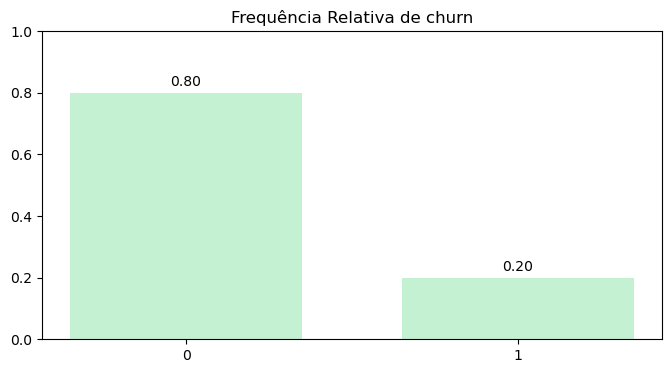

In [140]:
cria_grafico_var_qualitativa(tabela_bivariada(pd.DataFrame(y_train_under_tomek), 
                                                                  'churn'))

### Smote oversamplig

In [141]:
#Instanciando objeto  Smote Oversampling
over_smote = imblearn.over_sampling.SMOTE(sampling_strategy=0.5,
                                          random_state=42, 
                                          n_jobs=4)

### Combining the both methods

In [142]:
 #IMPORTANTE: 
 
 #a reamostragem deve ser feita APENAS na base de Treino
 
log_message('Iniciando SMOTE + Tomek Link Undersampling...')
smote_tomek = imblearn.combine.SMOTETomek(sampling_strategy='auto', 
                                          random_state=42,
                                          smote=over_smote,
                                          tomek=under_tomek,
                                          n_jobs=-1)
x_train_smote_tomek, y_train_smote_tomek = smote_tomek.fit_resample(x_train_select_dummies, y_train)
log_message('Concluída preparação SMOTE + Tomek Link Undersampling!')

print('Shape do y_train: ', y_train.shape)
print('Shape do y_train_smote_tomek: ', y_train_smote_tomek.shape)

21:22:16 -  Iniciando SMOTE + Tomek Link Undersampling...
21:22:17 -  Concluída preparação SMOTE + Tomek Link Undersampling!
Shape do y_train:  (7000,)
Shape do y_train_smote_tomek:  (8354,)


c:\users\loren\documents\preditiva\preditiva\lib\site-packages\imblearn\over_sampling\_smote\base.py:363: FutureWarning:

The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.



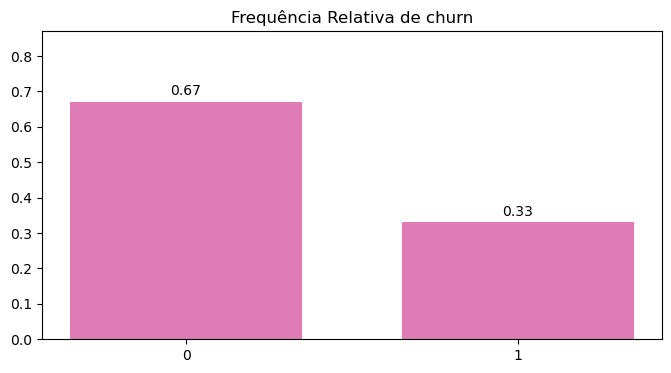

In [143]:
cria_grafico_var_qualitativa(tabela_bivariada(pd.DataFrame(y_train_smote_tomek), 
                                                                  'churn'))

## Creating the base models

### Logisitc Regression

In [144]:
#Base model
model_LR = LogisticRegression(random_state = 42) 

In [145]:

#Hiperparametric space

ehp_penalty = ['l1','l2']

ehp_C = [0.001,0.01, 0.05, 1, 10, 100]
ehp_solver = ['lbfgs', 'newton-cholesky', 'sag', 'saga']

ehp_max_iter = [100, 200, 300, 400, 500]

ehp_tol= [0.0001, 0.0005]

param_grid_LR = dict(penalty = ehp_penalty,
                     C = ehp_C,
                     max_iter = ehp_max_iter,
                     tol = ehp_tol)

In [146]:
#Applying Tunning
modelo_LR_grid = GridSearchCV(estimator=model_LR, 
                           param_grid=param_grid_LR,
                           scoring = ('recall','roc_auc'),
                           n_jobs=-1,
                           cv=5,
                           refit = 'recall',
                           verbose=4)

### Decision tree

In [147]:
#Base model
model_DT = DecisionTreeClassifier(random_state = 42)

In [148]:
# Número mínimo de amostras por folha
ehp_min_samples_leaf = np.arange(5, 31, 5)

# Máxima profundidade
ehp_max_depth = [2, 3, 4, 5]

ehp_min_samples_split = np.arange(10,41,5)
# Definição do dicionário de parâmetros
param_grid_DT = dict(min_samples_leaf=ehp_min_samples_leaf,
                  max_depth=ehp_max_depth,
                  min_samples_split = ehp_min_samples_split
                 )

In [149]:
#Applying Tunning
modelo_DT_grid = GridSearchCV(estimator=model_DT, 
                           param_grid=param_grid_DT,
                           scoring = ('recall','roc_auc'),
                           n_jobs=-1,
                           cv=5,
                           refit = 'recall',
                           verbose=4)

### AdaBoosting

In [150]:
#Base models
modelo_ada = AdaBoostClassifier(random_state=42)

In [151]:

#Hiperparametric space

ehp_n_estimators = [10, 20, 50, 100, 150, 200, 300, 400, 500]

ehp_learning_rate = np.arange(0.001,0.101,0.001)

param_grid_ada = dict(n_estimators = ehp_n_estimators,
                      learning_rate = ehp_learning_rate)

In [152]:

#Applying Tunning
modelo_ada_grid = GridSearchCV(estimator=modelo_ada, 
                           param_grid=param_grid_ada,
                           scoring = ('recall','roc_auc'),
                           n_jobs=-1,
                           cv=5,
                           refit = 'recall',
                           verbose=4)

###  GradientBoosting

In [153]:
#Base model cration
modelo_GB = GradientBoostingClassifier(random_state=42)

In [154]:
# Número mínimo de amostras por folha
ehp_min_samples_leaf = np.arange(5, 26, 5)

# Máxima profundidade
ehp_max_depth = [2, 3, 4, 5]

# Número de estimadores
ehp_n_estimators = [10, 20, 50, 100, 150, 200,300,400,500]

# Amostragem de observações usadas para cada árvore
ehp_subsample = [0.1, 0.2, 0.3, 0.4, 0.5,0.6,0.7]

# Definição do dicionário de parâmetros
param_grid_GB = dict(min_samples_leaf=ehp_min_samples_leaf,
                  max_depth=ehp_max_depth,
                  n_estimators=ehp_n_estimators,
                  subsample=ehp_subsample
                 )

In [155]:
#Applying Tunning
modelo_GB_grid = GridSearchCV(estimator=modelo_GB, 
                           param_grid=param_grid_GB,
                           scoring = ('recall','roc_auc'),
                           n_jobs=-1,
                           cv=5,
                           refit='recall',
                           verbose=4)

### Random Forest

In [156]:
#Base model creation
modelo_RF = RandomForestClassifier(random_state=42)

In [157]:
# Número mínimo de amostras por folha
ehp_min_samples_leaf = np.arange(5, 26, 5)

# Máxima profundidade
ehp_max_depth = [2, 3, 4, 5]

# Número de estimadores
ehp_n_estimators = [10, 20, 50, 100, 150, 200,300,400,500]

#
# Definição do dicionário de parâmetros
param_grid_RF = dict(min_samples_leaf=ehp_min_samples_leaf,
                  max_depth=ehp_max_depth,
                  n_estimators=ehp_n_estimators,
                 )

In [158]:
# Applying Tunning
modelo_RF_grid = GridSearchCV(estimator=modelo_RF, 
                           param_grid=param_grid_RF,
                           scoring = ('recall','roc_auc'),
                           n_jobs=-1,
                           cv=5,
                           refit = 'recall',
                           verbose=4)

## Create function that measures the performance during the tunning of the best estimator from each model 

In [159]:
def treino_modelos_class(x_train,y_train,x_test,y_test):

    performance_results = {}
    modelos = {}
    best_models = {}
    
    modelos['LR']= modelo_LR_grid
    modelos['DT']= modelo_DT_grid
    modelos['AdaBoost']= modelo_ada_grid
    modelos['GB']= modelo_GB_grid
    modelos['RF']= modelo_RF_grid
    
    
    for modelo in modelos:
        
        modelos[modelo].fit(x_train,y_train)
        
        best_model = modelos[modelo].best_estimator_
        
        best_model_performance= calcula_desempenho(best_model,
                                                  x_train, y_train, 
                                                  x_test, y_test)
            
        performance_results[modelo]=best_model_performance
        best_models[modelo] = best_model
            
    return performance_results, best_models
           
            
            
            

In [160]:
import sklearn.metrics

# Listar todas as métricas de pontuação disponíveis
metricas_disponiveis = sorted(sklearn.metrics.get_scorer_names())

print(metricas_disponiveis)


['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'matthews_corrcoef', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_negative_likelihood_ratio', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'positive_likelihood_ratio', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'rand_score', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weight


## Storing the function output 

In [161]:
def plot_performance(values, labels,variation):
        # Dados
    labels = list( labels )

    # Criando a figura e os subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    # Gráfico da esquerda
    axs[0].plot(labels, values, marker='o', color='b', linestyle='-')
    axs[0].set_title('Performance of algorithms')
    axs[0].set_xlabel('Algorithm')
    axs[0].set_ylabel('Performance')
    
    # Gráfico da esquerda
    axs[1].plot(labels, variation, marker='o', color='b', linestyle='-')
    axs[1].set_title('Variation between Train and Test datasets')
    axs[1].set_xlabel('Algorithm')
    axs[1].set_ylabel('Variation')


    # Exibindo os gráficos
    plt.tight_layout()
    plt.show()

In [162]:
param = LogisticRegression().get_params().keys()
# Get the available parameters and print them out

print("Available parameters for LogisticRegression:")
for param in param:
    print(param)

Available parameters for LogisticRegression:
C
class_weight
dual
fit_intercept
intercept_scaling
l1_ratio
max_iter
multi_class
n_jobs
penalty
random_state
solver
tol
verbose
warm_start


### Without sample balance

In [163]:
métricas, melhores_modelos = treino_modelos_class(x_train_select_dummies,y_train,x_test_select_dummies,y_test)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


c:\users\loren\documents\preditiva\preditiva\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning:


300 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "c:\users\loren\documents\preditiva\preditiva\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\loren\documents\preditiva\preditiva\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\users\loren\documents\preditiva\preditiva\lib\site-packages\sklearn\linear_model\_logistic.py"

Fitting 5 folds for each of 168 candidates, totalling 840 fits
Fitting 5 folds for each of 900 candidates, totalling 4500 fits
Fitting 5 folds for each of 1260 candidates, totalling 6300 fits
Fitting 5 folds for each of 180 candidates, totalling 900 fits


#### AUC Score classification

In [164]:
## Substituir o gráfico abaixo por dois gráficos de linhas
## 1) Comparando os maiores valores do score para o conjunto de teste entre os modelos
## 2) Comparando as variações do score entre treino e teste entre os modelos

In [165]:
auc_list =[]
variation_auc=[]
for i in métricas.keys():
    auc_list.append(métricas[i].loc['AUROC','Teste'])
    variation_auc.append(métricas[i].loc['AUROC','Variação'])

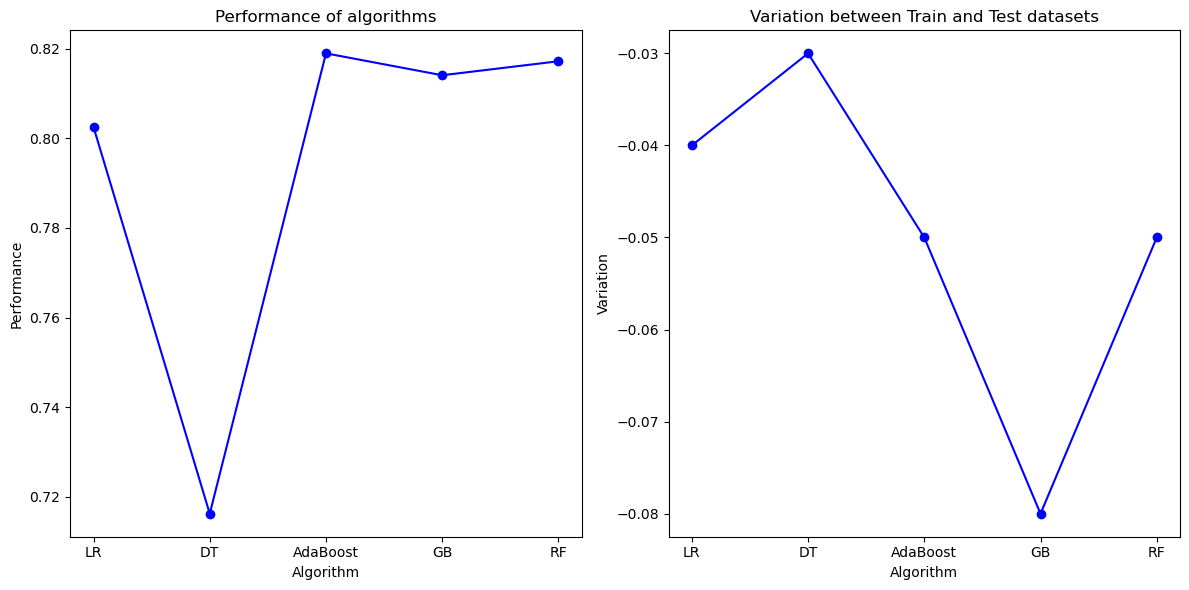

In [166]:
plot_performance(auc_list, métricas.keys(), variation_auc)

#### Precision score classification

In [167]:
# Criar uma lista contendo apenas o Auc Score no conjunto test de cada modelo.
# Criar uma lista contendo apenas a variação do Auc Score 

precision_list =[]
variation_prec = []
for i in métricas.keys():
    precision_list.append(métricas[i].loc['Precision','Teste'])
    variation_prec.append(métricas[i].loc['Precision','Variação'])

In [168]:
precision_list

[0.7006172839506173,
 0.5256637168141592,
 0.7091412742382271,
 0.7076502732240437,
 0.7582781456953642]

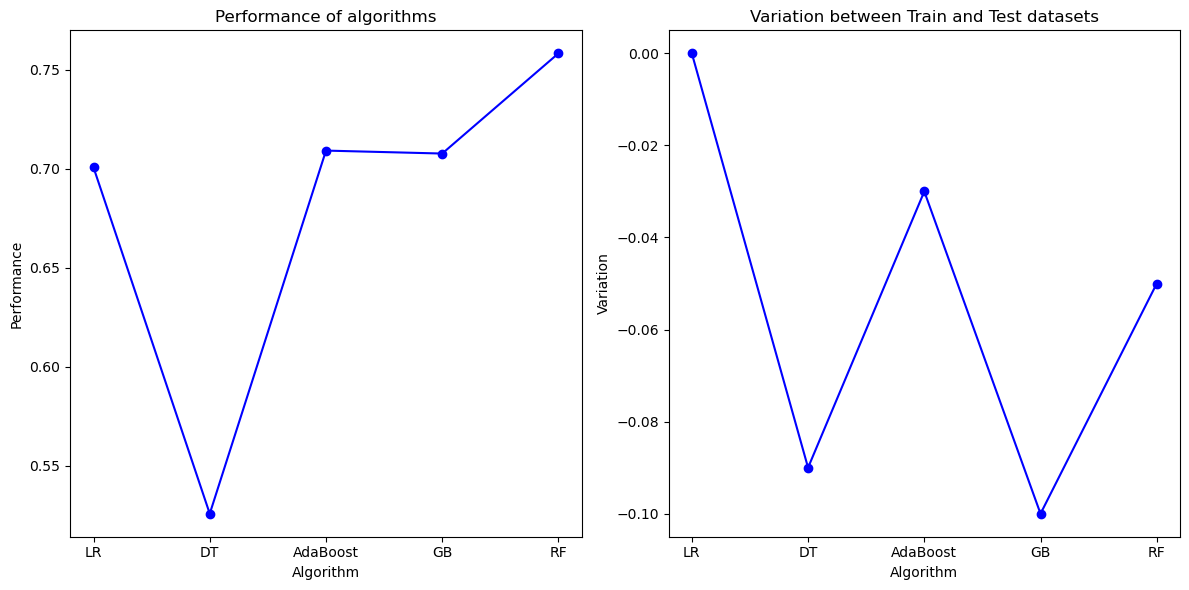

In [169]:
plot_performance(precision_list, métricas.keys(), variation_prec)

#### Recall score classification

In [170]:
recall_list =[]
variation_recall = []
for i in métricas.keys():
    recall_list.append(métricas[i].loc['Recall','Teste'])
    variation_recall.append(métricas[i].loc['Recall','Variação'])

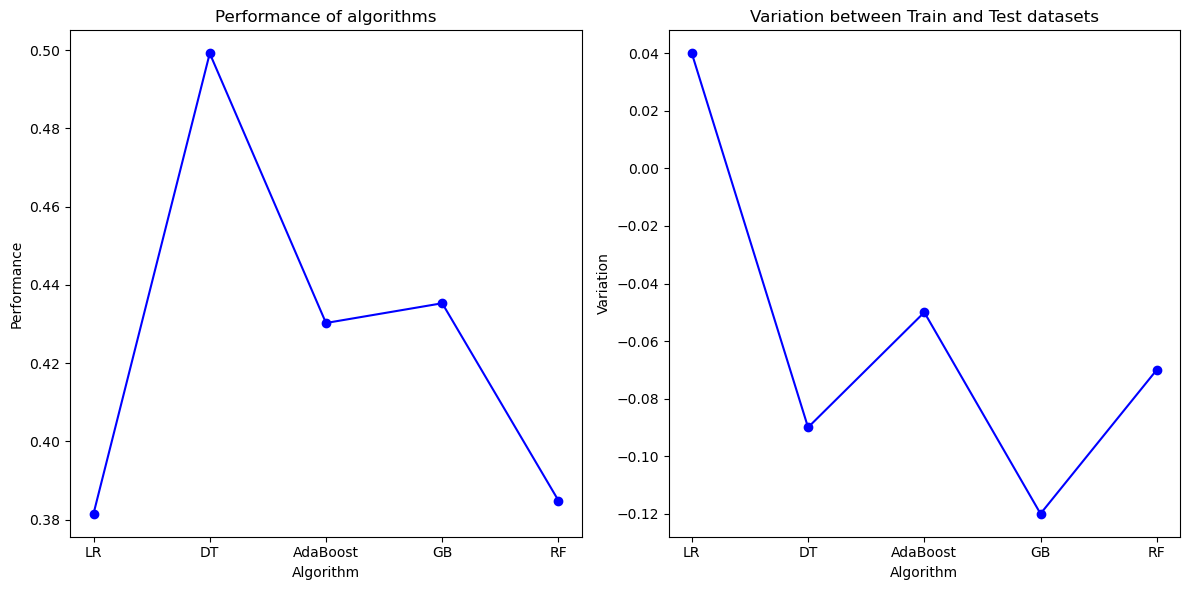

In [171]:
plot_performance(recall_list, métricas.keys(), variation_recall)

In [172]:
Modelos_metricas = pd.DataFrame(np.array([auc_list,variation_auc,
                                          precision_list,variation_prec,
                                          recall_list,variation_recall]).T,columns=['AUROC','AUROC var',
                                                                                                     'PRECISION','PRECISION var',
                                                                                                     'RECALL','RECALL var'],index = métricas.keys())

In [173]:
Modelos_metricas

AUROC  AUROC var  PRECISION  PRECISION var    RECALL  RECALL var
LR        0.802544      -0.04   0.700617           0.00  0.381513        0.04
DT        0.716177      -0.03   0.525664          -0.09  0.499160       -0.09
AdaBoost  0.819012      -0.05   0.709141          -0.03  0.430252       -0.05
GB        0.814120      -0.08   0.707650          -0.10  0.435294       -0.12
RF        0.817246      -0.05   0.758278          -0.05  0.384874       -0.07

### Applying Under Tomek sample balance

In [174]:
métricas_tomek, melhores_modelos_tomek = treino_modelos_class(x_train_under_tomek, y_train_under_tomek,x_test_select_dummies,y_test)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


c:\users\loren\documents\preditiva\preditiva\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning:


300 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "c:\users\loren\documents\preditiva\preditiva\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\loren\documents\preditiva\preditiva\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\users\loren\documents\preditiva\preditiva\lib\site-packages\sklearn\linear_model\_logistic.py"

Fitting 5 folds for each of 168 candidates, totalling 840 fits
Fitting 5 folds for each of 900 candidates, totalling 4500 fits
Fitting 5 folds for each of 1260 candidates, totalling 6300 fits
Fitting 5 folds for each of 180 candidates, totalling 900 fits


#### AUC Score classification

In [175]:
## Substituir o gráfico abaixo por dois gráficos de linhas
## 1) Comparando os maiores valores do score para o conjunto de teste entre os modelos
## 2) Comparando as variações do score entre treino e teste entre os modelos

In [176]:
auc_list_tomek =[]
variation_auc_tomek=[]
for i in métricas_tomek.keys():
    auc_list_tomek.append(métricas_tomek[i].loc['AUROC','Teste'])
    variation_auc_tomek.append(métricas_tomek[i].loc['AUROC','Variação'])

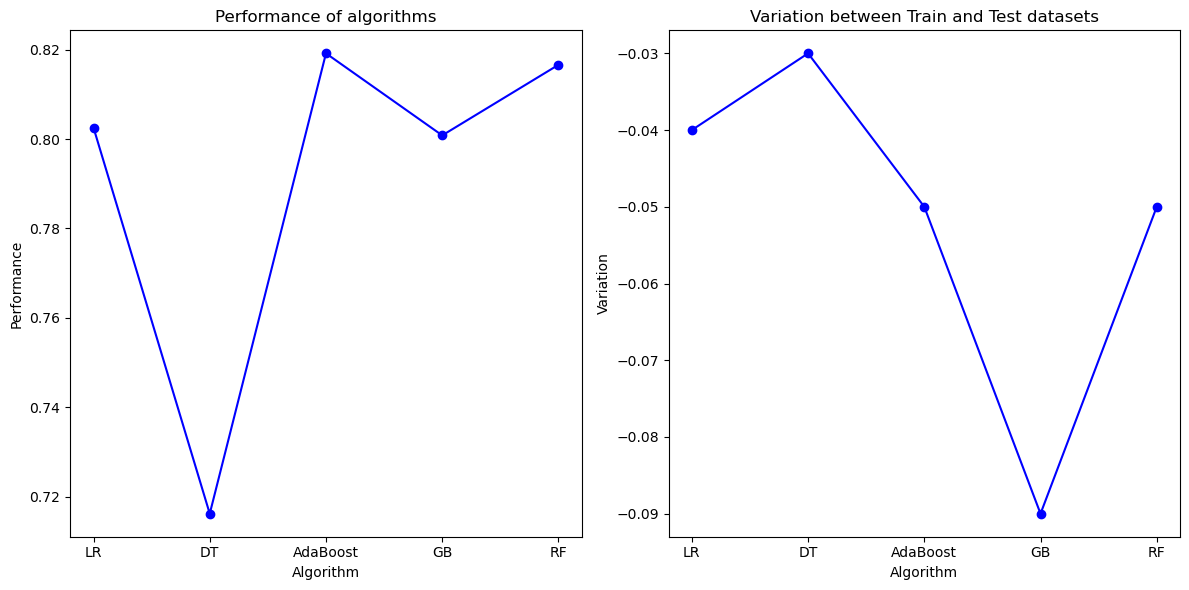

In [177]:
plot_performance(auc_list_tomek, métricas_tomek.keys(), variation_auc_tomek)

#### Precision score classification

In [178]:
# Criar uma lista contendo apenas o Auc Score no conjunto test de cada modelo.
# Criar uma lista contendo apenas a variação do Auc Score 

precision_list_tomek =[]
variation_prec_tomek = []
for i in métricas_tomek.keys():
    precision_list_tomek.append(métricas_tomek[i].loc['Precision','Teste'])
    variation_prec_tomek.append(métricas_tomek[i].loc['Precision','Variação'])

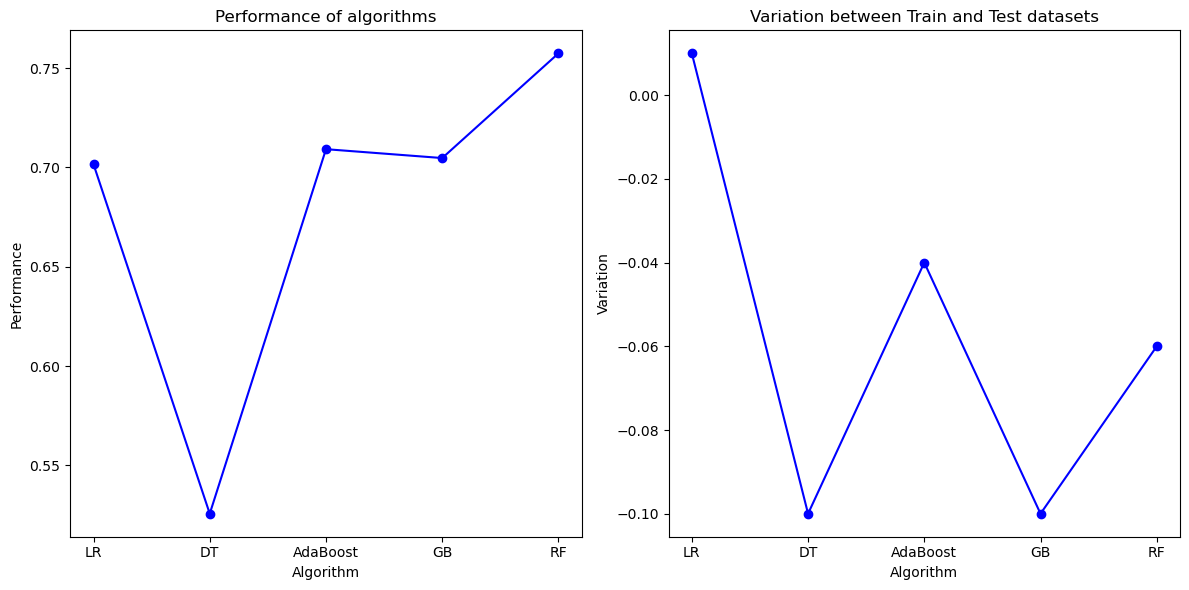

In [179]:
plot_performance(precision_list_tomek, métricas_tomek.keys(), variation_prec_tomek)

#### Recall score classification

In [180]:
recall_list_tomek =[]
variation_recall_tomek = []
for i in métricas_tomek.keys():
    recall_list_tomek.append(métricas_tomek[i].loc['Recall','Teste'])
    variation_recall_tomek.append(métricas_tomek[i].loc['Recall','Variação'])

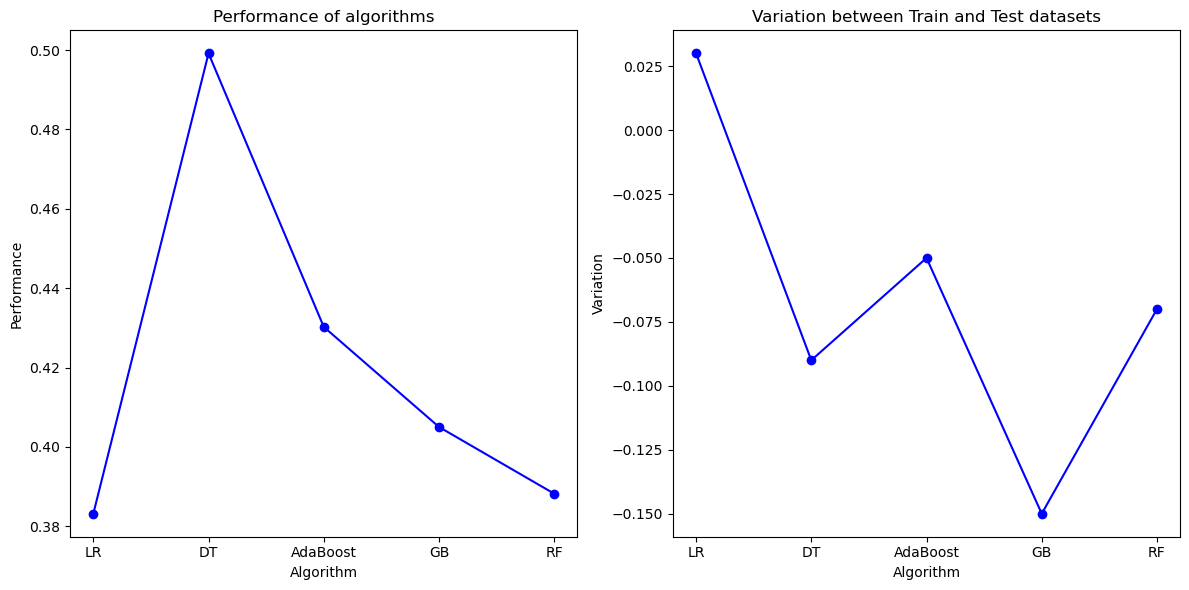

In [181]:
plot_performance(recall_list_tomek, métricas_tomek.keys(), variation_recall_tomek)

In [182]:
Modelos_metricas_tomek = pd.DataFrame(np.array([auc_list_tomek,variation_auc_tomek,
                                          precision_list_tomek,variation_prec_tomek,
                                          recall_list_tomek,variation_recall_tomek]).T,columns=['AUROC','AUROC var',
                                                                                                'PRECISION','PRECISION var',
                                                                                                'RECALL','RECALL var'],index = métricas.keys())

In [183]:
Modelos_metricas_tomek

AUROC  AUROC var  PRECISION  PRECISION var    RECALL  RECALL var
LR        0.802542      -0.04   0.701538           0.01  0.383193        0.03
DT        0.716177      -0.03   0.525664          -0.10  0.499160       -0.09
AdaBoost  0.819183      -0.05   0.709141          -0.04  0.430252       -0.05
GB        0.800827      -0.09   0.704678          -0.10  0.405042       -0.15
RF        0.816615      -0.05   0.757377          -0.06  0.388235       -0.07

### Applying Smote+Tomek sample balance

In [184]:
métricas_smote_tomek, melhores_modelos_smote_tomek = treino_modelos_class(x_train_smote_tomek, y_train_smote_tomek,x_test_select_dummies,y_test)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


c:\users\loren\documents\preditiva\preditiva\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning:


300 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "c:\users\loren\documents\preditiva\preditiva\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\loren\documents\preditiva\preditiva\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\users\loren\documents\preditiva\preditiva\lib\site-packages\sklearn\linear_model\_logistic.py"

Fitting 5 folds for each of 168 candidates, totalling 840 fits
Fitting 5 folds for each of 900 candidates, totalling 4500 fits
Fitting 5 folds for each of 1260 candidates, totalling 6300 fits
Fitting 5 folds for each of 180 candidates, totalling 900 fits


#### AUC Score classification

In [185]:
## Substituir o gráfico abaixo por dois gráficos de linhas
## 1) Comparando os maiores valores do score para o conjunto de teste entre os modelos
## 2) Comparando as variações do score entre treino e teste entre os modelos

In [186]:
auc_list_smotomek =[]
variation_auc_smotomek=[]
for i in métricas_smote_tomek.keys():
    auc_list_smotomek.append(métricas_smote_tomek[i].loc['AUROC','Teste'])
    variation_auc_smotomek.append(métricas_smote_tomek[i].loc['AUROC','Variação'])

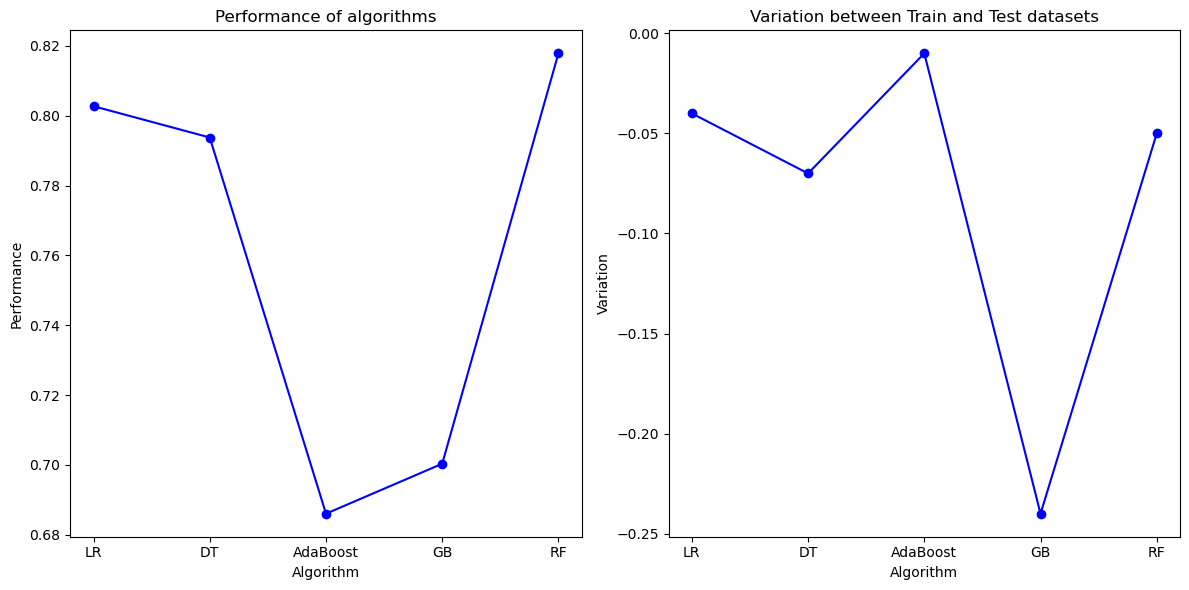

In [187]:
plot_performance(auc_list_smotomek, métricas_smote_tomek.keys(), variation_auc_smotomek)

#### Precision score classification

In [188]:
# Criar uma lista contendo apenas o Auc Score no conjunto test de cada modelo.
# Criar uma lista contendo apenas a variação do Auc Score 

precision_list_smotomek =[]
variation_prec_smotomek = []
for i in métricas_smote_tomek.keys():
    precision_list_smotomek.append(métricas_smote_tomek[i].loc['Precision','Teste'])
    variation_prec_smotomek.append(métricas_smote_tomek[i].loc['Precision','Variação'])

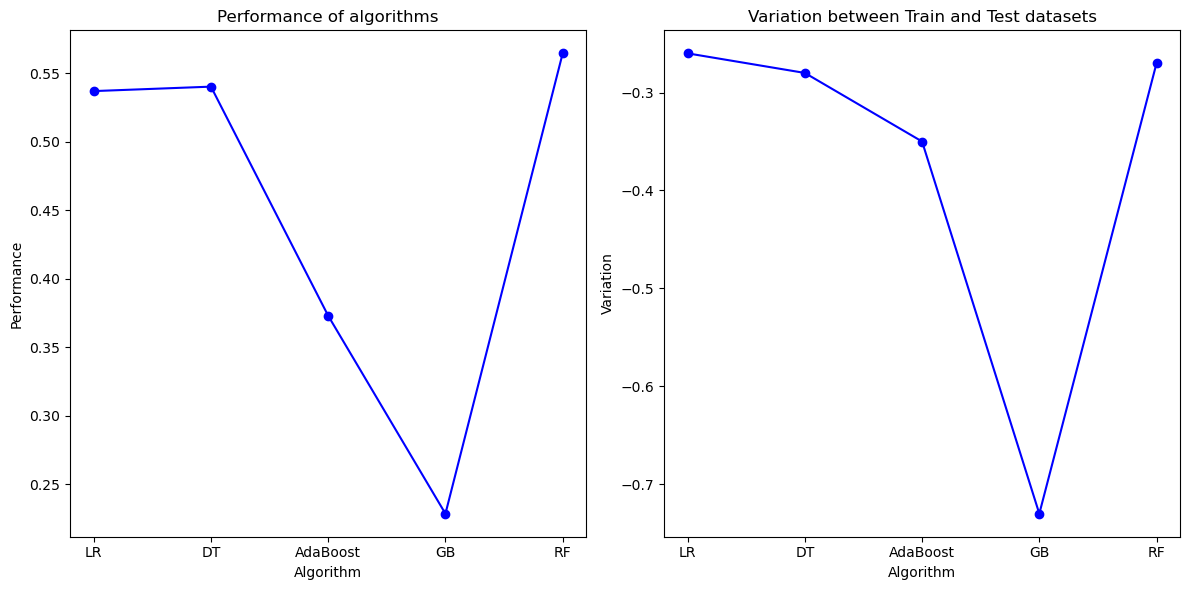

In [189]:
plot_performance(precision_list_smotomek, métricas_smote_tomek.keys(), variation_prec_smotomek)

#### Recall score classification

In [190]:
recall_list_smotomek =[]
variation_recall_smotomek = []
for i in métricas_tomek.keys():
    recall_list_smotomek.append(métricas_smote_tomek[i].loc['Recall','Teste'])
    variation_recall_smotomek.append(métricas_smote_tomek[i].loc['Recall','Variação'])

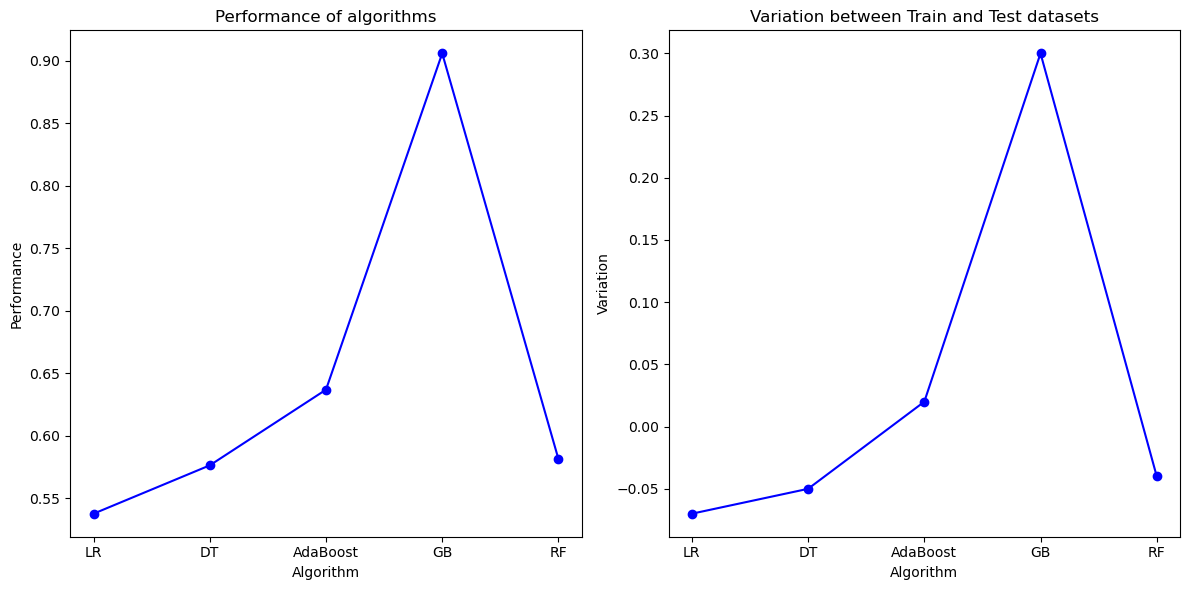

In [191]:
plot_performance(recall_list_smotomek, métricas_tomek.keys(), variation_recall_smotomek)

In [192]:
#Criar dataframe juntando todos os dataframes de métricas de cada tipo de balanceamento
Modelos_metricas_smotomek = pd.DataFrame(np.array([auc_list_smotomek,variation_auc_smotomek,
                                          precision_list_smotomek,variation_prec_smotomek,
                                          recall_list_smotomek,variation_recall_smotomek]).T,columns=['AUROC','AUROC var',
                                                                                                     'PRECISION','PRECISION var',
                                                                                                     'RECALL','RECALL var'],index = métricas.keys())

In [193]:
Modelos_metricas_smotomek

AUROC  AUROC var  PRECISION  PRECISION var    RECALL  RECALL var
LR        0.802700      -0.04   0.536913          -0.26  0.537815       -0.07
DT        0.793741      -0.07   0.540157          -0.28  0.576471       -0.05
AdaBoost  0.686055      -0.01   0.373031          -0.35  0.636975        0.02
GB        0.700359      -0.24   0.228681          -0.73  0.905882        0.30
RF        0.817830      -0.05   0.564437          -0.27  0.581513       -0.04

## Choosing the best model



### Which metrics should we prioritize in our project? In other words, do we need to reduce false positives or false negatives primarily? Besides, whats it is the threshold that minimizes that error?



By using the prediction model to define if the customer is gonna churn, above all we need to reduce false negatives. That kind of mistake makes the company loose the oportunity to increase its profits, once it will not offer coupons discounts to retain the customer.

Therefore, in order to reduce those false negatives, we need models with the highest **recall**. On the other hand, we can not let the **precision** decrease so much.

In [194]:
a = Modelos_metricas

In [195]:
b = Modelos_metricas_tomek

In [196]:
c = Modelos_metricas_smotomek

In [197]:
d = pd.concat([a,b,c],keys = ['Without','TOMEK','SMOTE+TOMEK'],names = ['Balance method','Alg'])

In [198]:
d

AUROC  AUROC var  PRECISION  PRECISION var  \
Balance method Alg                                                       
Without        LR        0.802544      -0.04   0.700617           0.00   
               DT        0.716177      -0.03   0.525664          -0.09   
               AdaBoost  0.819012      -0.05   0.709141          -0.03   
               GB        0.814120      -0.08   0.707650          -0.10   
               RF        0.817246      -0.05   0.758278          -0.05   
TOMEK          LR        0.802542      -0.04   0.701538           0.01   
               DT        0.716177      -0.03   0.525664          -0.10   
               AdaBoost  0.819183      -0.05   0.709141          -0.04   
               GB        0.800827      -0.09   0.704678          -0.10   
               RF        0.816615      -0.05   0.757377          -0.06   
SMOTE+TOMEK    LR        0.802700      -0.04   0.536913          -0.26   
               DT        0.793741      -0.07   0.540157          -0.28   
               AdaBoost  0.686055      -0.01   0.373031          -0.35   
               GB        0.700359      -0.24   0.228681          -0.73   
               RF        0.817830      -0.05   0.564437          -0.27   

                           RECALL  RECALL var  
Balance method Alg                             
Without        LR        0.381513        0.04  
               DT        0.499160       -0.09  
               AdaBoost  0.430252       -0.05  
               GB        0.435294       -0.12  
               RF        0.384874       -0.07  
TOMEK          LR        0.383193        0.03  
               DT        0.499160       -0.09  
               AdaBoost  0.430252       -0.05  
               GB        0.405042       -0.15  
               RF        0.388235       -0.07  
SMOTE+TOMEK    LR        0.537815       -0.07  
               DT        0.576471       -0.05  
               AdaBoost  0.636975        0.02  
               GB        0.905882        0.30  
               RF        0.581513       -0.04

In [199]:
d.loc[
    (d['RECALL var'] > -0.1) &
    (d['RECALL var'] <  0.1) &
    (d['PRECISION var'] > -0.1) &
    (d['PRECISION var'] < 0.1)
    ].sort_values(by=['RECALL', 'RECALL var', 'PRECISION', 'PRECISION var'],
                  ascending=[False, True, False, True])

AUROC  AUROC var  PRECISION  PRECISION var  \
Balance method Alg                                                       
Without        DT        0.716177      -0.03   0.525664          -0.09   
TOMEK          AdaBoost  0.819183      -0.05   0.709141          -0.04   
Without        AdaBoost  0.819012      -0.05   0.709141          -0.03   
TOMEK          RF        0.816615      -0.05   0.757377          -0.06   
Without        RF        0.817246      -0.05   0.758278          -0.05   
TOMEK          LR        0.802542      -0.04   0.701538           0.01   
Without        LR        0.802544      -0.04   0.700617           0.00   

                           RECALL  RECALL var  
Balance method Alg                             
Without        DT        0.499160       -0.09  
TOMEK          AdaBoost  0.430252       -0.05  
Without        AdaBoost  0.430252       -0.05  
TOMEK          RF        0.388235       -0.07  
Without        RF        0.384874       -0.07  
TOMEK          LR        0.383193        0.03  
Without        LR        0.381513        0.04

Alternatively, we could go for models that are really good at catching the customers who churned, even if they're not so great at precision. But the downside is, we might end up wrongly tagging a bunch of customers as 'Churned' when they actually didn't.

In [200]:
d.loc[
    (d['RECALL var'] > -0.1) &
    (d['RECALL var'] <  0.1) 
    ].sort_values(by=['RECALL', 'RECALL var', 'PRECISION', 'PRECISION var'],
                  ascending=[False, True, False, True])

AUROC  AUROC var  PRECISION  PRECISION var  \
Balance method Alg                                                       
SMOTE+TOMEK    AdaBoost  0.686055      -0.01   0.373031          -0.35   
               RF        0.817830      -0.05   0.564437          -0.27   
               DT        0.793741      -0.07   0.540157          -0.28   
               LR        0.802700      -0.04   0.536913          -0.26   
TOMEK          DT        0.716177      -0.03   0.525664          -0.10   
Without        DT        0.716177      -0.03   0.525664          -0.09   
TOMEK          AdaBoost  0.819183      -0.05   0.709141          -0.04   
Without        AdaBoost  0.819012      -0.05   0.709141          -0.03   
TOMEK          RF        0.816615      -0.05   0.757377          -0.06   
Without        RF        0.817246      -0.05   0.758278          -0.05   
TOMEK          LR        0.802542      -0.04   0.701538           0.01   
Without        LR        0.802544      -0.04   0.700617           0.00   

                           RECALL  RECALL var  
Balance method Alg                             
SMOTE+TOMEK    AdaBoost  0.636975        0.02  
               RF        0.581513       -0.04  
               DT        0.576471       -0.05  
               LR        0.537815       -0.07  
TOMEK          DT        0.499160       -0.09  
Without        DT        0.499160       -0.09  
TOMEK          AdaBoost  0.430252       -0.05  
Without        AdaBoost  0.430252       -0.05  
TOMEK          RF        0.388235       -0.07  
Without        RF        0.384874       -0.07  
TOMEK          LR        0.383193        0.03  
Without        LR        0.381513        0.04

# Performance analysis


Following the logic of the business rule, the model that presented the best performance was Random Forest.

In [201]:
## Inserir o melhor modelo 
##Acessar a lista dos melhores modelos para o método de balanceamento escolhido

In [202]:
melhores_modelos, melhores_modelos_tomek, melhores_modelos_smote_tomek

({'LR': LogisticRegression(C=1, random_state=42),
  'DT': DecisionTreeClassifier(max_depth=2, min_samples_leaf=5, min_samples_split=10,
                         random_state=42),
  'AdaBoost': AdaBoostClassifier(learning_rate=0.08700000000000001, n_estimators=500,
                     random_state=42),
  'GB': GradientBoostingClassifier(max_depth=5, min_samples_leaf=10, n_estimators=300,
                             random_state=42, subsample=0.4),
  'RF': RandomForestClassifier(max_depth=5, min_samples_leaf=5, n_estimators=300,
                         random_state=42)},
 {'LR': LogisticRegression(C=10, random_state=42),
  'DT': DecisionTreeClassifier(max_depth=2, min_samples_leaf=5, min_samples_split=10,
                         random_state=42),
  'AdaBoost': AdaBoostClassifier(learning_rate=0.083, n_estimators=500, random_state=42),
  'GB': GradientBoostingClassifier(max_depth=5, min_samples_leaf=5, n_estimators=500,
                             random_state=42, subsample=0.1),
  '

## Regarding the precision variation

In [203]:
type(melhores_modelos['DT'])

sklearn.tree._classes.DecisionTreeClassifier

In [204]:
modelo_escolhido_1 = melhores_modelos['DT']

In [205]:
modelo_escolhido_1

DecisionTreeClassifier(max_depth=2, min_samples_leaf=5, min_samples_split=10,
                       random_state=42)

In [206]:
# Probabilities predictions from dataset according to the chosen model

predTestProb_1  = modelo_escolhido_1.predict_proba(x_test_select_dummies)[:,1]

predTest_1 = modelo_escolhido_1.predict(x_test_select_dummies)



### Confusion matrix

In [207]:
# Pacote que cria a matriz de confusão
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [208]:
cm = confusion_matrix(y_test, predTest_1)

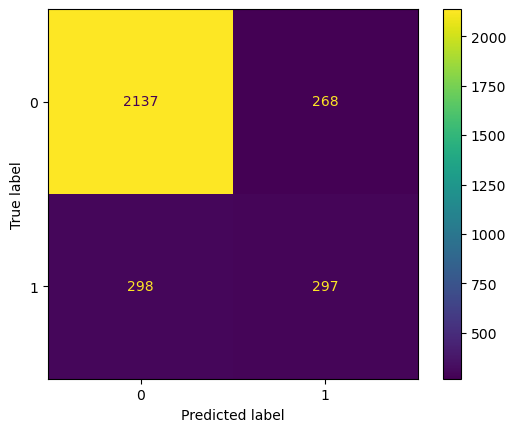

In [209]:
ConfusionMatrixDisplay(confusion_matrix=cm,).plot();

In [210]:
print(classification_report(y_test, predTest_1))

              precision    recall  f1-score   support

           0       0.88      0.89      0.88      2405
           1       0.53      0.50      0.51       595

    accuracy                           0.81      3000
   macro avg       0.70      0.69      0.70      3000
weighted avg       0.81      0.81      0.81      3000



By using standard threshold of 0.5, we can state:
- **Precision for true positive:** 0,53 >> From all customers the model classified as 'customer churned', 53% actually churned.<br>
- **Precision for true negative:** 0,88 >> From all customers the model classified as 'customer NOT churned', 88% actually **DID NOT** churned.<br>
- **Recall for true positive:** 0,50 >> From all customers that actually churned, the model classified it correctly 50% of them.<br>
- **Recall for true negative(Specificity) :** 0.89 >> From all customers that **DID NOT** churned, the model classified it correctly 89% of them.<br>

### ROC curve

In [211]:
from sklearn.metrics import roc_curve

In [213]:
fpr_1, tpr_1, thresholds_1 = roc_curve(y_test, predTestProb_1,drop_intermediate = False)

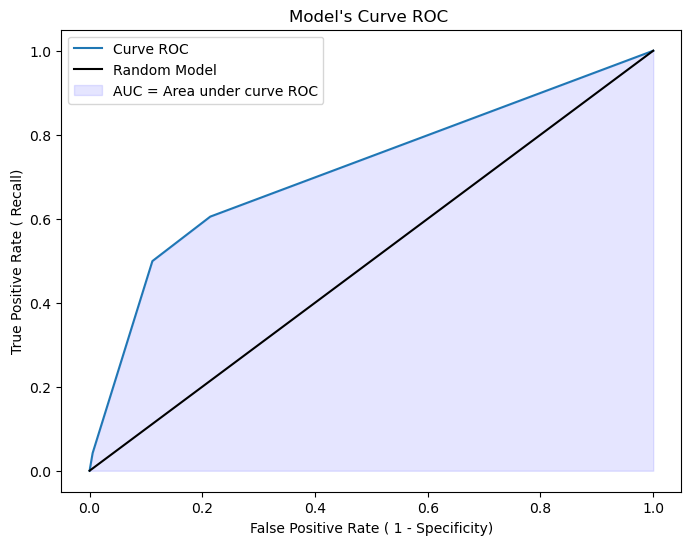

In [214]:
plt.figure(figsize=(8,6))

plt.plot(fpr_1,tpr_1, label='Curve ROC')
plt.fill_between(fpr_1,tpr_1,color='blue',alpha= 0.1,label = 'AUC = Area under curve ROC')
plt.plot(np.linspace(0,1,100),np.linspace(0,1,100),color='black',label='Random Model')

plt.title("Model's Curve ROC ")
plt.ylabel('True Positive Rate ( Recall)')
plt.xlabel('False Positive Rate ( 1 - Specificity)')
plt.legend();



### How can we further improve the model by manipulating Threshold?

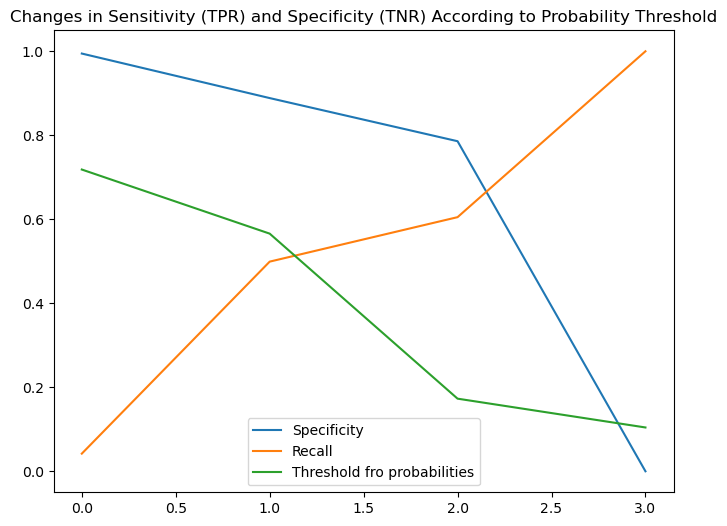

In [215]:
plt.figure(figsize=(8,6))

plt.plot(1-fpr_1[1:],label='Specificity')
plt.plot(tpr_1[1:],label='Recall')
plt.plot(thresholds_1[1:],label='Threshold fro probabilities')
         
plt.legend()
plt.title("Changes in Sensitivity (TPR) and Specificity (TNR) According to Probability Threshold");

## NOT regarding precision variation

In [216]:
type(melhores_modelos_smote_tomek['RF'])

sklearn.ensemble._forest.RandomForestClassifier

In [217]:
modelo_escolhido_2 = melhores_modelos_smote_tomek['RF']

In [218]:
modelo_escolhido_2

RandomForestClassifier(max_depth=5, min_samples_leaf=5, n_estimators=200,
                       random_state=42)

In [219]:
# Probabilities predictions from dataset according to the chosen model

predTestProb_2  = modelo_escolhido_2.predict_proba(x_test_select_dummies)[:,1]

predTest_2 = modelo_escolhido_2.predict(x_test_select_dummies)



### Confusion matrix

In [220]:
cm_2 = confusion_matrix(y_test, predTest_2)

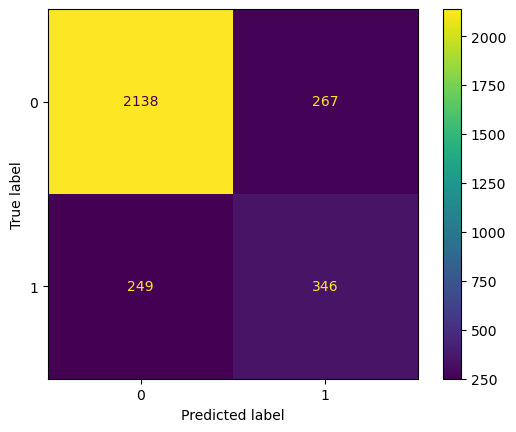

In [221]:
ConfusionMatrixDisplay(confusion_matrix=cm_2,).plot();

In [222]:
print(classification_report(y_test, predTest_2))

              precision    recall  f1-score   support

           0       0.90      0.89      0.89      2405
           1       0.56      0.58      0.57       595

    accuracy                           0.83      3000
   macro avg       0.73      0.74      0.73      3000
weighted avg       0.83      0.83      0.83      3000



By using standart threshold of 0.5, we can state:
- **Precision for true positive:** 0,56 >> From all customers the model classified as 'customer churned', 56% actually churned.<br>
- **Precision for true negative:** 0,90 >> From all customers the model classified as 'customer NOT churned', 90% actually **DID NOT** churned.<br>
- **Recall for true positive:** 0,58 >> From all customers that actually churned, the model classified it correctly 58% of them.<br>
- **Recall for true negative(Specificity) :** 0.89 >> From all customers that **DID NOT** churned, the model classified it correctly 89% of them.<br>

### ROC curve

In [223]:
fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, predTestProb_2)

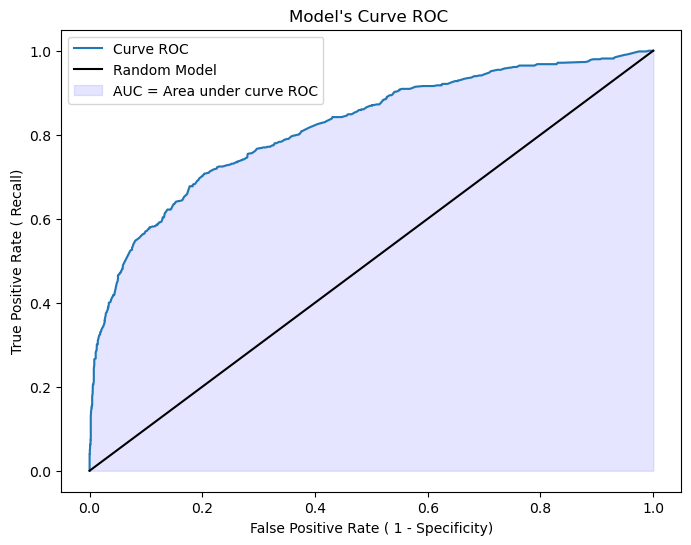

In [224]:
plt.figure(figsize=(8,6))

plt.plot(fpr_2, tpr_2, label='Curve ROC')
plt.fill_between(fpr_2, tpr_2,color='blue',alpha= 0.1,label = 'AUC = Area under curve ROC')
plt.plot(np.linspace(0,1,100),np.linspace(0,1,100),color='black',label='Random Model')

plt.title("Model's Curve ROC ")
plt.ylabel('True Positive Rate ( Recall)')
plt.xlabel('False Positive Rate ( 1 - Specificity)')
plt.legend();



### How can we further improve the model by manipulating Threshold?

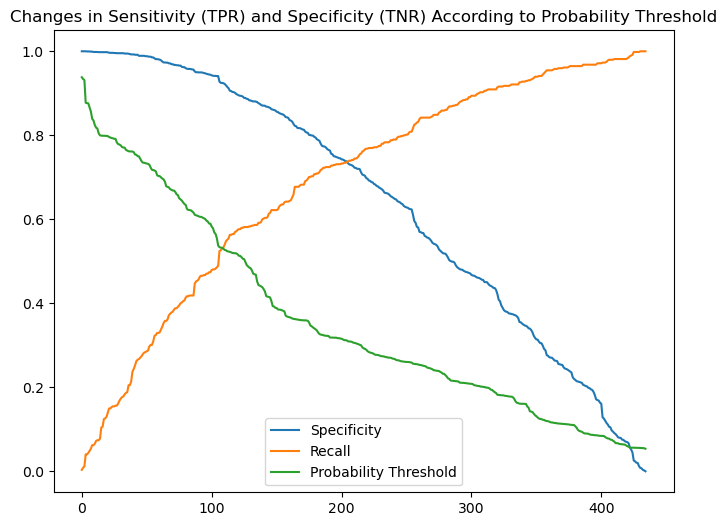

In [225]:
plt.figure(figsize=(8,6))

plt.plot(1-fpr_2[1:],label='Specificity')
plt.plot(tpr_2[1:],label='Recall')
plt.plot(thresholds_2[1:],label='Probability Threshold')
         
plt.legend()
plt.title("Changes in Sensitivity (TPR) and Specificity (TNR) According to Probability Threshold");

# Financial impact assesment

In [226]:

LTV =  df['sum_pedidos_acumulado'].mean()
CAC = 150
discount = 100

In [227]:

matrix_finance = {'Não Churn (R$)':[LTV -CAC,-CAC],'Churn (R$)':[LTV-CAC-discount,LTV-CAC-discount]}

matrix_finance

{'Não Churn (R$)': [267.042754, -150], 'Churn (R$)': [167.042754, 167.042754]}

In [228]:
matrix_finance = pd.DataFrame(matrix_finance,index = ['Não Churn','Churn'])
matrix_finance

Não Churn (R$)  Churn (R$)
Não Churn      267.042754  167.042754
Churn         -150.000000  167.042754

## Before the model implementation

In [229]:
len(df.loc[x_test_select_dummies.index,'churn'][df['churn']==1])

595

In [230]:
Churn = len(df.loc[x_test_select_dummies.index,'churn'][df['churn']==1])

N_Churn = len(df.loc[x_test_select_dummies.index,'churn'])-Churn
N_Churn

2405

In [231]:
Churn = df[df['churn'] == 1].shape[0]
N_Churn = df.shape[0] - Churn
Churn, N_Churn

(2013, 7987)

In [232]:

matrix_finance_before = {'Não Churn (R$)':[LTV -CAC,-CAC],'Churn (R$)':[-CAC,LTV-CAC]}

matrix_finance_before
matrix_finance_before = pd.DataFrame(matrix_finance_before,index = ['Não Churn','Churn'])
matrix_finance_before


Não Churn (R$)  Churn (R$)
Não Churn      267.042754 -150.000000
Churn         -150.000000  267.042754

In [233]:

matrix_confusion_before = {'Não Churn (R$)':[N_Churn,Churn],'Churn (R$)':[0,0]}

matrix_confusion_before =pd.DataFrame(matrix_confusion_before, index = ['Não Churn','Churn'])

matrix_finance_before = matrix_finance_before*matrix_confusion_before
#Calculando os totais das colunas 
soma_colunas = matrix_finance_before.sum()

#Adicionando a coluna que contém os valores totais
soma_colunas.name = 'Total'

#Adicionando a linha que contém os valores totais 
matrix_finance_before = matrix_finance_before.append(soma_colunas)

#Calculando os totais das linhas
soma_linhas =  matrix_finance_before.T.sum()

#Adicionando a coluna que contém os valores totais 
matrix_finance_before['Total'] = soma_linhas
matrix_finance_before

Não Churn (R$)  Churn (R$)         Total
Não Churn    2.132870e+06        -0.0  2.132870e+06
Churn       -3.019500e+05         0.0 -3.019500e+05
Total        1.830920e+06         0.0  1.830920e+06

In [234]:
Lucro_before = matrix_finance_before.iloc[2,2]/df.shape[0]
Lucro_before

183.09204761979998


## After implementing the model (Which threshold gives the best result for financial impact?)

## Regarding the precision variation

In [235]:
thresholds_list_1 =  thresholds_1[1:]
recall_list_1 = tpr_1[1:]
especificidade_list_1 = 1-fpr_1[1:]
prob_1 = predTestProb_1



def threshold_choice(thresholds_list,matriz_finan,y_test, prob):
    profit_list = []
    for threshold in thresholds_list[:]:

        #Predição de acordo com cada threshold
        pred_test=np.where(prob>threshold,1,0)
        
        #Criando matriz de confusão
        cm = confusion_matrix(y_test, pred_test)
        
        #Multiplicando as matrizes confusão (financeira x predição)
        Valor_finan_total = np.array(matriz_finan)*cm
    
        #Transformando em Dataframe
        Valor_finan_total = pd.DataFrame(Valor_finan_total)
                                         
        #Calculando os totais das colunas 
        soma_colunas = Valor_finan_total.sum()

        #Adicionando a coluna que contém os valores totais
        soma_colunas.name = 'Total'

        #Adicionando a linha que contém os valores totais 
        Valor_finan_total = Valor_finan_total.append(soma_colunas)

        #Calculando os totais das linhas
        soma_linhas =  Valor_finan_total.T.sum()

        #Adicionando a coluna que contém os valores totais 
        Valor_finan_total['Total'] = soma_linhas
        
        #Adicionando a receita por cliente da matriz de confusão a lista de receita
        profit_list.append(Valor_finan_total.iloc[2,2]/y_test.shape[0])
        
    return profit_list

In [264]:
profit_list = threshold_choice(thresholds_list_1,matrix_finance,y_test,prob_1)

In [238]:
profit_list = np.array(profit_list)

In [239]:
d = {'Threshold':thresholds_list_1,'Recall':recall_list_1,'Especificidade':especificidade_list_1,
     'Potential profit/customer': profit_list}

In [240]:
dataframe = pd.DataFrame(d)

In [241]:
dataframe['Profit increase/decrease per customer (R$)'] = dataframe['Potential profit/customer']-Lucro_before

In [242]:
dataframe['Total Profit'] = ( dataframe['Potential profit/customer'] )*df.shape[0]

In [243]:
dataframe

Threshold    Recall  Especificidade  Potential profit/customer  \
0   0.718447  0.042017        0.994595                 184.329274   
1   0.565811  0.499160        0.888565                 186.537964   
2   0.172891  0.605042        0.785863                 206.783174   
3   0.104302  1.000000        0.000000                 205.207738   

   Profit increase/decrease per customer (R$)  Total Profit  
0                                    1.237227  1.843293e+06  
1                                    3.445916  1.865380e+06  
2                                   23.691126  2.067832e+06  
3                                   22.115691  2.052077e+06

In [244]:
dataframe['Total Profit'].idxmax()

2

In [247]:
dataframe.loc[2,:]

Threshold                                     1.728907e-01
Recall                                        6.050420e-01
Especificidade                                7.858628e-01
Potential profit/customer                     2.067832e+02
Profit increase/decrease per customer (R$)    2.369113e+01
Total Profit                                  2.067832e+06
Name: 2, dtype: float64

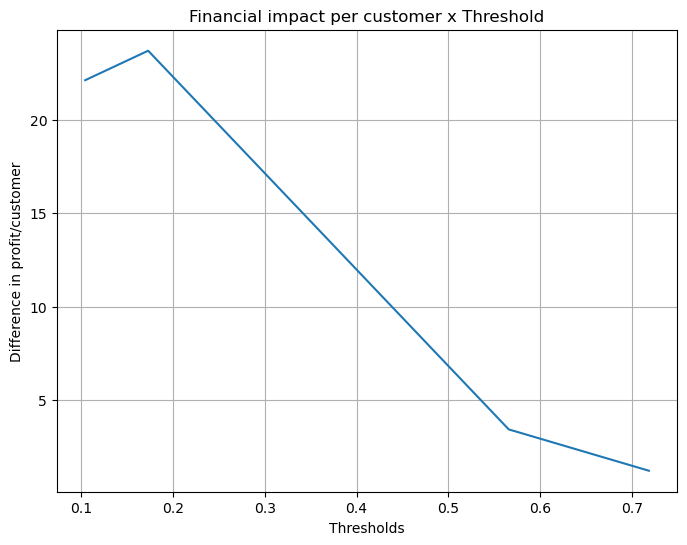

In [248]:
# Plotar o gráfico
plt.figure(figsize=(8,6))
plt.plot(thresholds_list_1, dataframe['Profit increase/decrease per customer (R$)'], linestyle='-')

# Adicionar rótulos aos eixos
plt.xlabel('Thresholds')
plt.ylabel('Difference in profit/customer')

# Adicionar título ao gráfico

plt.title('Financial impact per customer x Threshold')
# Exibir o gráfico
plt.grid(True)
plt.show()

## NOT regarding the precision variation

In [249]:
thresholds_list_2 =  thresholds_2[1:]
recall_list_2 = tpr_2[1:]
especificidade_list_2 = 1-fpr_2[1:]
prob_2 = predTestProb_2


In [250]:
profit_list_2 = threshold_choice(thresholds_list_2,matrix_finance,y_test,predTestProb_2);

In [251]:
profit_list_2 = np.array(profit_list_2)

In [252]:
d_2 = {'Threshold':thresholds_list_2,'Recall':recall_list_2,'Especificidade':especificidade_list_2,
     'Potential profit/customer': profit_list_2}

In [253]:
dataframe_2 = pd.DataFrame(d_2)

In [254]:
dataframe_2['Profit increase/decrease per customer (R$)'] = dataframe_2['Potential profit/customer']-Lucro_before

In [255]:
dataframe_2['Total Profit'] = ( dataframe_2['Potential profit/customer'] )*df.shape[0]

In [256]:
dataframe_2.head()

Threshold    Recall  Especificidade  Potential profit/customer  \
0   0.938194  0.003361        1.000000                 184.329274   
1   0.934016  0.008403        1.000000                 184.751998   
2   0.931517  0.011765        1.000000                 184.857679   
3   0.877357  0.040336        1.000000                 186.759936   
4   0.876484  0.040336        0.999584                 186.865616   

   Profit increase/decrease per customer (R$)  Total Profit  
0                                    1.237227  1.843293e+06  
1                                    1.659951  1.847520e+06  
2                                    1.765631  1.848577e+06  
3                                    3.667888  1.867599e+06  
4                                    3.773569  1.868656e+06

In [257]:
dataframe_2['Total Profit'].idxmax()

165

In [258]:
dataframe_2['Profit increase/decrease per customer (R$)'].idxmax()

165

In [259]:
dataframe_2.loc[165,:]

Threshold                                     3.616316e-01
Recall                                        6.773109e-01
Especificidade                                8.216216e-01
Potential profit/customer                     2.126854e+02
Profit increase/decrease per customer (R$)    2.959330e+01
Total Profit                                  2.126854e+06
Name: 165, dtype: float64

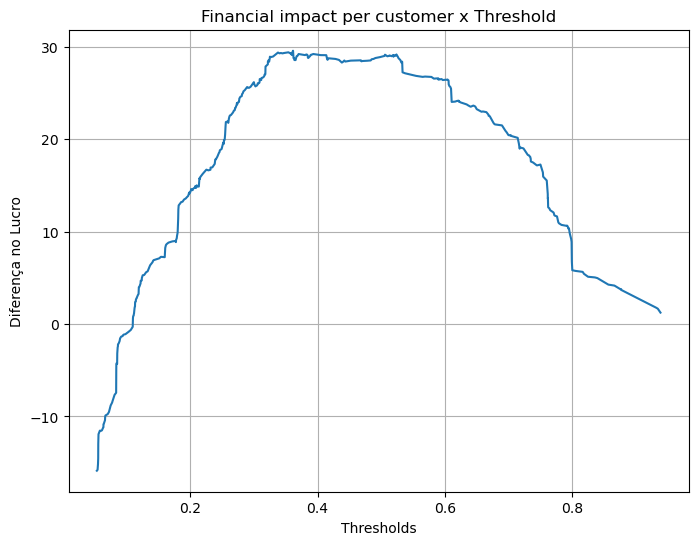

In [260]:
# Plotar o gráfico
plt.figure(figsize=(8,6))
plt.plot(thresholds_list_2, dataframe_2['Profit increase/decrease per customer (R$)'], linestyle='-')

# Adicionar rótulos aos eixos
plt.xlabel('Thresholds')
plt.ylabel('Diferença no Lucro')

# Adicionar título ao gráfico
plt.title('Impacto financeiro por cliente de acordo com cada Threshold')
plt.title('Financial impact per customer x Threshold')
# Exibir o gráfico
plt.grid(True)
plt.show()

## Comparison of the financial impact between the two models 

In [263]:
print('Profit increase per customer using model that  regard precision variation:')
print(dataframe.loc[2,:]['Profit increase/decrease per customer (R$)'])



Profit increase per customer using model that  regard precision variation:
23.691126149533375


In [262]:
print('Profit increase per customer using model that do NOT regard precision variation:')
print(dataframe_2.loc[165,:]['Profit increase/decrease per customer (R$)'])

Profit increase per customer using model that do NOT regard precision variation:
29.593303457533352
